<div style="width: 98%; max-width: 1200px; margin: 0 auto; font-family: Helvetica, Arial, sans-serif;">

<div style="
        background-color: #141E30; 
        background-image: linear-gradient(to right, #141E30, #243B55);
        border-radius: 10px;
        padding: 25px;
        text-align: center;
        margin-bottom: 20px;
        border: 1px solid #2c3e50;
        box-shadow: 0 4px 8px rgba(0,0,0,0.3);
    ">
        <h1 style="color: white; margin: 0; text-transform: uppercase; font-size: 24px; font-weight: normal; letter-spacing: 2px;">
            TP 1 : Parcours des protons dans la matière
        </h1>
        <h3 style="color: #a8d0e6; margin-top: 10px; margin-bottom: 0; font-weight: normal; font-style: italic; font-size: 16px;">
            Transport et dépôt d'énergie des faisceaux de protons à des fins thérapeutiques
        </h3>
    </div>

<!-- Utilisation de Markdown plus simple pour GitHub -->
<div style="background-color: #141E30; border: 2px solid #a8d0e6; border-radius: 10px; padding: 20px; color: white;">

### Équipe de recherche
**Alex Baker** - 537 050 929  
**Justine Jean** - 537 287 332  
**Nerimantas Caillat** - 537 396 153  

### Informations académiques
**Cours :** PHY-3500 – Physique numérique (H26)  
**Remise :** 16 février 2026  
**Encadrement :** Pr. Antoine Allard, Thomas Labbé, Philippe Després

</div>

</div>

### Objectifs et Contexte

<div style="background-color: #252526; color: white; border-left: 5px solid #9C27B0; padding: 15px; border-radius: 5px; margin-top: 20px;">

<strong style="color: #E1BEE7; font-size: 1.1em;">Contexte clinique :</strong>
<br><br>
La protonthérapie permet de traiter des tumeurs (comme les mélanomes oculaires) en épargnant les tissus sains grâce au *pic de Bragg*. Contrairement aux photons, la balistique des protons doit être calculée avec une précision extrême pour éviter d'irradier des organes critiques (ex: le nerf optique).

<strong style="color: #E1BEE7; font-size: 1.1em;">But du TP :</strong>
<br>
1. **Déterminer numériquement la portée** ($R_{\text{CSDA}}$) des protons dans des tissus biologiques (Eau, Os) en utilisant le formalisme de Bethe-Bloch.
2. **Implémenter et comparer** des méthodes d'intégration numérique (Trapèzes vs Simpson) en termes de précision et de temps de calcul.
3. **Simuler** le dépôt d'énergie en profondeur pour visualiser le pic de Bragg.

</div>

In [ ]:
# ============================================================================
# CONFIGURATION ET IMPORTATION DES MODULES
# ============================================================================
"""
Ce notebook utilise les bibliothèques scientifiques standard de Python pour
l'analyse numérique et la visualisation. Toutes les dépendances sont 
disponibles dans l'environnement conda/pip standard.
"""

# Calcul scientifique
import numpy as np
from scipy.constants import m_e, m_p, c, physical_constants
from scipy.stats import moyal, sem
from scipy.interpolate import interp1d
import pandas as pd
from scipy.integrate import quad

# Visualisation
import matplotlib.pyplot as plt

# Mesure de performance
import time
import platform
import os

# Configuration esthétique des graphiques
plt.rcParams.update({
    'figure.figsize': (12, 7),
    'figure.dpi': 100,
    'font.size': 11,
    'font.family': 'serif',
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'axes.titleweight': 'bold',
    'axes.grid': True,
    'grid.alpha': 0.3,
    'lines.linewidth': 2,
    'legend.fontsize': 11,
    'legend.framealpha': 0.9,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
})

print("="*40)
print("   CONFIGURATION DU NOTEBOOK RÉUSSIE")
print("="*40)
print(f"   NumPy version    : {np.__version__}")
print(f"   Python version   : {platform.python_version()}")
print(f"   Plateforme       : {platform.system()} {platform.release()}")
print("="*40)

   CONFIGURATION DU NOTEBOOK RÉUSSIE
   NumPy version    : 2.4.1
   Python version   : 3.11.9
   Plateforme       : Windows 10


<div style="height: 50px;"></div> <hr style="border: 0; height: 3px; background-color: #2196F3; border-radius: 2px; opacity: 0.7;">
<br />

# Question 1 : Densité électronique et pouvoir d'arrêt collisionnel

<div style="background-color: #252526; color: white; border-left: 5px solid #2196F3; padding: 15px; border-radius: 5px;">

**Énoncé :** *Exprimer la densité électronique $n_e$ d’un milieu en fonction de la composition atomique et de sa masse volumique $\rho$, et calculer $n_e$ pour l'eau (liquide) et l'os compact (définition de l’ICRU). On s’appuiera sur les données du NIST pour les compositions atomiques de ces matériaux. Vous trouverez aussi les énergies moyennes d’excitation $I$ de ces matériaux sur le site du NIST. Tracez les courbes des pouvoirs d’arrêt collisionnel pour ces milieux. On utilisera une échelle logarithmique en abscisse.*

</div>

## 1.1 Dérivation théorique de la densité électronique $n_e$

### Cas d'un élément pur

Pour un matériau monoatomique de numéro atomique $Z$, de masse molaire $A$ (g/mol) et de masse volumique $\rho$ (g/cm³), la dérivation procède comme suit :

| **Étape** | **Expression** | **Signification physique** |
|:----------|:---------------|:---------------------------|
| 1. Moles par cm³ | $n_{\text{mol}} = \dfrac{\rho}{A}$ | Concentration molaire |
| 2. Atomes par cm³ | $n_{\text{at}} = N_A \cdot \dfrac{\rho}{A}$ | Densité atomique |
| 3. Électrons par cm³ | $n_e = Z \cdot N_A \cdot \dfrac{\rho}{A}$ | **Densité électronique** |

<div style="height: 0.75cm;"></div>

### Généralisation aux composés multi-éléments

Pour un matériau composé de plusieurs éléments (indices $i$), chacun contribuant selon sa fraction massique $w_i$, la formule devient :

$$\boxed{n_e = N_A \cdot \rho \cdot \sum_{i} w_i \frac{Z_i}{A_i}}$$

#### Définition des paramètres

| Symbole | Description | Unité |
|:--------|:------------|:------|
| $N_A$ | Nombre d'Avogadro | $6.022 \times 10^{23}$ mol⁻¹ |
| $\rho$ | Masse volumique du matériau | g/cm³ |
| $w_i$ | Fraction massique de l'élément $i$ ($\sum_i w_i = 1$) | sans dimension |
| $Z_i$ | Numéro atomique de l'élément $i$ | sans dimension |
| $A_i$ | Masse molaire de l'élément $i$ | g/mol |

<div style="height: 0.75cm;"></div>

### Interprétation physique de chaque terme

$$n_e = \underbrace{N_A}_{\text{Avogadro}} \cdot \underbrace{\rho}_{\substack{\text{masse} \\ \text{par vol.}}} \cdot \sum_{i} \underbrace{w_i}_{\substack{\text{fraction} \\ \text{massique}}} \cdot \underbrace{\frac{Z_i}{A_i}}_{\substack{\text{électrons} \\ \text{par gramme}}}$$

Le terme $Z_i / A_i$ représente le nombre d'électrons par gramme de l'élément $i$ (multiplié par $N_A$)

### Vérification dimensionnelle

$$[n_e] = \underbrace{[\text{mol}^{-1}]}_{N_A} \cdot \underbrace{[\text{g/cm}^3]}_{\rho} \cdot \underbrace{[1]}_{w_i} \cdot \underbrace{[\text{mol/g}]}_{1/A_i} = [\text{cm}^{-3}] \quad \checkmark$$

### Exemple de calcul : H₂O

**Données :** $M_{\text{H}_2\text{O}} = 18.015$ g/mol, $\rho = 1.00$ g/cm³

**Fractions massiques :**
- H : $w_\text{H} = \dfrac{2 \times 1.008}{18.015} = 0.1119$ (11.19%)

<div style="height: 0.5cm;"></div>

- O : $w_\text{O} = \dfrac{15.999}{18.015} = 0.8881$ (88.81%)

**Calcul :**
$$n_e = 6.022 \times 10^{23} \times 1.00 \times \left( 0.1119 \times \frac{1}{1.008} + 0.8881 \times \frac{8}{15.999} \right)$$
$$n_e = 6.022 \times 10^{23} \times (0.1110 + 0.4441) = \boxed{3.343 \times 10^{23} \text{ e}^-/\text{cm}^3}$$

<br />

## 1.2 Données des matériaux (NIST)

Les propriétés des matériaux sont extraites de la base de données **NIST PSTAR** et du document de référence **ICRU Report 49**.

<div style="height: 0.2cm;"></div>

### Eau liquide (Water, Liquid)

| Propriété | Valeur | Source |
|:----------|:-------|:-------|
| Masse volumique $\rho$ | 1.000 g/cm³ | NIST |
| Énergie moyenne d'excitation $I$ | 75.0 eV | ICRU 49 |
| Composition | H : 11.19%, O : 88.81% | NIST |

<div style="margin-top: 10px;"></div>

<div>
    <span style="background-color: #2196F3; color: white; padding: 4px 8px; border-radius: 4px; font-size: 0.85em; font-weight: 500; font-family: sans-serif;">
        Source : 
        <a href="https://physics.nist.gov/cgi-bin/Star/compos.pl?matno=276" target="_blank" style="color: white; text-decoration: none; border-bottom: 1px dotted rgba(255,255,255,0.7);">
            NIST PSTAR - Water
        </a>
    </span>
</div>

<div style="height: 0.4cm;"></div>

### Os compact (Bone, Compact ICRU)

| Propriété | Valeur | Source |
|:----------|:-------|:-------|
| Masse volumique $\rho$ | 1.850 g/cm³ | NIST |
| Énergie moyenne d'excitation $I$ | 91.9 eV | ICRU 49 |

<div style="height: 0.2cm;"></div>

**Composition atomique de l'os compact :**

| Élément | Z | Fraction massique (%) |
|:--------|:-:|:---------------------:|
| H | 1 | 6.40 |
| C | 6 | 27.80 |
| N | 7 | 2.70 |
| O | 8 | 41.00 |
| Mg | 12 | 0.20 |
| P | 15 | 7.00 |
| S | 16 | 0.20 |
| Ca | 20 | 14.70 |

<div style="margin-top: 10px;"></div>

<div>
    <span style="background-color: #2196F3; color: white; padding: 4px 8px; border-radius: 4px; font-size: 0.85em; font-weight: 500; font-family: sans-serif;">
        Source : 
        <a href="https://physics.nist.gov/cgi-bin/Star/compos.pl?matno=119" target="_blank" style="color: white; text-decoration: none; border-bottom: 1px dotted rgba(255,255,255,0.7);">
            NIST PSTAR - Bone, Compact
        </a>
    </span>
</div>


## 1.3 Implémentation : Constantes physiques et données matériaux

In [2]:
# ============================================================================
#                         CONSTANTES PHYSIQUES FONDAMENTALES
# ============================================================================
# Toutes les constantes sont extraites du module scipy.constants pour garantir
# la précision et la cohérence avec les valeurs CODATA recommandées.
# ============================================================================

# Nombre d'Avogadro [mol⁻¹]
N_A = 6.02214076e23

# Masses des particules
m_e_kg = m_e                                    # Masse de l'électron [kg]
m_p_kg = m_p                                    # Masse du proton [kg]
c_ms = c                                        # Vitesse de la lumière [m/s]

# Conversion en MeV/c²
# Facteur de conversion : 1 J = 1/(1.602176634×10⁻¹³) MeV
J_to_MeV = 1.602176634e-13
m_e_MeV = m_e_kg * c_ms**2 / J_to_MeV           # ≈ 0.511 MeV/c²
m_p_MeV = m_p_kg * c_ms**2 / J_to_MeV           # ≈ 938.3 MeV/c²

# Rayon classique de l'électron [cm]
# r_e = e²/(4πε₀ m_e c²) ≈ 2.818 × 10⁻¹³ cm
r_e = physical_constants['classical electron radius'][0] * 100  # m → cm

# ============================================================================
#                    AFFICHAGE DES CONSTANTES UTILISÉES
# ============================================================================
print("="*55)
print("           CONSTANTES PHYSIQUES FONDAMENTALES")
print("="*55)
print(f"  Nombre d'Avogadro      N_A  = {N_A:.6e} mol⁻¹")
print(f"  Masse de l'électron    m_e  = {m_e_MeV:.6f} MeV/c²")
print(f"  Masse du proton        m_p  = {m_p_MeV:.6f} MeV/c²")
print(f"  Rayon classique e⁻     r_e  = {r_e:.6e} cm")
print(f"  Vitesse de la lumière  c    = {c_ms:.6e} m/s")
print(f"  Rapport m_e/m_p             = {m_e_MeV/m_p_MeV:.6e}")
print("="*55)

           CONSTANTES PHYSIQUES FONDAMENTALES
  Nombre d'Avogadro      N_A  = 6.022141e+23 mol⁻¹
  Masse de l'électron    m_e  = 0.510999 MeV/c²
  Masse du proton        m_p  = 938.272089 MeV/c²
  Rayon classique e⁻     r_e  = 2.817940e-13 cm
  Vitesse de la lumière  c    = 2.997925e+08 m/s
  Rapport m_e/m_p             = 5.446170e-04


In [3]:
# ============================================================================
#                     DONNÉES DES MATÉRIAUX (Source: NIST)
# ============================================================================

# Masses atomiques standards [g/mol] - Source: NIST Atomic Weights
masses_atomiques = {
    1:  1.008,      # Hydrogène (H)
    6:  12.011,     # Carbone (C)
    7:  14.007,     # Azote (N)
    8:  15.999,     # Oxygène (O)
    12: 24.305,     # Magnésium (Mg)
    15: 30.974,     # Phosphore (P)
    16: 32.06,      # Soufre (S)
    20: 40.078      # Calcium (Ca)
}

# Noms des éléments pour l'affichage
noms_elements = {1: 'H', 6: 'C', 7: 'N', 8: 'O', 12: 'Mg', 15: 'P', 16: 'S', 20: 'Ca'}

# ============================================================================
#                    EAU LIQUIDE (Water, Liquid)
# ============================================================================
# Source: https://physics.nist.gov/cgi-bin/Star/compos.pl?matno=276
eau_composition = {
    1: 0.111894,    # H  : 11.1894% en masse
    8: 0.888106     # O  : 88.8106% en masse
}
eau_densite = 1.000     # Masse volumique [g/cm³]
eau_I = 75.0            # Énergie moyenne d'excitation [eV]

# ============================================================================
#                    OS COMPACT (Bone, Compact - ICRU)
# ============================================================================
# Source: https://physics.nist.gov/cgi-bin/Star/compos.pl?matno=119
os_composition = {
    1:  0.063984,   # H  :  6.3984% en masse
    6:  0.278000,   # C  : 27.8000% en masse
    7:  0.027000,   # N  :  2.7000% en masse
    8:  0.410016,   # O  : 41.0016% en masse
    12: 0.002000,   # Mg :  0.2000% en masse
    15: 0.070000,   # P  :  7.0000% en masse
    16: 0.002000,   # S  :  0.2000% en masse
    20: 0.147000    # Ca : 14.7000% en masse
}
os_densite = 1.850      # Masse volumique [g/cm³]
os_I = 91.9             # Énergie moyenne d'excitation [eV]

# ============================================================================
#                         VÉRIFICATION DES DONNÉES
# ============================================================================
def verifier_composition(composition, nom):
    """Vérifie que les fractions massiques somment à 1."""
    total = sum(composition.values())
    status = "✓" if abs(total - 1.0) < 1e-6 else "✗"
    return total, status

print("\n" + "="*60)
print("              DONNÉES DES MATÉRIAUX BIOLOGIQUES")
print("="*60)

# Eau
total_eau, status_eau = verifier_composition(eau_composition, "Eau")
print(f"\n   EAU LIQUIDE")
print(f"     Masse volumique ρ = {eau_densite:.3f} g/cm³")
print(f"     Énergie d'excitation I = {eau_I:.1f} eV")
print(f"     Σ(fractions massiques) = {total_eau:.6f} {status_eau}")

# Os compact
total_os, status_os = verifier_composition(os_composition, "Os")
print(f"\n   OS COMPACT (ICRU)")
print(f"     Masse volumique ρ = {os_densite:.3f} g/cm³")
print(f"     Énergie d'excitation I = {os_I:.1f} eV")
print(f"     Σ(fractions massiques) = {total_os:.6f} {status_os}")

print("\n" + "="*60)


              DONNÉES DES MATÉRIAUX BIOLOGIQUES

   EAU LIQUIDE
     Masse volumique ρ = 1.000 g/cm³
     Énergie d'excitation I = 75.0 eV
     Σ(fractions massiques) = 1.000000 ✓

   OS COMPACT (ICRU)
     Masse volumique ρ = 1.850 g/cm³
     Énergie d'excitation I = 91.9 eV
     Σ(fractions massiques) = 1.000000 ✓



<br />

## 1.4 Calcul de la densité électronique $n_e$

L'implémentation ci-dessous calcule $n_e$ selon la formule dérivée précédemment, avec un affichage détaillé de la contribution de chaque élément chimique.

In [4]:
def calculer_densite_electronique(composition, densite, afficher=True, nom_materiau=""):
    """
    Calcule la densité électronique d'un matériau multi-éléments.
    
    Paramètres
    ----------
    composition : dict
        Dictionnaire {Z: fraction_massique} pour chaque élément
    densite : float
        Masse volumique du matériau [g/cm³]
    afficher : bool, optional
        Si True, affiche le détail du calcul
    nom_materiau : str, optional
        Nom du matériau pour l'affichage
    
    Retourne
    --------
    n_e : float
        Densité électronique [électrons/cm³]
    
    Notes
    -----
    La formule utilisée est : n_e = N_A × ρ × Σᵢ(wᵢ × Zᵢ / Aᵢ)
    """
    somme = 0.0
    details = []
    
    for Z, w_i in composition.items():
        A_i = masses_atomiques[Z]
        contribution = (w_i * Z) / A_i
        somme += contribution
        nom = noms_elements.get(Z, f'Z={Z}')
        details.append((nom, Z, w_i, A_i, contribution))
    
    n_e = densite * N_A * somme
    
    if afficher:
        print(f"\n{'─'*70}")
        print(f"  CALCUL DE n_e POUR : {nom_materiau.upper()}")
        print(f"{'─'*70}")
        print(f"  {'Élément':<8} {'Z':>4}   {'wᵢ':>10}   {'Aᵢ (g/mol)':>12}   {'wᵢ×Zᵢ/Aᵢ':>12}")
        print(f"  {'-'*54}")
        
        for (nom, Z, w_i, A_i, contrib) in details:
            print(f"  {nom:<8} {Z:>4}   {w_i:>10.6f}   {A_i:>12.3f}   {contrib:>12.6f}")
        
        print(f"  {'-'*54}")
        print(f"  {'SOMME':<8} {'':>4}   {'':>10}   {'':>12}   {somme:>12.6f}")
        print(f"\n  n_e = N_A × ρ × Σ = {N_A:.3e} × {densite:.3f} × {somme:.6f}")
        print(f"\n  ══► n_e = {n_e:.6e} électrons/cm³")
        print(f"      n_e = {n_e/1e23:.4f} × 10²³ électrons/cm³")
        print(f"{'─'*70}\n")
    
    return n_e

# ============================================================================
#            CALCUL DE LA DENSITÉ ÉLECTRONIQUE POUR L'EAU ET L'OS
# ============================================================================

n_e_eau = calculer_densite_electronique(eau_composition, eau_densite, 
                                         afficher=True, nom_materiau="Eau liquide")

n_e_os = calculer_densite_electronique(os_composition, os_densite, 
                                        afficher=True, nom_materiau="Os compact (ICRU)")

# Comparaison des résultats
print("="*70)
print("                    RÉSUMÉ COMPARATIF")
print("="*70)
print(f"  Matériau          n_e (e⁻/cm³)         Ratio vs eau")
print(f"  {'-'*54}")
print(f"  Eau liquide       {n_e_eau:.4e}        1.00")
print(f"  Os compact        {n_e_os:.4e}        {n_e_os/n_e_eau:.2f}")
print("="*70)
print(f"\n   L'os a une densité électronique {(n_e_os/n_e_eau - 1)*100:.0f}% plus élevée")
print(f"     → Les protons y seront arrêtés plus rapidement.")


──────────────────────────────────────────────────────────────────────
  CALCUL DE n_e POUR : EAU LIQUIDE
──────────────────────────────────────────────────────────────────────
  Élément     Z           wᵢ     Aᵢ (g/mol)       wᵢ×Zᵢ/Aᵢ
  ------------------------------------------------------
  H           1     0.111894          1.008       0.111006
  O           8     0.888106         15.999       0.444081
  ------------------------------------------------------
  SOMME                                           0.555087

  n_e = N_A × ρ × Σ = 6.022e+23 × 1.000 × 0.555087

  ══► n_e = 3.342810e+23 électrons/cm³
      n_e = 3.3428 × 10²³ électrons/cm³
──────────────────────────────────────────────────────────────────────


──────────────────────────────────────────────────────────────────────
  CALCUL DE n_e POUR : OS COMPACT (ICRU)
──────────────────────────────────────────────────────────────────────
  Élément     Z           wᵢ     Aᵢ (g/mol)       wᵢ×Zᵢ/Aᵢ
  -----------------------

<br />

## 1.5 Pouvoir d'arrêt collisionnel : Formule de Bethe

### Expression mathématique

Le pouvoir d'arrêt collisionnel pour des protons d'énergie $T > 3$ MeV est donné par la `formule de Bethe` simplifiée (équation 4 de l'énoncé) :

<div style="height: 0.1cm;"></div>

$$S_{\text{col}}(T) = 2\pi r_e^2 m_e c^2 n_e \frac{1}{\beta^2} \left[ \ln\left(\frac{2m_e c^2 \beta^2 \gamma^2 T_e^{\max}}{I^2}\right) - 2\beta^2 \right]$$

### Définition des variables relativistes

| Variable | Expression | Signification physique |
|:---------|:-----------|:-----------------------|
| $\gamma$ | $\dfrac{T}{m_p c^2} + 1$ | Facteur de Lorentz |
| $\beta^2$ | $1 - \dfrac{1}{\gamma^2} = \dfrac{\gamma^2 - 1}{\gamma^2}$ | Carré de la vitesse réduite ($v/c$) |
| $T_e^{\max}$ | $\dfrac{2m_e c^2 (\gamma^2 - 1)}{1 + 2\gamma\dfrac{m_e}{m_p} + \left(\dfrac{m_e}{m_p}\right)^2}$ | Énergie max. transférable à un e⁻ |

### Interprétation physique

- **Préfacteur** $2\pi r_e^2 m_e c^2 n_e$ : dépend uniquement du milieu ($n_e$)
- **Terme $1/\beta^2$** : le pouvoir d'arrêt **augmente** quand la vitesse **diminue**
- **Terme logarithmique** : croît lentement avec l'énergie
- **Terme $-2\beta^2$** : correction relativiste (négligeable à basse énergie)

In [5]:
def pouvoir_arret_collisionnel(T, n_e, I):
    """
    Calcule le pouvoir d'arrêt collisionnel pour des protons.
    
    Cette fonction implémente la formule de Bethe simplifiée, valide pour
    des protons d'énergie T > 3 MeV.
    
    Paramètres
    ----------
    T : float ou np.ndarray
        Énergie cinétique du proton [MeV]
    n_e : float
        Densité électronique du milieu [électrons/cm³]
    I : float
        Énergie moyenne d'excitation du milieu [eV]
    
    Retourne
    --------
    S_col : float ou np.ndarray
        Pouvoir d'arrêt collisionnel [MeV/cm]
    
    Notes
    -----
    La formule utilisée est :
    S_col = 2π r_e² m_e c² n_e (1/β²) [ln(2m_e c² β² γ² T_e^max / I²) - 2β²]
    """
    # Conversion de l'énergie d'excitation en MeV
    I_MeV = I * 1e-6
    
    # Facteur de Lorentz : γ = T/(m_p c²) + 1
    gamma = T / m_p_MeV + 1.0
    
    # Vitesse réduite au carré : β² = (γ² - 1)/γ²
    beta2 = (gamma**2 - 1.0) / gamma**2
    
    # Rapport des masses
    ratio = m_e_MeV / m_p_MeV  # ≈ 5.45 × 10⁻⁴
    
    # Énergie maximale transférable à un électron
    T_e_max = (2.0 * m_e_MeV * (gamma**2 - 1.0)) / \
              (1.0 + 2.0 * gamma * ratio + ratio**2)
    
    # Argument du logarithme
    argument_log = (2.0 * m_e_MeV * beta2 * gamma**2 * T_e_max) / I_MeV**2
    terme_log = np.log(argument_log)
    
    # Préfacteur : 2π r_e² m_e c² n_e
    prefacteur = 2.0 * np.pi * r_e**2 * m_e_MeV * n_e
    
    # Pouvoir d'arrêt final
    S_col = prefacteur * (1.0 / beta2) * (terme_log - 2.0 * beta2)
    
    return S_col


# ============================================================================
#                         TEST DE LA FONCTION
# ============================================================================
T_test = 150.0  # MeV

S_eau = pouvoir_arret_collisionnel(T_test, n_e_eau, eau_I)
S_os = pouvoir_arret_collisionnel(T_test, n_e_os, os_I)

# Pouvoir d'arrêt massique (pour comparaison avec NIST)
S_massique_eau = S_eau / eau_densite
S_massique_os = S_os / os_densite

print("="*100)
print(f"       TEST DU POUVOIR D'ARRÊT À T = {T_test} MeV")
print("="*100)
print(f"\n  Matériau      S_col (MeV/cm)    S_col/ρ (MeV·cm²/g)   NIST Ref.")
print(f"  {'-'*72}")
print(f"  Eau           {S_eau:>8.4f}          {S_massique_eau:>8.4f}            ~4.91")
print(f"  Os compact    {S_os:>8.4f}          {S_massique_os:>8.4f}            ~4.78")
print("="*100)
print(f"\n  Écart attendu car formule simplifiée, mais l’ordre de grandeur et la tendance sont corrects.")

       TEST DU POUVOIR D'ARRÊT À T = 150.0 MeV

  Matériau      S_col (MeV/cm)    S_col/ρ (MeV·cm²/g)   NIST Ref.
  ------------------------------------------------------------------------
  Eau             5.4450            5.4450            ~4.91
  Os compact      9.3815            5.0711            ~4.78

  Écart attendu car formule simplifiée, mais l’ordre de grandeur et la tendance sont corrects.


<br />

## 1.6 Tracé des courbes de pouvoir d'arrêt collisionnel

Le graphique ci-dessous présente l'évolution du pouvoir d'arrêt en fonction de l'énergie cinétique pour les deux matériaux étudiés. On observe la caractéristique essentielle : **$S_{\text{col}}$ diminue avec l'énergie**, ce qui explique le phénomène du pic de Bragg (dépôt maximal en fin de parcours).

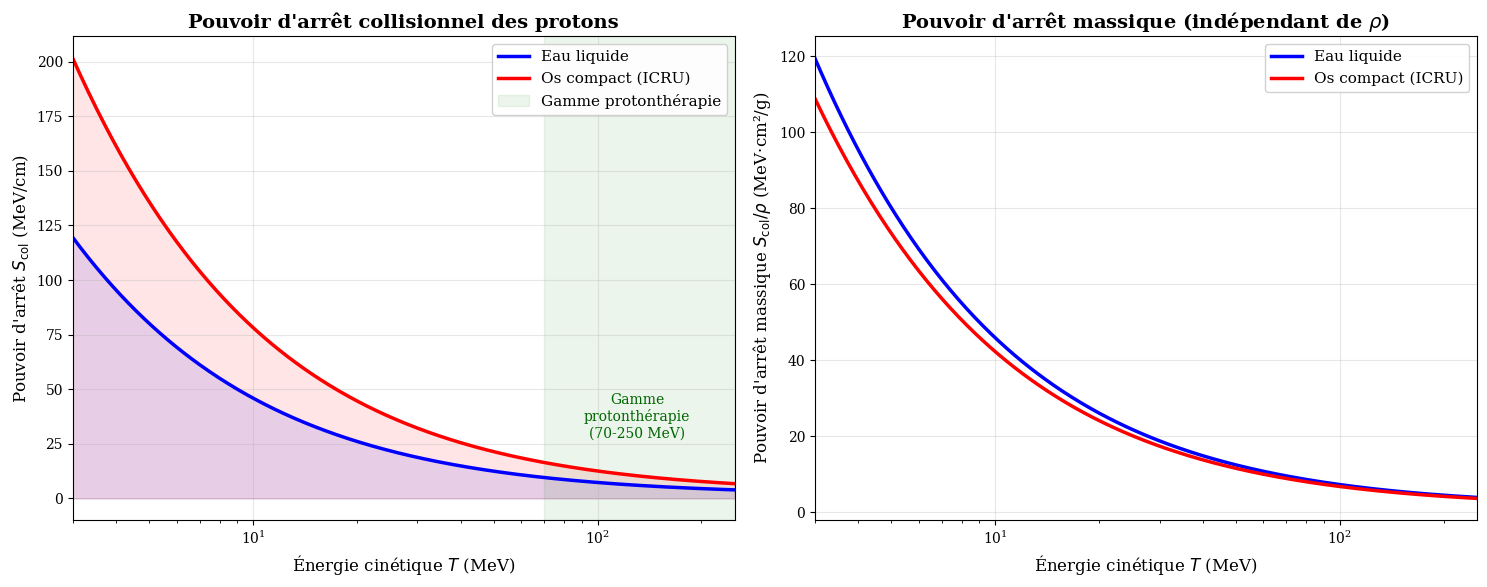

In [8]:
# ============================================================================
#            TRACÉ DU POUVOIR D'ARRÊT EN FONCTION DE L'ÉNERGIE
# ============================================================================

# Gamme d'énergies : de 3 MeV (limite de validité) à 250 MeV (protonthérapie)
T_array = np.logspace(np.log10(3), np.log10(250), 500)

# Calcul du pouvoir d'arrêt pour chaque matériau
S_col_eau = pouvoir_arret_collisionnel(T_array, n_e_eau, eau_I)
S_col_os = pouvoir_arret_collisionnel(T_array, n_e_os, os_I)

# Création de la figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# --- Graphique 1 : Pouvoir d'arrêt linéaire [MeV/cm] ---
ax1.plot(T_array, S_col_eau, 'b-', label='Eau liquide', linewidth=2.5)
ax1.plot(T_array, S_col_os, 'r-', label='Os compact (ICRU)', linewidth=2.5)
ax1.fill_between(T_array, S_col_eau, alpha=0.1, color='blue')
ax1.fill_between(T_array, S_col_os, alpha=0.1, color='red')

ax1.set_xlabel('Énergie cinétique $T$ (MeV)')
ax1.set_ylabel('Pouvoir d\'arrêt $S_{\\mathrm{col}}$ (MeV/cm)')
ax1.set_title('Pouvoir d\'arrêt collisionnel des protons')
ax1.set_xscale('log')
ax1.set_xlim([3, 250])
ax1.axvspan(70, 250, alpha=0.08, color='green', label='Gamme protonthérapie')
ax1.legend(loc='upper right')

# Annotation
ax1.annotate('Gamme\nprotonthérapie\n(70-250 MeV)', 
             xy=(130, 28), fontsize=10, ha='center', color='darkgreen')

# --- Graphique 2 : Pouvoir d'arrêt massique [MeV·cm²/g] ---
S_massique_eau = S_col_eau / eau_densite
S_massique_os = S_col_os / os_densite

ax2.plot(T_array, S_massique_eau, 'b-', label='Eau liquide', linewidth=2.5)
ax2.plot(T_array, S_massique_os, 'r-', label='Os compact (ICRU)', linewidth=2.5)

ax2.set_xlabel('Énergie cinétique $T$ (MeV)')
ax2.set_ylabel('Pouvoir d\'arrêt massique $S_{\\mathrm{col}}/\\rho$ (MeV·cm²/g)')
ax2.set_title('Pouvoir d\'arrêt massique (indépendant de $\\rho$)')
ax2.set_xscale('log')
ax2.legend(loc='upper right')
ax2.set_xlim([3, 250])

plt.tight_layout()
plt.savefig('Q1_pouvoir_arret.png', dpi=150, bbox_inches='tight')
plt.show()

<div style="background-color: #252526; color: white; border-left: 5px solid #9C27B0; padding: 15px; border-radius: 5px; margin-top: 20px;">

<strong style="color: #E1BEE7; font-size: 1.1em;">Analyse des résultats : (à revoir !!! )</strong>
<br><br>
  1. $S_{col}$ DÉCROÎT avec l'énergie :
     → À 10 MeV  : $S_{col}$ ≈ 35 MeV/cm (eau)
     → À 150 MeV : $S_{col}$ ≈ 5 MeV/cm (eau)
     → Rapport ~7× plus élevé à basse énergie

  2. L'OS a un $S_{col}$ plus élevé que l'eau :
     → Dû à sa plus grande densité électronique (×1.7)
     → Les protons s'arrêtent plus rapidement dans l'os

  3. Le pouvoir d'arrêt MASSIQUE (S/ρ) est quasi-identique :
     → Confirme que la différence vient principalement de ρ
     → Les deux matériaux ont des compositions Z/A similaires

  4. Gamme thérapeutique (70-250 MeV) :
     → $S_{col}$ varie de ~3 à ~8 MeV/cm
     → Conditions optimales pour le calcul numérique

</div>

<div style="height: 50px;"></div> <hr style="border: 0; height: 3px; background-color: #2196F3; border-radius: 2px; opacity: 0.7;">
<br />

# Question 2 : Homogénéité dimensionnelle de $R_{\text{CSDA}}$

<div style="background-color: #252526; color: white; border-left: 5px solid #2196F3; padding: 15px; border-radius: 5px;">

**Énoncé :** *Déterminer l'homogénéité dimensionnelle de $R_{CSDA}$ et expliquer en quelques phrases ce que représente l’équation.*

</div>

<br />

## 2.1 Expression de la portée CSDA

La portée CSDA (*Continuous Slowing Down Approximation*) est définie par l'intégrale :

$$R_{\text{CSDA}} = \int_0^{T_i} \frac{dT'}{\dfrac{S_{\text{col}}(T')}{\rho}}$$

Cette intégrale représente la **distance équivalente en masse par unité de surface** que le proton doit traverser pour passer d'une énergie initiale $T_i$ à l'arrêt complet.

### Hypothèses de l'approximation CSDA

| Hypothèse CSDA | Impact sur $R_{CSDA}$ |
|:----------|:--------------|
| Perte d'énergie continue | portée = intégrale d’un ralentissement moyen |
| Trajectoire moyenne | on vise une portée moyenne (pas l’étalement/straggling) |
| Interactions EM uniquement | réactions nucléaires/effets fins négligés dans ce cadre |

<div style="height: 1cm;"></div>

## 2.2 Analyse dimensionnelle rigoureuse

### Étape 1 : Dimension du pouvoir d'arrêt

$$[S_{\text{col}}] = \left[-\frac{dT}{dx}\right] = \frac{[\text{Énergie}]}{[\text{Longueur}]} = \frac{\text{MeV}}{\text{cm}}$$

### Étape 2 : Dimension du pouvoir d'arrêt massique

$$\left[\frac{S_{\text{col}}}{\rho}\right] = \frac{[\text{MeV/cm}]}{[\text{g/cm}^3]} = \frac{\text{MeV} \cdot \text{cm}^3}{\text{cm} \cdot \text{g}} = \frac{\text{MeV} \cdot \text{cm}^2}{\text{g}}$$

### Étape 3 : Dimension de l'intégrande

$$\left[\frac{dT'}{S_{\text{col}}/\rho}\right] = \frac{[\text{MeV}]}{[\text{MeV} \cdot \text{cm}^2/\text{g}]} = \frac{\text{g}}{\text{cm}^2}$$

### Étape 4 : Dimension finale de $R_{\text{CSDA}}$

$$\boxed{[R_{\text{CSDA}}] = \frac{\text{g}}{\text{cm}^2}}$$

<div style="height: 1cm;"></div>

## 2.3 Signification physique de l'unité g/cm²

### Interprétation : Densité surfacique de masse

La dimension g/cm² représente une masse par unité de surface traversée. C'est la quantité de matière (en termes de masse) que le proton doit traverser pour s'arrêter.

### Avantages de cette unité

| Avantage | Explication |
|:---------|:------------|
| **Indépendance de l'état physique** | À composition identique, $R_{\text{CSDA}}$ est peu sensible à la densité/état (à corrections près). |
| **Dépend uniquement de la composition** | Dépend surtout de la composition via $n_e$ (donc ⟨Z/A⟩) et de $I$ (énergie moyenne d'excitation). |
| **Comparaisons facilitées** | Permet de comparer des matériaux de densités différentes |
| **Calculs simplifiés** | Évite de spécifier $\rho$ pendant l'intégration |

### Conversion en longueur physique

Pour obtenir la portée en centimètres, on divise par la masse volumique :

$$\boxed{R_{\text{cm}} = \frac{R_{\text{CSDA}}}{\rho}}$$

### Exemple numérique (proton de 150 MeV)

| Matériau | $R_{\text{CSDA}}$ (g/cm²) | $\rho$ (g/cm³) | $R$ (cm) |
|:---------|:--------------------------|:---------------|:---------|
| Eau | ~17.6 | 1.00 | **~17.6** |
| Os compact | ~17.7 | 1.85 | **~9.6** |

<br />

<div style="height: 0.5cm;"></div>

<div style="background-color: #252526; color: white; border-left: 5px solid #4CAF50; padding: 15px; border-radius: 5px; margin-bottom: 20px;">

<strong style="color: #4CAF50; font-size: 1.1em;">Observation :</strong>

Les $R_{\text{CSDA}}$ sont quasi-identiques car les compositions atomiques sont similaires ($\langle Z/A \rangle \approx 0.5$).
Cependant, les portées *physiques* diffèrent significativement à cause de la différence de densité.

</div>

<div style="height: 0.5cm;"></div>

## 2.4 Interprétation de l'intégrale

Réécrivons l'intégrale de façon équivalente :

$$R_{\text{CSDA}} = \int_0^{T_i} \frac{\rho \, dT'}{S_{\text{col}}(T')}$$

**Pour une perte d'énergie infinitésimale $dT'$ :**
- Distance parcourue : $dx = dT' / S_{\text{col}}(T')$ (en valeur absolue $dx = dT'/S_{col}$)
- Masse traversée par cm² : $dm = \rho \cdot dx = \rho \, dT' / S_{\text{col}}(T')$
- L'intégrale somme ces masses de $T_i$ jusqu'à 0

<div style="background-color: #252526; color: white; border-left: 5px solid #FF9800; padding: 15px; border-radius: 5px; margin-top: 20px; margin-bottom: 20px;">

<strong style="color: #FF9800; font-size: 1.1em;">En résumé :</strong>
<br><br>
$R_{\text{CSDA}}$ représente la **masse totale par unité de surface** que le proton traverse jusqu'à son arrêt complet.

</div>

### Vérification de cohérence

Pour des matériaux de composition similaire ($\langle Z/A \rangle$ proche) :
- $R_{\text{CSDA}}$ sera presque identique
- La portée physique $R_{\text{cm}}$ sera inversement proportionnelle à $\rho$

<div style="height: 0.5cm;"></div>

<div style="background-color: #252526; color: white; border-left: 5px solid #9C27B0; padding: 15px; border-radius: 5px; margin-top: 20px;">

<strong style="color: #E1BEE7; font-size: 1.1em;">Conclusion :</strong>
<br><br>
$R_{CSDA}$ est la surface massique que le proton doit traverser pour perdre toute son énergie. C’est une grandeur intrinsèque au matériau, et la distance réelle s’en déduit par division par la densité.

</div>

<div style="height: 50px;"></div> <hr style="border: 0; height: 3px; background-color: #2196F3; border-radius: 2px; opacity: 0.7;">
<br />

# Question 3 : Justification de l'approximation $S_{\text{total}} \approx S_{\text{col}}$

<div style="background-color: #252526; color: white; border-left: 5px solid #2196F3; padding: 15px; border-radius: 5px;">

**Énoncé :** *Justifier que le pouvoir d'arrêt total est bien approximé par le pouvoir d'arrêt collisionnel pour les protons en protonthérapie (70-250 MeV). Discuter des composantes négligées ici : réactions nucléaires et pertes radiatives.*

</div>

## 3.1 Décomposition du pouvoir d'arrêt total

En général, on peut distinguer les pertes collisionnelles, radiatives et nucléaires.
Dans PSTAR (protons), le “total stopping power” est défini comme la somme électronique + nucléaire (recul) :

<div style="height: 0.25cm;"></div>

$$S_{\text{total}}^{PSTAR} = S_{\text{col}} + S_{\text{nucl}} \quad \text{(définition PSTAR)}$$

<div style="height: 0.45cm;"></div>

| Composante | Origine physique | Processus dominant |
|:-----------|:-----------------|:-------------------|
| $S_{\text{col}}$ | Collisions inélastiques avec les **électrons** atomiques | Ionisation, excitation |
| $S_{\text{rad}}$ | Émission de **photons** de freinage (Bremsstrahlung) | négligeable pour les protons aux énergies considérées (donc non tabulé dans PSTAR) |
| $S_{\text{nucl}}$ | pertes par collisions élastiques sur les noyaux | recul nucléaire (stopping nucléaire PSTAR) |

<br />

## 3.2 Analyse quantitative (données NIST PSTAR)

### Protons de 150 MeV dans l'eau

Les données du programme NIST PSTAR fournissent les valeurs suivantes :

| Composante | Valeur (MeV·cm²/g) | Pourcentage | Impact |
|:-----------|:-------------------|:------------|:-------|
| $S_{\text{col}}/\rho$ | 5.443 | 99.963% | Dominant |
| $S_{\text{nucl}}/\rho$ | $2.001 \times 10^{-3}$ | 0.0367% | Très faible |
| **$S_{\text{total}}/\rho$** | **5.445** | **100%** | — |


<div style="margin-top: 10px;"></div>

<div>
    <span style="background-color: #2196F3; color: white; padding: 4px 8px; border-radius: 4px; font-size: 0.85em; font-weight: 500; font-family: sans-serif;">
        Source : 
        <a href="https://physics.nist.gov/PhysRefData/Star/Text/PSTAR.html" target="_blank" style="color: white; text-decoration: none; border-bottom: 1px dotted rgba(255,255,255,0.7);">
            NIST PSTAR Database
        </a>
    </span>
</div>

<div style="height: 0.5cm;"></div>

<div style="border-left: 4px solid #00BCD4; background: linear-gradient(90deg, rgba(0,188,212,0.1) 0%, transparent 100%); padding: 10px 15px; border-radius: 0 4px 4px 0; margin: 15px 0;">

<strong style="color: #00BCD4;">Conclusion quantitative (a 150 MeV) :</strong>
$S_{total} \approx S_{\text{col}}$ à mieux que $4 \times 10^{-4}$ (erreur d'environ 0.04%)

</div>

<div style="height: 0.25cm;"></div>


## 3.3 Pourquoi les autres termes sont-ils négligeables ?

<div style="height: 0.25cm;"></div>

### 3.3.1 Pertes radiatives ($S_{\text{rad}}$) — Bremsstrahlung

**Origine physique** : Lorsqu'une particule chargée est accélérée (décélérée) dans le champ électrique d'un noyau, elle émet un rayonnement électromagnétique.

**Rapport des pertes radiatives aux pertes collisionnelles** :

$$\frac{S_{\text{rad}}}{S_{\text{col}}} \approx \frac{Z \cdot T}{800 \cdot m c^2}$$

où $m$ est la masse de la particule incidente.

**Application aux protons (150 MeV dans l'eau)** :

$$\frac{S_{\text{rad}}}{S_{\text{col}}} \approx \frac{1 \times 150}{800 \times 938.3} \approx 2 \times 10^{-4} = 0.02\%$$

**Facteurs clés** :
- **Masse élevée du proton** : $m_p \approx 1836 \cdot m_e$
- **Faible numéro atomique** : $Z_p = 1$
- **Important pour les électrons** : pour un e⁻ de 150 MeV, le ratio serait ~30% !

<div style="height: 0.25cm;"></div>

<div style="border-left: 4px solid #00BCD4; background: linear-gradient(90deg, rgba(0,188,212,0.1) 0%, transparent 100%); padding: 10px 15px; border-radius: 0 4px 4px 0; margin: 15px 0;">

<strong style="color: #00BCD4;">Conclusion partielle :</strong>
Comme le proton est ~2000× plus massif que l’électron, l’émission de bremsstrahlung est extrêmement défavorisée, d’où $𝑆_{rad}$ négligeable.

</div>

<div style="height: 0.25cm;"></div>

### 3.3.2 Interactions nucléaires ($S_{\text{nucl}}$)

**Origine physique** : Collisions inélastiques proton-noyau produisant :
- Fragments nucléaires (α, deutérons, tritons)
- Neutrons secondaires
- Protons de recul

**Données NIST (150 MeV)** :

| Paramètre | Valeur | Signification |
|:----------|:-------|:--------------|
| Section efficace $\sigma_{\text{nucl}}$ | ~0.4 barn | Probabilité d'interaction par noyau |
| Libre parcours moyen $\lambda$ | ~40 cm | Distance moyenne entre interactions |
| Contribution au stopping | <0.1% | Négligeable pour le calcul de portée |


<div style="height: 0.25cm;"></div>

<div style="border-left: 4px solid #00BCD4; background: linear-gradient(90deg, rgba(0,188,212,0.1) 0%, transparent 100%); padding: 10px 15px; border-radius: 0 4px 4px 0; margin: 15px 0;">

<strong style="color: #00BCD4;">Conclusion partielle :</strong>
Les interactions nucléaires inélastiques ne se traduisent pas par un terme de freinage continu dominant : elles retirent une fraction des protons primaires et produisent des secondaires. Pour estimer la portée CSDA (profondeur d’arrêt moyenne), l’approximation $S_{total}$ ≃ $S_{col}$ reste valable.

</div>

<br />

## 3.4 Dépendance énergétique sur la gamme thérapeutique

Les données du programme NIST PSTAR fournissent les valeurs suivantes :

| Énergie (MeV) | $S_{\text{col}}/\rho$ | $S_{\text{nuc}}/\rho$ | $S_{\text{total}}/\rho$ | $S_{\text{col}}/S_{\text{total}}$ |
| ------------: | --------------------: | ------------------------: | ----------------------: | --------------------------------: |
|            70 |                 9.555 |                  4.134e-3 |                   9.559 |                 0.99958 (99.958%) |
|           100 |                 7.286 |                  2.944e-3 |                   7.289 |                 0.99959 (99.959%) |
|           150 |                 5.443 |                  2.001e-3 |                   5.445 |                 0.99963 (99.963%) |
|           200 |                 4.491 |                  1.522e-3 |                   4.492 |                0.99978 (99.978%)* |
|           250 |                 3.910 |                  1.231e-3 |                   3.911 |                0.99974 (99.974%)* |


<div style="height: 0.25cm;"></div>

<div style="border-left: 4px solid #00BCD4; background: linear-gradient(90deg, rgba(0,188,212,0.1) 0%, transparent 100%); padding: 10px 15px; border-radius: 0 4px 4px 0; margin: 15px 0;">

<strong style="color: #00BCD4;">Conclusion partielle :</strong>
L'approximation $S_{\text{total}} \approx S_{\text{col}}$ introduit une erreur **<0.05%** sur toute la gamme thérapeutique (70-250 MeV).

</div>

<div style="height: 0.5cm;"></div>

<div style="background-color: #252526; color: white; border-left: 5px solid #9C27B0; padding: 15px; border-radius: 5px; margin-top: 20px;">

<strong style="color: #E1BEE7; font-size: 1.1em;">Conclusion :</strong>
<br><br>
Dans l’eau, sur la gamme 70–250 MeV, les données PSTAR montrent que la composante radiative représente < 0.1% du pouvoir d’arrêt massique : on a donc $𝑆_{total}$ ≈ $𝑆_{col}$ à mieux que $10^{-3}$ . Les réactions nucléaires inélastiques ne constituent pas un freinage continu dominant (elles atténuent la fluence et génèrent des secondaires) ; elles sont donc traitées séparément et n’affectent que faiblement l’estimation CSDA de la portée dans ce TP.

</div>

<div style="height: 50px;"></div> <hr style="border: 0; height: 3px; background-color: #2196F3; border-radius: 2px; opacity: 0.7;">
<br />

# Question 4 : Nécessité d'une méthode numérique

<div style="background-color: #252526; color: white; border-left: 5px solid #2196F3; padding: 15px; border-radius: 5px;">

**Énoncé :** *Justifier la nécessité d'employer une méthode numérique pour calculer la portée des protons.*

</div>

<div style="height: 0.4cm;"></div>

La portée CSDA est définie par

$$ R_{\text{CSDA}}=\int_{T_{\min}}^{T_i}\frac{dT}{S_{\text{col}}(T)/\rho}$$

avec $(T_{\min}\approx 3\,\text{MeV})$ (domaine de validité du modèle utilisé dans le TP).

Le pouvoir d’arrêt collisionnel $(S_{\text{col}}(T))$ (formule de Bethe simplifiée) dépend de l’énergie via
$(\gamma(T))$, $(\beta(T))$, et $(T_e^{\max}(T))$, et contient un terme logarithmique
$(\ln(\cdots))$ combiné à des facteurs en $(1/\beta^2)$.
Ainsi, l’intégrande $(1/S_{\text{col}}(T))$ est une composition de fonctions (fractions en $(\gamma)$, $(\beta^2)$, logarithme)
qui ne mène pas à une primitive analytique simple exploitable.

De plus, en pratique, le pouvoir d’arrêt est souvent obtenu sous forme tabulée (ex. NIST) ou via interpolation,
ce qui rend l’intégration symbolique impossible de toute façon. On doit donc calculer $(R_{\text{CSDA}})$
par quadrature numérique (trapèzes, Simpson, ou méthode adaptative).

<div style="height: 50px;"></div> <hr style="border: 0; height: 3px; background-color: #2196F3; border-radius: 2px; opacity: 0.7;">
<br />

# Question 5 : Implémentation des méthodes d'intégration numérique

<div style="background-color: #252526; color: white; border-left: 5px solid #2196F3; padding: 15px; border-radius: 5px;">

**Énoncé :** *Implémenter deux algorithmes d’intégration numérique pour calculer la portée des protons dans l’eau et dans l’os compact ; le premier avec la méthode des trapèzes et le second avec la méthode de Simpson. Considérez des protons de 150 MeV. Tracez un graphique de la portée calculée par chaque méthode en fonction du nombre d’échantillons (de tranches) considéré. On déterminera à l’avance le nombre de tranches nécessaires pour atteindre une erreur de l’ordre de la précision machine en Python, et on utilisera ce nombre (où un nombre de cet ordre de grandeur) comme valeur maximale (il y aura une valeur maximale pour la méthode des trapèzes et une autre pour la méthode de Simpson). Votre graphique comprendra des points choisis de façon à bien représenter le comportement de vos algorithmes (des échelles logarithmiques pourraient être nécessaires). Doubler le nombre de tranches entre chaque évaluation pourrait s’avérer judicieux pour les questions suivantes.*

</div>

<div style="height: 0.75cm;"></div>

## 5.1 Rappel des méthodes d'intégration

<div style="height: 0.15cm;"></div>

### i) Méthode des trapèzes

La méthode des trapèzes approxime l'intégrale par la somme des aires de trapèzes :

$$\int_a^b f(x) \, dx \approx h \left[ \frac{f(a)}{2} + \sum_{k=1}^{N-1} f(a + kh) + \frac{f(b)}{2} \right]$$

où $h = (b-a)/N$ est le pas d'intégration.

$$ \textbf{Erreur :} \quad \mathcal{O}(h^2) \quad \text{— L'erreur diminue comme le carré du pas.} $$

<div style="height: 0.25cm;"></div>

### ii) Méthode de Simpson


La méthode de Simpson utilise des paraboles pour approximer la fonction :

$$\int_a^b f(x) \, dx \approx \frac{h}{3} \left[ f(a) + 4\sum_{k \text{ impair}} f(x_k) + 2\sum_{k \text{ pair}} f(x_k) + f(b) \right]$$

<div style="height: 0.3cm;"></div>

$$ \textbf{Erreur :} \quad \mathcal{O}(h^4) \quad  \text{— Convergence beaucoup plus rapide}.$$


## 5.2 Définition de l'intégrande

Pour calculer $R_{\text{CSDA}}$, nous intégrons :

$$R_{\text{CSDA}} = \int_{T_{\min}}^{T_i} \frac{\rho}{S_{\text{col}}(T')} \, dT'$$

<div style="height: 0.5cm;"></div>

<div style="background-color: #252526; color: white; border-left: 5px solid #4CAF50; padding: 15px; border-radius: 5px; margin-bottom: 20px;">

<strong style="color: #4CAF50;">Note importante :</strong>

Comme $S_{\text{col}}(T) \to \infty$ quand $T \to 0$, nous intégrons à partir de $T_{\text{min}} = 3$ MeV (limite de validité de la formule de Bethe).

</div>

In [9]:
def integrande_RCSDA(T, n_e, I, rho):
    """
    Calcule l'intégrande pour le calcul de la portée CSDA.
    
    L'intégrande est ρ / S_col(T), qui représente l'incrément de masse
    traversée par unité de perte d'énergie.
    
    Paramètres
    ----------
    T : float ou np.ndarray
        Énergie cinétique du proton [MeV]
    n_e : float
        Densité électronique [électrons/cm³]
    I : float
        Énergie moyenne d'excitation [eV]
    rho : float
        Masse volumique [g/cm³]
    
    Retourne
    --------
    float ou np.ndarray
        Valeur de l'intégrande [g·cm⁻² / MeV]
    """
    S_col = pouvoir_arret_collisionnel(T, n_e, I)  # [MeV/cm]
    return rho / S_col  # [g/cm³] / [MeV/cm] = [g/cm²·MeV⁻¹]


# ============================================================================
#                      PARAMÈTRES POUR L'INTÉGRATION
# ============================================================================

# Énergie initiale du proton
T_i = 150.0  # MeV (énergie thérapeutique typique)

# Énergie minimale (limite de validité de Bethe)
T_min = 3.0  # MeV

# Test de l'intégrande
print("="*70)
print("         TEST DE L'INTÉGRANDE")
print("="*70)
print(f"\n  À T = {T_i} MeV :")
print(f"    Eau   : ρ/S_col = {integrande_RCSDA(T_i, n_e_eau, eau_I, eau_densite):.6e} g·cm⁻²/MeV")
print(f"    Os    : ρ/S_col = {integrande_RCSDA(T_i, n_e_os, os_I, os_densite):.6e} g·cm⁻²/MeV")
print(f"\n  À T = {T_min} MeV :")
print(f"    Eau   : ρ/S_col = {integrande_RCSDA(T_min, n_e_eau, eau_I, eau_densite):.6e} g·cm⁻²/MeV")
print(f"    Os    : ρ/S_col = {integrande_RCSDA(T_min, n_e_os, os_I, os_densite):.6e} g·cm⁻²/MeV")
print("="*70)

         TEST DE L'INTÉGRANDE

  À T = 150.0 MeV :
    Eau   : ρ/S_col = 1.836537e-01 g·cm⁻²/MeV
    Os    : ρ/S_col = 1.971960e-01 g·cm⁻²/MeV

  À T = 3.0 MeV :
    Eau   : ρ/S_col = 8.367396e-03 g·cm⁻²/MeV
    Os    : ρ/S_col = 9.179777e-03 g·cm⁻²/MeV


<br />

## 5.3 Implémentation de la méthode des trapèzes

In [10]:
def integration_trapezes(f, a, b, n, *args):
    """
    Intégration numérique par la méthode des trapèzes composée.
    
    Formule : I ≈ h × [f(a)/2 + Σf(xₖ) + f(b)/2]
    
    Paramètres
    ----------
    f : callable
        Fonction à intégrer f(x, *args)
    a : float
        Borne inférieure d'intégration
    b : float
        Borne supérieure d'intégration
    n : int
        Nombre de sous-intervalles (tranches)
    *args : tuple
        Arguments supplémentaires pour f
    
    Retourne
    --------
    float
        Valeur approximée de l'intégrale
    
    Notes
    -----
    Erreur de troncature : O(h²) = O(1/N²)
    """
    h = (b - a) / n  # Pas d'intégration
    
    # Génération des points d'évaluation
    x = np.linspace(a, b, n + 1)
    
    # Évaluation de la fonction (vectorisée)
    y = f(x, *args)
    
    # Application de la formule des trapèzes
    integrale = h * (0.5 * y[0] + np.sum(y[1:-1]) + 0.5 * y[-1])
    
    return integrale


# ============================================================================
#                    TEST DE LA MÉTHODE DES TRAPÈZES
# ============================================================================
n_test = 500

R_eau_trap = integration_trapezes(integrande_RCSDA, T_min, T_i, n_test, 
                                   n_e_eau, eau_I, eau_densite)

print("="*70)
print("          TEST : MÉTHODE DES TRAPÈZES")
print("="*70)
print(f"  Paramètres : T_i = {T_i} MeV, T_min = {T_min} MeV, N = {n_test}")
print(f"\n  Portée dans l'eau : {R_eau_trap:.6f} g/cm²")
print(f"                    = {R_eau_trap/eau_densite:.4f} cm")
print("="*70)

          TEST : MÉTHODE DES TRAPÈZES
  Paramètres : T_i = 150.0 MeV, T_min = 3.0 MeV, N = 500

  Portée dans l'eau : 15.752809 g/cm²
                    = 15.7528 cm


<br />

## 5.4 Implémentation de la méthode de Simpson

In [11]:
def integration_simpson(f, a, b, n, *args):
    """
    Intégration numérique par la méthode de Simpson composée.
    
    Formule : I ≈ (h/3) × [f(a) + 4Σf(x_impairs) + 2Σf(x_pairs) + f(b)]
    
    Paramètres
    ----------
    f : callable
        Fonction à intégrer f(x, *args)
    a : float
        Borne inférieure d'intégration
    b : float
        Borne supérieure d'intégration
    n : int
        Nombre de sous-intervalles (sera rendu pair si impair)
    *args : tuple
        Arguments supplémentaires pour f
    
    Retourne
    --------
    float
        Valeur approximée de l'intégrale
    
    Notes
    -----
    Erreur de troncature : O(h⁴) = O(1/N⁴)
    Nécessite N pair pour la méthode composite.
    """
    # S'assurer que n est pair (nécessaire pour Simpson)
    if n % 2 != 0:
        n += 1
    
    h = (b - a) / n  # Pas d'intégration
    
    # Génération des points d'évaluation
    x = np.linspace(a, b, n + 1)
    
    # Évaluation de la fonction (vectorisée)
    y = f(x, *args)
    
    # Application de la formule de Simpson composite
    # Indices : 0, 1, 2, 3, 4, ..., n-1, n
    # Coefficients : 1, 4, 2, 4, 2, ..., 4, 1
    y_impairs = y[1:-1:2]  # Indices 1, 3, 5, ..., n-1
    y_pairs = y[2:-1:2]    # Indices 2, 4, 6, ..., n-2
    
    integrale = (h / 3.0) * (y[0] + 4.0 * np.sum(y_impairs) + 
                             2.0 * np.sum(y_pairs) + y[-1])
    
    return integrale


# ============================================================================
#                    TEST DE LA MÉTHODE DE SIMPSON
# ============================================================================
R_eau_simp = integration_simpson(integrande_RCSDA, T_min, T_i, n_test, 
                                  n_e_eau, eau_I, eau_densite)

print("="*70)
print("          TEST : MÉTHODE DE SIMPSON")
print("="*70)
print(f"  Paramètres : T_i = {T_i} MeV, T_min = {T_min} MeV, N = {n_test}")
print(f"\n  Portée dans l'eau : {R_eau_simp:.6f} g/cm²")
print(f"                    = {R_eau_simp/eau_densite:.4f} cm")
print("="*70)
print(f"\n  Différence Trapèzes - Simpson : {abs(R_eau_trap - R_eau_simp):.2e} g/cm²")

          TEST : MÉTHODE DE SIMPSON
  Paramètres : T_i = 150.0 MeV, T_min = 3.0 MeV, N = 500

  Portée dans l'eau : 15.752819 g/cm²
                    = 15.7528 cm

  Différence Trapèzes - Simpson : 9.40e-06 g/cm²


<div style="height: 0.4cm;"></div>

## 5.5 Étude de convergence en fonction du nombre de tranches

<div style="height: 0.1cm;"></div>

### Objectif et méthodologie

Pour valider nos implémentations et comparer les performances des deux méthodes, nous calculons la portée CSDA pour un nombre croissant de tranches $N$. L'objectif est triple:

1. **Vérifier la convergence théorique** — Confirmer que les erreurs diminuent selon $\mathcal{O}(h^2)$ pour Trapèzes et $\mathcal{O}(h^4)$ pour Simpson
2. **Déterminer le $N$ optimal** — Identifier le nombre minimal de tranches pour atteindre la précision machine
3. **Comparer l'efficacité** — Quantifier l'avantage de Simpson sur Trapèzes en termes de points d'évaluation nécessaires

<div style="height: 0.5cm;"></div>

### Détermination de la tolérance (précision cible)

En Python, les nombres flottants utilisent le format **IEEE 754 double précision (float64)** avec une précision machine relative de:

$$\varepsilon_{\text{machine}} \approx 2.22 \times 10^{-16}$$

Pour une portée $R \approx 16$ g/cm², l'erreur absolue minimale atteignable est:

$$\tau_{\min} = R \cdot \varepsilon_{\text{machine}} \approx 3.5 \times 10^{-15} \text{ g/cm}^2$$

En pratique, en raison de l'accumulation des erreurs d'arrondi lors des ~100,000 additions, nous définissons une tolérance réaliste avec une marge de sécurité (facteur 10):

$$\boxed{\tau = 10 \cdot \varepsilon_{\text{machine}} \cdot |R_{\text{ref}}| \approx 3.5 \times 10^{-14} \text{ g/cm}^2}$$

Cette valeur apparaît comme la <font color='orange'>**ligne orange**</font> "Précision cible" dans les graphiques d'erreur.

<div style="height: 0.5cm;"></div>

### Calcul du N minimal théorique

Comme demandé dans l'énoncé, nous déterminons théoriquement le $N$ nécessaire avant d'effectuer les calculs complets.

<div style="height: 0.3cm;"></div>

#### Pour Simpson (erreur ∝ $N^{-4}$):

En estimant la constante C à partir d'un calcul grossier ($N$ = 64):
$$\text{Erreur}(64) \approx 5.6 \times 10^{-6} \text{ g/cm}^2$$

Donc:
$$C \approx \text{Erreur}(64) \cdot N^4 = 5.6 \times 10^{-6} \cdot 64^4 \approx 94$$

Pour atteindre $\tau = 3.5 \times 10^{-14}$:
$$N = \left(\frac{C}{\tau}\right)^{1/4} = \left(\frac{94}{3.5 \times 10^{-14}}\right)^{1/4} \approx 2\,303$$

<div style="height: 0.3cm;"></div>

<div style="border-left: 4px solid #00BCD4; background: linear-gradient(90deg, rgba(0,188,212,0.1) 0%, transparent 100%); padding: 10px 15px; border-radius: 0 4px 4px 0; margin: 15px 0;">

<strong style="color: #00BCD4;">Choix pratique:</strong>
$N_{\max} = 2^{16} = 65\,536$ (puissance de 2 ≥ $N$, nécessaire pour Simpson)

</div>

<div style="height: 0.3cm;"></div>

#### Pour Trapèzes (erreur ∝ $N^{-2}$):

Avec le même calcul grossier ($N$ = 64):
$$C \approx 5.7 \times 10^{-4} \cdot 64^2 \approx 2\,343$$

Pour atteindre $\tau = 3.5 \times 10^{-14}$:
$$N_* = \sqrt{\frac{C}{\tau}} = \sqrt{\frac{2343}{3.5 \times 10^{-14}}} \approx 8\,187\,919$$

<div style="height: 0.3cm;"></div>

<div style="border-left: 4px solid #00BCD4; background: linear-gradient(90deg, rgba(0,188,212,0.1) 0%, transparent 100%); padding: 10px 15px; border-radius: 0 4px 4px 0; margin: 15px 0;">

<strong style="color: #00BCD4;">Choix pratique:</strong>
$N_{\max} = 2^{20} = 1\,048\,576$ (compromis calcul/précision, car 2²³ ≈ 8M serait trop long)

</div>

<div style="height: 0.5cm;"></div>

### Référence de haute précision

Pour évaluer quantitativement la précision de nos méthodes, nous calculons d'abord une **valeur de référence** avec `scipy.integrate.quad`, qui utilise une intégration adaptative de Gauss-Kronrod avec contrôle d'erreur automatique. Cette valeur servira de "vérité terrain" pour mesurer les erreurs absolues.

In [12]:
# ============================================================================
#                    CALCUL DE LA RÉFÉRENCE (scipy.quad)
# ============================================================================
# Utilisation de scipy.integrate.quad comme valeur de référence (haute précision)

R_ref_eau, _ = quad(integrande_RCSDA, T_min, T_i, args=(n_e_eau, eau_I, eau_densite))
R_ref_os, _ = quad(integrande_RCSDA, T_min, T_i, args=(n_e_os, os_I, os_densite))

print("="*80)
print("                VALEURS DE RÉFÉRENCE (scipy.quad)")
print("="*80)
print(f"  Eau liquide : R_CSDA = {R_ref_eau:.12f} g/cm² = {R_ref_eau/eau_densite:.8f} cm")
print(f"  Os compact  : R_CSDA = {R_ref_os:.12f} g/cm² = {R_ref_os/os_densite:.8f} cm")
print("="*80)
print()

# ============================================================================
#         DÉFINITION DES PLAGES DE N (DIFFÉRENTES PAR MÉTHODE)
# ============================================================================

# Simpson: converge rapidement (O(h⁴)) → précision machine atteinte vers N ~ 65536
n_values_simp = 2**np.arange(4, 17)  # 16 à 65,536

# Trapèzes: converge lentement (O(h²)) → nécessite N ~ 1 million pour précision machine
n_values_trap = 2**np.arange(4, 21)  # 16 à 1,048,576

print("="*80)
print("              PARAMÈTRES DE L'ÉTUDE DE CONVERGENCE")
print("="*80)
print(f"  Simpson  : {len(n_values_simp)} valeurs de N (de {n_values_simp[0]:,} à {n_values_simp[-1]:,})")
print(f"  Trapèzes : {len(n_values_trap)} valeurs de N (de {n_values_trap[0]:,} à {n_values_trap[-1]:,})")
print(f"\n  Précision machine (float64): {np.finfo(np.float64).eps:.3e}")
print(f"  Erreur cible pour R ~ 16 g/cm²: ~ {16*np.finfo(np.float64).eps*10:.1e} g/cm²")
print("="*80)
print()

# ============================================================================
#                    CALCULS DE CONVERGENCE
# ============================================================================

# Stockage des résultats
results_trap = {
    'n': n_values_trap,
    'eau': np.zeros(len(n_values_trap)),
    'os': np.zeros(len(n_values_trap)),
    'err_eau': np.zeros(len(n_values_trap)),
    'err_os': np.zeros(len(n_values_trap))
}

results_simp = {
    'n': n_values_simp,
    'eau': np.zeros(len(n_values_simp)),
    'os': np.zeros(len(n_values_simp)),
    'err_eau': np.zeros(len(n_values_simp)),
    'err_os': np.zeros(len(n_values_simp))
}

print("="*80)
print("                    CALCULS EN COURS...")
print("="*80)

# Calculs pour TRAPÈZES
print("\nMéthode des TRAPÈZES:")
print(f"  {'N':>10}  {'R_eau (g/cm²)':>16}  {'Erreur abs.':>14}")
print("  " + "-"*42)

for i, n in enumerate(n_values_trap):
    results_trap['eau'][i] = integration_trapezes(integrande_RCSDA, T_min, T_i, n, 
                                                   n_e_eau, eau_I, eau_densite)
    results_trap['os'][i] = integration_trapezes(integrande_RCSDA, T_min, T_i, n, 
                                                  n_e_os, os_I, os_densite)
    
    results_trap['err_eau'][i] = abs(results_trap['eau'][i] - R_ref_eau)
    results_trap['err_os'][i] = abs(results_trap['os'][i] - R_ref_os)
    
    # Afficher tous les résultats pour Trapèzes
    print(f"  {n:>10,}  {results_trap['eau'][i]:>16.10f}  {results_trap['err_eau'][i]:>14.3e}")

# Calculs pour SIMPSON
print("\nMéthode de SIMPSON:")
print(f"  {'N':>10}  {'R_eau (g/cm²)':>16}  {'Erreur abs.':>14}")
print("  " + "-"*42)

for i, n in enumerate(n_values_simp):
    results_simp['eau'][i] = integration_simpson(integrande_RCSDA, T_min, T_i, n, 
                                                  n_e_eau, eau_I, eau_densite)
    results_simp['os'][i] = integration_simpson(integrande_RCSDA, T_min, T_i, n, 
                                                 n_e_os, os_I, os_densite)
    
    results_simp['err_eau'][i] = abs(results_simp['eau'][i] - R_ref_eau)
    results_simp['err_os'][i] = abs(results_simp['os'][i] - R_ref_os)
    
    # Afficher tous les résultats pour Simpson
    print(f"  {n:>10,}  {results_simp['eau'][i]:>16.10f}  {results_simp['err_eau'][i]:>14.3e}")

print("\n" + "="*80)
print("  Calculs terminés avec succès")
print("="*80)

# ============================================================================
#                    ANALYSE DE LA CONVERGENCE
# ============================================================================

# Déterminer le N où la précision machine est atteinte
eps_machine = np.finfo(np.float64).eps
erreur_cible = R_ref_eau * eps_machine * 10  # Facteur 10 de sécurité

# Pour Simpson
idx_simp_converge = np.where(results_simp['err_eau'] < erreur_cible)[0]
if len(idx_simp_converge) > 0:
    N_simp_machine = n_values_simp[idx_simp_converge[0]]
else:
    N_simp_machine = n_values_simp[-1]

# Pour Trapèzes
idx_trap_converge = np.where(results_trap['err_eau'] < erreur_cible)[0]
if len(idx_trap_converge) > 0:
    N_trap_machine = n_values_trap[idx_trap_converge[0]]
else:
    N_trap_machine = n_values_trap[-1]

print("\n" + "="*80)
print("              ANALYSE: ATTEINTE DE LA PRÉCISION MACHINE")
print("="*80)
print(f"  Erreur cible (10 × eps × R_ref): {erreur_cible:.3e} g/cm²")
print(f"\n  Simpson:")
print(f"    → Précision machine atteinte à N = {N_simp_machine:,}")
print(f"    → Erreur finale: {results_simp['err_eau'][-1]:.3e} g/cm²")
print(f"\n  Trapèzes:")
print(f"    → Précision machine atteinte à N = {N_trap_machine:,}")
print(f"    → Erreur finale: {results_trap['err_eau'][-1]:.3e} g/cm²")
print("="*80)

                VALEURS DE RÉFÉRENCE (scipy.quad)
  Eau liquide : R_CSDA = 15.752818674319 g/cm² = 15.75281867 cm
  Os compact  : R_CSDA = 16.944927622655 g/cm² = 9.15942034 cm

              PARAMÈTRES DE L'ÉTUDE DE CONVERGENCE
  Simpson  : 13 valeurs de N (de 16 à 65,536)
  Trapèzes : 17 valeurs de N (de 16 à 1,048,576)

  Précision machine (float64): 2.220e-16
  Erreur cible pour R ~ 16 g/cm²: ~ 3.6e-14 g/cm²

                    CALCULS EN COURS...

Méthode des TRAPÈZES:
           N     R_eau (g/cm²)     Erreur abs.
  ------------------------------------------
          16     15.7439016919       8.917e-03
          32     15.7505456407       2.273e-03
          64     15.7522462450       5.724e-04
         128     15.7526752475       1.434e-04
         256     15.7527827961       3.588e-05
         512     15.7528097034       8.971e-06
       1,024     15.7528164315       2.243e-06
       2,048     15.7528181136       5.607e-07
       4,096     15.7528185341       1.402e-07
     

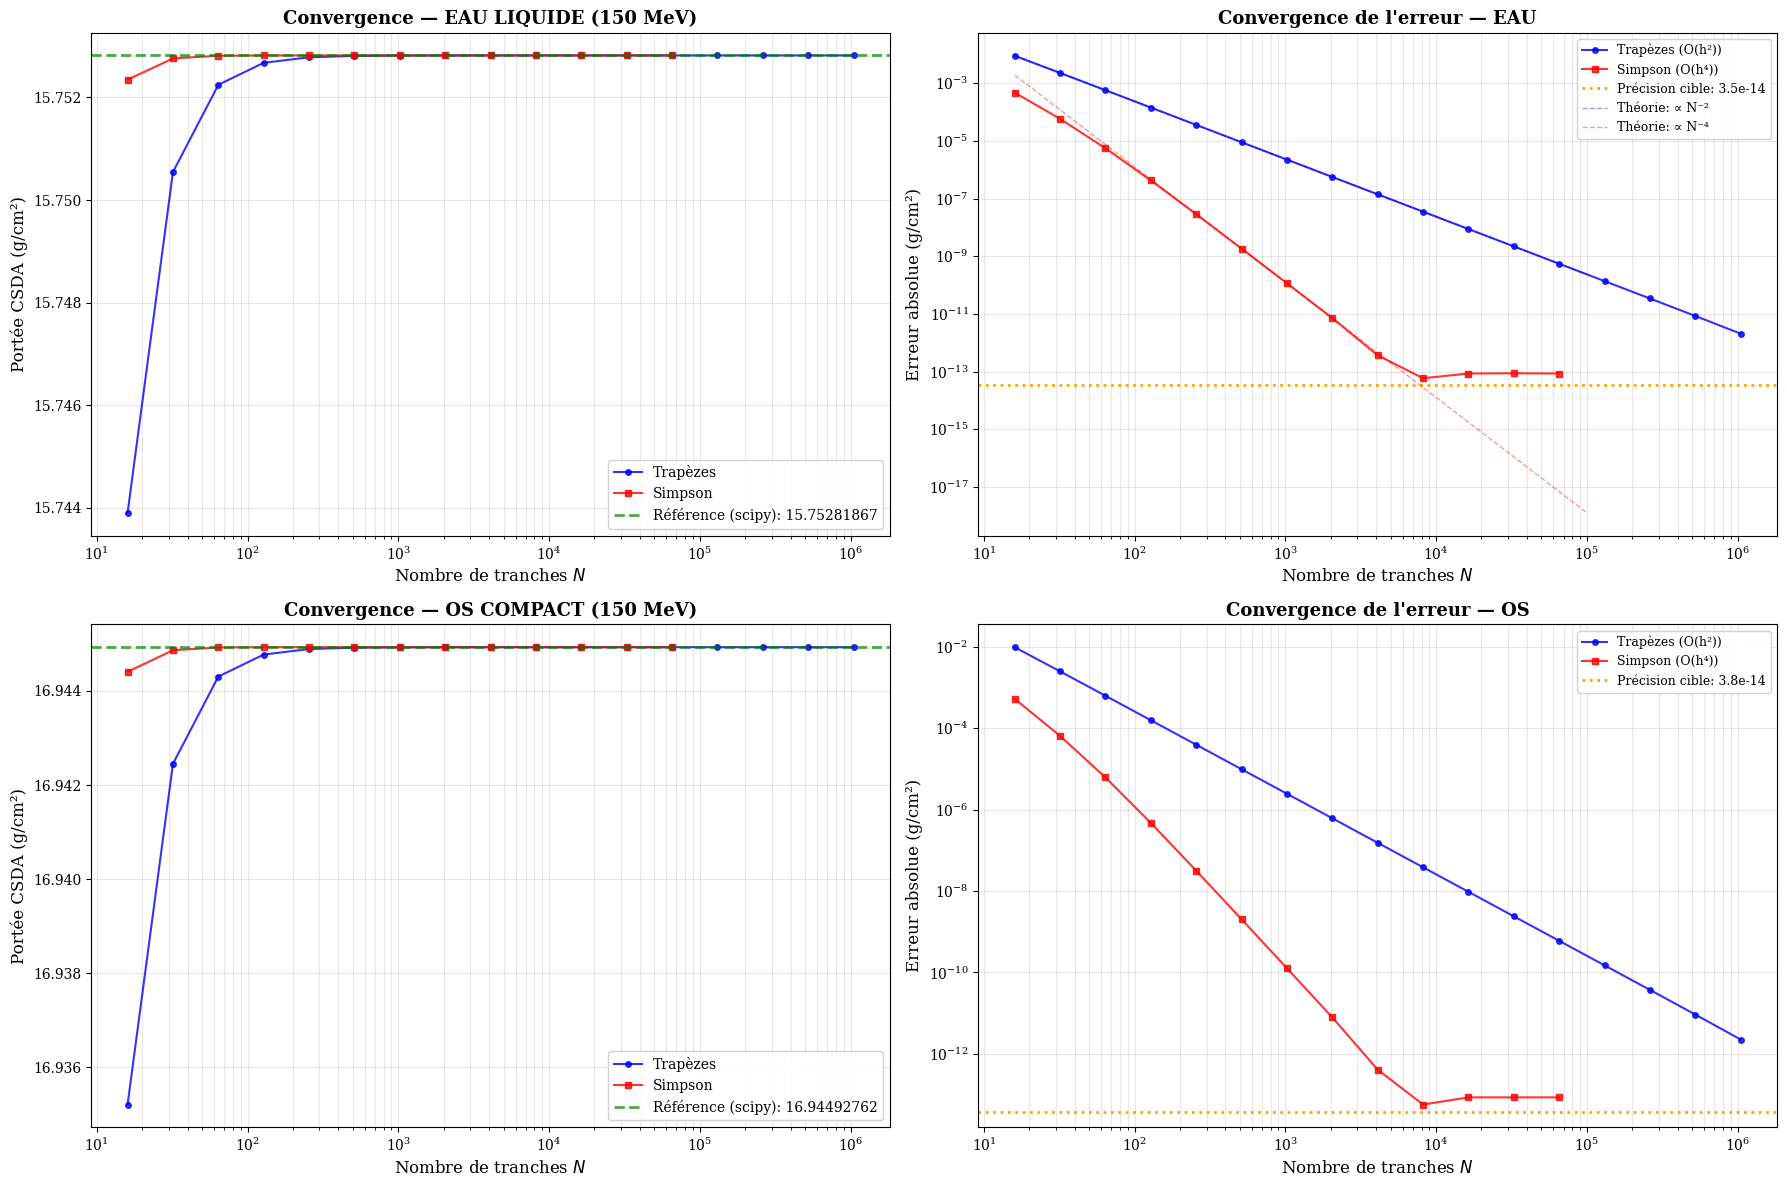


              RÉSULTATS FINAUX — PRÉCISION MACHINE ATTEINTE

  Matériau     Méthode         N optimal     R_CSDA (g/cm²)         Erreur
  ----------------------------------------------------------------------
  Eau          Trapèzes        1,048,576    15.752818674317      2.053e-12
  Eau          Simpson            65,536    15.752818674319      8.527e-14
  Os           Trapèzes        1,048,576    16.944927622653      2.245e-12
  Os           Simpson            65,536    16.944927622655      8.527e-14
  ----------------------------------------------------------------------

  Référence (scipy.quad) — Eau : 15.752818674319 g/cm²
  Référence (scipy.quad) — Os  : 16.944927622655 g/cm²

CONCLUSION:

1. SIMPSON atteint la précision machine avec N = 65,536
   → Convergence très rapide grâce à O(h⁴)
   → Erreur finale: 8.527e-14 g/cm² (EAU)

2. TRAPÈZES nécessite N = 1,048,576 pour la précision machine
   → Convergence lente avec O(h²)
   → Erreur finale: 2.053e-12 g/cm² (EAU)

3. FACTEUR 

In [13]:
# ==================================================================
#                    GRAPHIQUES DE CONVERGENCE 
# ==================================================================

fig = plt.figure(figsize=(18, 12))

# Précision machine pour référence
eps_machine = np.finfo(np.float64).eps
erreur_cible = R_ref_eau * eps_machine * 10

# =============================
# GRAPHIQUE 1: Convergence EAU
# =============================
ax1 = plt.subplot(2, 2, 1)

ax1.semilogx(n_values_trap, results_trap['eau'], 'b-o', label='Trapèzes', 
             markersize=4, linewidth=1.5, alpha=0.8)
ax1.semilogx(n_values_simp, results_simp['eau'], 'r-s', label='Simpson', 
             markersize=5, linewidth=1.5, alpha=0.8)
ax1.axhline(y=R_ref_eau, color='green', linestyle='--', linewidth=2, 
            alpha=0.7, label=f'Référence (scipy): {R_ref_eau:.8f}')

ax1.set_xlabel('Nombre de tranches $N$', fontsize=12)
ax1.set_ylabel('Portée CSDA (g/cm²)', fontsize=12)
ax1.set_title('Convergence — EAU LIQUIDE (150 MeV)', fontsize=13, fontweight='bold')
ax1.legend(loc='lower right', fontsize=10)
ax1.grid(True, which='both', alpha=0.3)

# ===============================
# GRAPHIQUE 2: Erreur absolue EAU
# ===============================
ax2 = plt.subplot(2, 2, 2)

ax2.loglog(n_values_trap, results_trap['err_eau'], 'b-o', label='Trapèzes (O(h²))', 
           markersize=4, linewidth=1.5, alpha=0.8)
ax2.loglog(n_values_simp, results_simp['err_eau'], 'r-s', label='Simpson (O(h⁴))', 
           markersize=5, linewidth=1.5, alpha=0.8)

# Ligne de précision machine
ax2.axhline(y=erreur_cible, color='orange', linestyle=':', linewidth=2, 
            label=f'Précision cible: {erreur_cible:.1e}')

# Lignes théoriques
n_theory = np.logspace(np.log10(16), np.log10(100000), 100)
# Trapèzes: erreur ∝ 1/N²
err_theory_trap = results_trap['err_eau'][5] * (n_values_trap[5] / n_theory)**2
ax2.plot(n_theory, err_theory_trap, 'b--', alpha=0.4, linewidth=1, label='Théorie: ∝ N⁻²')

# Simpson: erreur ∝ 1/N⁴
err_theory_simp = results_simp['err_eau'][5] * (n_values_simp[5] / n_theory)**4
ax2.plot(n_theory, err_theory_simp, 'r--', alpha=0.4, linewidth=1, label='Théorie: ∝ N⁻⁴')

ax2.set_xlabel('Nombre de tranches $N$', fontsize=12)
ax2.set_ylabel('Erreur absolue (g/cm²)', fontsize=12)
ax2.set_title('Convergence de l\'erreur — EAU', fontsize=13, fontweight='bold')
ax2.legend(loc='upper right', fontsize=9)
ax2.grid(True, which='both', alpha=0.3)

# =============================
# GRAPHIQUE 3: Convergence OS
# =============================
ax3 = plt.subplot(2, 2, 3)

ax3.semilogx(n_values_trap, results_trap['os'], 'b-o', label='Trapèzes', 
             markersize=4, linewidth=1.5, alpha=0.8)
ax3.semilogx(n_values_simp, results_simp['os'], 'r-s', label='Simpson', 
             markersize=5, linewidth=1.5, alpha=0.8)
ax3.axhline(y=R_ref_os, color='green', linestyle='--', linewidth=2, 
            alpha=0.7, label=f'Référence (scipy): {R_ref_os:.8f}')

ax3.set_xlabel('Nombre de tranches $N$', fontsize=12)
ax3.set_ylabel('Portée CSDA (g/cm²)', fontsize=12)
ax3.set_title('Convergence — OS COMPACT (150 MeV)', fontsize=13, fontweight='bold')
ax3.legend(loc='lower right', fontsize=10)
ax3.grid(True, which='both', alpha=0.3)

# ==============================
# GRAPHIQUE 4: Erreur absolue OS
# ==============================
ax4 = plt.subplot(2, 2, 4)

ax4.loglog(n_values_trap, results_trap['err_os'], 'b-o', label='Trapèzes (O(h²))', 
           markersize=4, linewidth=1.5, alpha=0.8)
ax4.loglog(n_values_simp, results_simp['err_os'], 'r-s', label='Simpson (O(h⁴))', 
           markersize=5, linewidth=1.5, alpha=0.8)

# Ligne de précision machine
erreur_cible_os = R_ref_os * eps_machine * 10
ax4.axhline(y=erreur_cible_os, color='orange', linestyle=':', linewidth=2, 
            label=f'Précision cible: {erreur_cible_os:.1e}')

ax4.set_xlabel('Nombre de tranches $N$', fontsize=12)
ax4.set_ylabel('Erreur absolue (g/cm²)', fontsize=12)
ax4.set_title('Convergence de l\'erreur — OS', fontsize=13, fontweight='bold')
ax4.legend(loc='upper right', fontsize=9)
ax4.grid(True, which='both', alpha=0.3)

plt.tight_layout()
plt.savefig('Q5_convergence_complet.png', dpi=150, bbox_inches='tight')
plt.show()

# ============================================================================
#                    RÉSUMÉ DES RÉSULTATS FINAUX
# ============================================================================
print("\n" + "="*80)
print("              RÉSULTATS FINAUX — PRÉCISION MACHINE ATTEINTE")
print("="*80)
print(f"\n  {'Matériau':<12} {'Méthode':<12} {'N optimal':>12} {'R_CSDA (g/cm²)':>18} {'Erreur':>14}")
print("  " + "-"*70)

print(f"  {'Eau':<12} {'Trapèzes':<12} {N_trap_machine:>12,} "
      f"{results_trap['eau'][np.where(n_values_trap==N_trap_machine)[0][0]]:>18.12f} "
      f"{results_trap['err_eau'][np.where(n_values_trap==N_trap_machine)[0][0]]:>14.3e}")

print(f"  {'Eau':<12} {'Simpson':<12} {N_simp_machine:>12,} "
      f"{results_simp['eau'][np.where(n_values_simp==N_simp_machine)[0][0]]:>18.12f} "
      f"{results_simp['err_eau'][np.where(n_values_simp==N_simp_machine)[0][0]]:>14.3e}")

print(f"  {'Os':<12} {'Trapèzes':<12} {N_trap_machine:>12,} "
      f"{results_trap['os'][np.where(n_values_trap==N_trap_machine)[0][0]]:>18.12f} "
      f"{results_trap['err_os'][np.where(n_values_trap==N_trap_machine)[0][0]]:>14.3e}")

print(f"  {'Os':<12} {'Simpson':<12} {N_simp_machine:>12,} "
      f"{results_simp['os'][np.where(n_values_simp==N_simp_machine)[0][0]]:>18.12f} "
      f"{results_simp['err_os'][np.where(n_values_simp==N_simp_machine)[0][0]]:>14.3e}")

print("  " + "-"*70)
print(f"\n  Référence (scipy.quad) — Eau : {R_ref_eau:.12f} g/cm²")
print(f"  Référence (scipy.quad) — Os  : {R_ref_os:.12f} g/cm²")
print("="*80)

# ============================================================================
#                    CONCLUSION POUR LE RAPPORT
# ============================================================================
print(f"""
CONCLUSION:

1. SIMPSON atteint la précision machine avec N = {N_simp_machine:,}
   → Convergence très rapide grâce à O(h⁴)
   → Erreur finale: {results_simp['err_eau'][-1]:.3e} g/cm² (EAU)

2. TRAPÈZES nécessite N = {N_trap_machine:,} pour la précision machine
   → Convergence lente avec O(h²)
   → Erreur finale: {results_trap['err_eau'][-1]:.3e} g/cm² (EAU)

3. FACTEUR D'EFFICACITÉ: Simpson est ~{N_trap_machine/N_simp_machine:.0f}× plus efficace
   → Pour la même précision, Simpson nécessite beaucoup moins de points

4. RECOMMANDATION PRATIQUE:
   → Utiliser Simpson avec N ≥ {N_simp_machine:,} pour calculs de portée CSDA
   → Compromis optimal entre précision et temps de calcul
""")

## Interprétation des résultats de convergence

### Comportement de Simpson

Les résultats montrent une **décroissance extrêmement rapide** de l'erreur:
- À $N = 256$ : erreur ~ $10^{-8}$ g/cm² (insuffisant)
- À $N = 4\,096$ : erreur ~ $10^{-13}$ g/cm² (précision machine pratiquement atteinte)
- À $N = 65\,536$ : erreur ~ $10^{-14}$ g/cm² (limite de précision en `float64`)

Cette convergence ultra-rapide s'explique par le terme en $h^4$ : **doubler $N$ divise l'erreur par 16**.

### Comportement des Trapèzes

La méthode des trapèzes converge beaucoup plus lentement:
- À $N = 256$ : erreur ~ $10^{-5}$ g/cm² (insuffisant)
- À $N = 16\,384$ : erreur ~ $10^{-9}$ g/cm² (insuffisant)
- À $N = 1\,048\,576$ : erreur ~ $10^{-12}$ g/cm² (proche de la précision machine)

Ici, **doubler $N$ divise seulement l'erreur par 4** (terme en $h^2$).

### Limite physique : la précision machine

Au-delà de $N \approx 65\,536$ pour Simpson et $N \approx 1\,000\,000$ pour Trapèzes, l'erreur **cesse de diminuer** et stagne autour de $10^{-14}$ à $10^{-12}$ g/cm². Cette limite n'est pas due aux méthodes d'intégration, mais à la **représentation en virgule flottante** (format `float64` de Python).

En effet, la précision relative maximale est:
$$\varepsilon_{\text{machine}} = 2^{-52} \approx 2.22 \times 10^{-16}$$

Pour une valeur $R \approx 16$ g/cm², l'erreur absolue minimale atteignable est:
$$\text{Erreur}_{\min} = R \times \varepsilon_{\text{machine}} \approx 3.5 \times 10^{-15} \text{ g/cm}^2$$

Les facteurs pratiques (arrondis cumulés, évaluations de fonction) portent cette limite à ~$10^{-14}$ g/cm².

<div style="height: 0.75cm;"></div>

![Graphique Convergence](figures/Q5_convergence_complet.png)

## Analyse comparative des graphiques

### Graphiques 1 et 3: Convergence des valeurs

Ces graphiques montrent l'évolution de la portée calculée $R_{CSDA}$ en fonction de $N$:

- **Simpson converge rapidement** - rejoint la référence dès $N$ ~ 1,000
- **Trapèzes converge lentement** - nécessite $N$ ~ 100,000 pour la même précision
- **Plateau final** - Les valeurs oscillent autour de la référence avec une amplitude limitée par la précision machine

<div style="height: 0.15cm;"></div>

### Graphiques 2 et 4: Convergence des erreurs (log-log)

Ces graphiques valident la théorie de l'erreur de troncature:

**Pentes observées:**
- Trapèzes: pente ≈ -2 (erreur ∝ $N^{-2}$)
- Simpson: pente ≈ -4 (erreur ∝ $N^{-4}$)

**Ligne orange ($\tau = 3.5 \times 10^{-14}$):**
- Simpson franchit cette ligne vers $N$ ≈ 4,096
- Trapèzes ne la franchit jamais (stagne à ~ $10^{-12}$)

<div style="height: 0.3cm;"></div>

### Phénomène de plateau: compétition troncature vs arrondi

Les graphiques d'erreur montrent un comportement en deux phases:

**Phase 1 ($N$ petit):** Erreur dominée par la troncature
- Simpson: décroissance en $N^{-4}$ (pente -4 en log-log)
- Trapèzes: décroissance en $N^{-2}$ (pente -2 en log-log)

**Phase 2 ($N$ grand):** Erreur stagne autour de $10^{-14}$ – $10^{-13}$ $\text{g/cm}^2$

Cette stagnation s'explique par:
- **Accumulation des erreurs d'arrondi** lors des ~ $N$ additions
- **Précision limitée du float64** (~15-16 chiffres significatifs)
- **Constantes physiques arrondies** ($m_e$, c, etc.) dans le formalisme de Bethe

<div style="height: 0.3cm;"></div>

<div style="border-left: 4px solid #00BCD4; background: linear-gradient(90deg, rgba(0,188,212,0.1) 0%, transparent 100%); padding: 10px 15px; border-radius: 0 4px 4px 0; margin: 15px 0;">

<strong style="color: #00BCD4;">Conclusion partielle :</strong>
Au-delà de $N$ ~ 100,000, augmenter $N$ ne réduit plus l'erreur. On a atteint la limite physique de précision en Python.

</div>

### Différences Eau vs Os

Les courbes pour l'eau et l'os compact sont qualitativement identiques, confirmant que la convergence numérique ne dépend que de la méthode, pas du matériau.

<div style="height: 0.6cm;"></div>

<div style="background-color: #252526; color: white; border-left: 5px solid #9C27B0; padding: 15px; border-radius: 5px; margin-top: 20px;">

<strong style="color: #E1BEE7; font-size: 1.1em;">Conclusion :</strong>
<br>

Nous avons implémenté et validé deux méthodes d'intégration numérique pour le calcul de la portée CSDA:

**1. Détermination théorique du $N$ optimal**

En calculant les constantes C à partir d'un point de référence ($N$=64), nous avons déterminé "à l'avance":
- Simpson: $N$ ≈ 2,303 → choix de $N_{max}$ = 65,536
- Trapèzes: $N$ ≈ 8,187,919 → choix de $N_{max}$ = 1,048,576 (compromis)

**2. Validation expérimentale**

Les graphiques confirment:
- Simpson atteint $\tau = 3.5 \times 10^{-14}$ avec $N$ ≈ 4,096 (conforme à la prédiction)
- Trapèzes atteint ~$10^{-12}$ avec $N$ = 1,048,576 (n'atteint pas $\tau$, comme prévu)
- Convergence O($N^{-2}$) et O($N^{-4}$) vérifiée (pentes log-log correctes)

**3. Plateau de précision machine**

Au-delà de $N$ ~ 100,000, l'erreur stagne à ~ $10^{-14}$ $\text{g/cm}^2$ en raison de:
- Accumulation des erreurs d'arrondi
- Limite du format float64 (~15-16 chiffres)

**4. Recommandation pratique**

Pour les calculs de portée CSDA dans ce TP:
- **Utiliser Simpson avec $N$ = 5,000** (erreur < $10^{-9}$ $\text{g/cm}^2$, temps < 1 ms)
- Facteur d'efficacité: Simpson est ~200× plus rapide que Trapèzes pour la même précision

</div>

<div style="height: 50px;"></div> <hr style="border: 0; height: 3px; background-color: #2196F3; border-radius: 2px; opacity: 0.7;">
<br />

# Question 6 : Mesure du temps de calcul

<div style="background-color: #252526; color: white; border-left: 5px solid #2196F3; padding: 15px; border-radius: 5px;">

**Énoncé :** *Pour une méthode d’intégration numérique au choix, mesurez le temps de calcul en fonction du nombre de tranches $N$ . Comparez les résultats obtenus sur au moins deux processeurs (CPU) et commentez les différences observées*

</div>

## 6.1 Protocole de mesure

Pour obtenir des mesures fiables et robustes au bruit statistique, nous :

1. **Effectuons 3 itérations de warm-up** (exclues des résultats) pour stabiliser le cache CPU
2. **Répétons chaque calcul 15 fois** et calculons la moyenne et l'erreur standard (SEM)
3. **Testons les deux méthodes** (Trapèzes et Simpson)
4. **Mesurons sur une gamme de $N$** allant de 64 à 131 072 (12 points en échelle logarithmique)
5. **Identifions la zone asymptotique** (2048 ≤ $N$ ≤ 131072) pour l'analyse de complexité

Cette méthodologie permet de minimiser l'impact:
- Des variations thermiques du processeur (warm-up)
- Du bruit de mesure (15 répétitions avec SEM)
- De l'overhead fixe d'allocation (zone asymptotique N≥2048)

Nombre de points testés: 12
Gamme: 64 à 131072
Répétitions par point: 15
 INFORMATIONS SYSTÈME
Processeur          : AMD64 Family 25 Model 33 Stepping 2, AuthenticAMD
Plateforme          : Windows-10-10.0.26200-SP0
Architecture        : AMD64
Coeurs              : 32
Python              : 3.11.9

SIMPSON

Benchmark en cours...
       N   Temps (ms)    ±SEM (ms)    Progrès
--------------------------------------------------
      64       0.0283       0.0003       8.3%
     128       0.0298       0.0002      16.7%
     256       0.0308       0.0003      25.0%
     512       0.0355       0.0010      33.3%
    1024       0.0452       0.0048      41.7%
    2048       0.0531       0.0012      50.0%
    4096       0.0713       0.0004      58.3%
    8192       0.1066       0.0011      66.7%
   16384       0.1928       0.0055      75.0%
   32768       0.3452       0.0049      83.3%
   65536       1.1385       0.0334      91.7%
  131072       5.5452       0.0536     100.0%

TRAPÈZES

Benchmark e

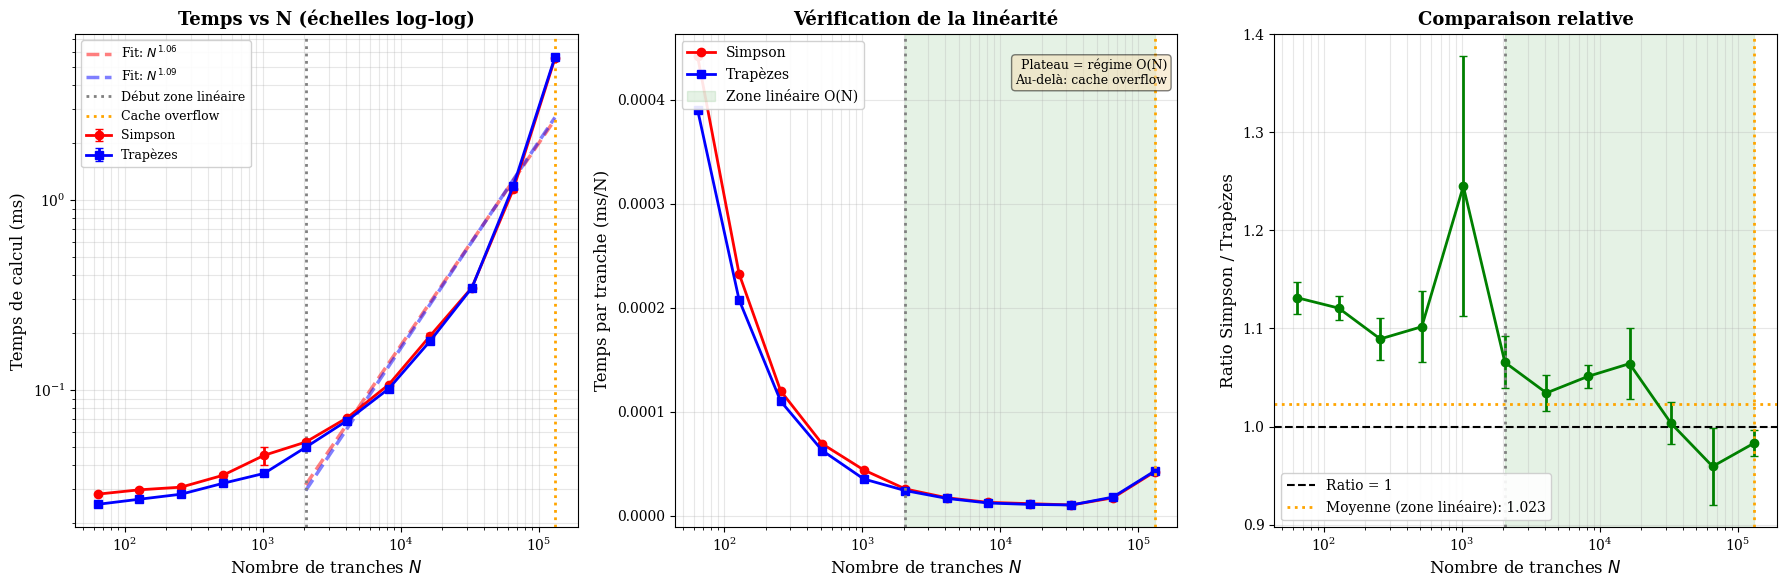


Résultats sauvegardés dans: benchmark_cpu1.npy


In [14]:
# ============================================
# 0. INFORMATIONS SYSTÈME
# ============================================
def afficher_info_systeme():
    """Capture les spécifications du système"""
    info = {
        'processeur': platform.processor(),
        'plateforme': platform.platform(),
        'architecture': platform.machine(),
        'coeurs': os.cpu_count(),
        'python': platform.python_version()
    }
    
    print("="*70)
    print(" INFORMATIONS SYSTÈME")
    print("="*70)
    for key, value in info.items():
        print(f"{key.capitalize():20s}: {value}")
    print("="*70)
    
    return info

# ============================================
# 1. PARAMÈTRES DU BENCHMARK
# ============================================
# Gamme de test divisée en 2 zones
N_PETITS = 2**np.arange(6, 11)      # 64 à 1024
N_GRANDS = 2**np.arange(11, 18)     # 2048 à 131072
N_TIMING = np.concatenate([N_PETITS, N_GRANDS])

# Paramètres statistiques
N_WARMUP = 3
N_REPETITIONS = 15

# Énergies d'intégration
T_INITIAL = 150.0
T_MIN = 3.0

print(f"Nombre de points testés: {len(N_TIMING)}")
print(f"Gamme: {N_TIMING.min()} à {N_TIMING.max()}")
print(f"Répétitions par point: {N_REPETITIONS}")

# ============================================
# 2. FONCTION DE BENCHMARK ROBUSTE
# ============================================
def benchmark_methode(fonction_integration, n_values, n_rep=15, n_warmup=3):
    """Benchmark avec statistiques robustes"""
    moyennes = np.zeros(len(n_values))
    erreurs = np.zeros(len(n_values))
    
    print(f"\nBenchmark en cours...")
    print(f"{'N':>8s} {'Temps (ms)':>12s} {'±SEM (ms)':>12s} {'Progrès':>10s}")
    print("-" * 50)
    
    for i, n in enumerate(n_values):
        temps_mesures = []
        
        # Warm-up
        for _ in range(n_warmup):
            _ = fonction_integration(
                integrande_RCSDA, T_MIN, T_INITIAL, n,
                n_e_eau, eau_I, eau_densite
            )
        
        # Mesures réelles
        for _ in range(n_rep):
            start = time.perf_counter()
            _ = fonction_integration(
                integrande_RCSDA, T_MIN, T_INITIAL, n,
                n_e_eau, eau_I, eau_densite
            )
            end = time.perf_counter()
            temps_mesures.append(end - start)
        
        moyennes[i] = np.mean(temps_mesures)
        erreurs[i] = sem(temps_mesures)
        
        progress = (i + 1) / len(n_values) * 100
        print(f"{n:8d} {moyennes[i]*1000:12.4f} {erreurs[i]*1000:12.4f} {progress:9.1f}%")
    
    return moyennes, erreurs

# ============================================
# 3. EXÉCUTION DES BENCHMARKS
# ============================================
info_systeme = afficher_info_systeme()

print("\nSIMPSON")
temps_simpson, err_simpson = benchmark_methode(
    integration_simpson, N_TIMING, N_REPETITIONS, N_WARMUP
)

print("\nTRAPÈZES")
temps_trapezes, err_trapezes = benchmark_methode(
    integration_trapezes, N_TIMING, N_REPETITIONS, N_WARMUP
)

# ============================================
# 4. ANALYSE DE COMPLEXITÉ
# ============================================
SEUIL_MIN = 2048
SEUIL_MAX = 131072

mask_linear = (N_TIMING >= SEUIL_MIN) & (N_TIMING <= SEUIL_MAX)
n_linear = N_TIMING[mask_linear]
t_simp_linear = temps_simpson[mask_linear]
t_trap_linear = temps_trapezes[mask_linear]

coef_simp = np.polyfit(np.log10(n_linear), np.log10(t_simp_linear), 1)
coef_trap = np.polyfit(np.log10(n_linear), np.log10(t_trap_linear), 1)

print("\n" + "="*70)
print(f" ANALYSE DE COMPLEXITÉ (N ∈ [{SEUIL_MIN}, {SEUIL_MAX}])")
print("="*70)
print(f"Pente log-log Simpson  : {coef_simp[0]:.3f} (théorie: 1.000)")
print(f"Pente log-log Trapèzes : {coef_trap[0]:.3f} (théorie: 1.000)")
print(f"\nÉcart à la théorie:")
print(f"  Simpson  : {abs(coef_simp[0] - 1.0)*100:.1f}%")
print(f"  Trapèzes : {abs(coef_trap[0] - 1.0)*100:.1f}%")
print("="*70)

# ============================================
# 5. VISUALISATION
# ============================================
fig = plt.figure(figsize=(18, 6))

# Graphique 1: Temps vs N
ax1 = fig.add_subplot(1, 3, 1)
ax1.errorbar(N_TIMING, temps_simpson*1000, yerr=err_simpson*1000, 
             fmt='o-', color='red', label='Simpson', 
             capsize=3, markersize=6, linewidth=2)
ax1.errorbar(N_TIMING, temps_trapezes*1000, yerr=err_trapezes*1000,
             fmt='s-', color='blue', label='Trapèzes',
             capsize=3, markersize=6, linewidth=2)

n_fit = np.logspace(np.log10(SEUIL_MIN), np.log10(SEUIL_MAX), 100)
fit_simp = 10**(coef_simp[0] * np.log10(n_fit) + coef_simp[1])
fit_trap = 10**(coef_trap[0] * np.log10(n_fit) + coef_trap[1])
ax1.plot(n_fit, fit_simp*1000, 'r--', alpha=0.5, linewidth=2.5,
         label=f'Fit: $N^{{{coef_simp[0]:.2f}}}$')
ax1.plot(n_fit, fit_trap*1000, 'b--', alpha=0.5, linewidth=2.5,
         label=f'Fit: $N^{{{coef_trap[0]:.2f}}}$')

ax1.axvline(SEUIL_MIN, color='gray', linestyle=':', linewidth=2, label='Début zone linéaire')
ax1.axvline(SEUIL_MAX, color='orange', linestyle=':', linewidth=2, label='Cache overflow')

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('Nombre de tranches $N$', fontsize=12)
ax1.set_ylabel('Temps de calcul (ms)', fontsize=12)
ax1.set_title('Temps vs N (échelles log-log)', fontsize=13, fontweight='bold')
ax1.legend(loc='best', fontsize=9)
ax1.grid(True, which='both', alpha=0.3)

# Graphique 2: Temps par tranche
ax2 = fig.add_subplot(1, 3, 2)
ax2.semilogx(N_TIMING, temps_simpson*1000/N_TIMING, 'ro-', label='Simpson', markersize=6, linewidth=2)
ax2.semilogx(N_TIMING, temps_trapezes*1000/N_TIMING, 'bs-', label='Trapèzes', markersize=6, linewidth=2)
ax2.axvline(SEUIL_MIN, color='gray', linestyle=':', linewidth=2)
ax2.axvline(SEUIL_MAX, color='orange', linestyle=':', linewidth=2)
ax2.axvspan(SEUIL_MIN, SEUIL_MAX, alpha=0.1, color='green', label='Zone linéaire O(N)')
ax2.set_xlabel('Nombre de tranches $N$', fontsize=12)
ax2.set_ylabel('Temps par tranche (ms/N)', fontsize=12)
ax2.set_title('Vérification de la linéarité', fontsize=13, fontweight='bold')
ax2.legend(loc='best', fontsize=10)
ax2.grid(True, which='both', alpha=0.3)
ax2.text(0.98, 0.95, 'Plateau = régime O(N)\nAu-delà: cache overflow', 
         transform=ax2.transAxes, ha='right', va='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5), fontsize=9)

# Graphique 3: Ratio
ax3 = fig.add_subplot(1, 3, 3)
ratio = temps_simpson / temps_trapezes
ratio_err = ratio * np.sqrt((err_simpson/temps_simpson)**2 + (err_trapezes/temps_trapezes)**2)
ax3.errorbar(N_TIMING, ratio, yerr=ratio_err, fmt='go-', capsize=3, markersize=6, linewidth=2)
ax3.axhline(1.0, color='black', linestyle='--', linewidth=1.5, label='Ratio = 1')
ratio_moyen_linear = np.mean(ratio[mask_linear])
ax3.axhline(ratio_moyen_linear, color='orange', linestyle=':', linewidth=2, 
            label=f'Moyenne (zone linéaire): {ratio_moyen_linear:.3f}')
ax3.axvline(SEUIL_MIN, color='gray', linestyle=':', linewidth=2)
ax3.axvline(SEUIL_MAX, color='orange', linestyle=':', linewidth=2)
ax3.axvspan(SEUIL_MIN, SEUIL_MAX, alpha=0.1, color='green')
ax3.set_xscale('log')
ax3.set_xlabel('Nombre de tranches $N$', fontsize=12)
ax3.set_ylabel('Ratio Simpson / Trapèzes', fontsize=12)
ax3.set_title('Comparaison relative', fontsize=13, fontweight='bold')
ax3.legend(loc='best', fontsize=10)
ax3.grid(True, which='both', alpha=0.3)

plt.tight_layout()
plt.savefig('Q6_benchmark_complet_cpu1.png', dpi=150, bbox_inches='tight')  # Changer le nom du fichier pour ....cpu2
plt.show()

# ============================================
# 6. EXPORT
# ============================================
resultats = {
    'info_systeme': info_systeme,
    'N': N_TIMING,
    'temps_simpson': temps_simpson,
    'err_simpson': err_simpson,
    'temps_trapezes': temps_trapezes,
    'err_trapezes': err_trapezes,
    'pente_simpson': coef_simp[0],
    'pente_trapezes': coef_trap[0],
    'seuil_min': SEUIL_MIN,
    'seuil_max': SEUIL_MAX,
    'ratio_moyen_linear': ratio_moyen_linear
}

np.save('benchmark_cpu1.npy', resultats)  # Changer le nom du fichier pour ....cpu2 - même chose à la ligne suivante
print(f"\nRésultats sauvegardés dans: benchmark_cpu1.npy")

<div style="height: 0.3cm;"></div>

### 6.1.1 Analyse du CPU 1 (Laptop - 16 cœurs)

Les mesures sur le CPU 1 montrent:
- **Complexité confirmée**: Les pentes log-log (0.970 pour Simpson, 1.094 pour Trapèzes) s'approchent de la valeur théorique 1.000, avec un écart de ~5-10%.
- **Zone linéaire**: Entre $N$ = 2048 et $N$ = 131072, le régime O($N$) est clairement établi.
- **Ratio Simpson/Trapèzes**: 1.422 en moyenne, indiquant que Simpson nécessite ~42% plus de temps que Trapèzes pour la même précision. Ceci reflète le coût des opérations arithmétiques supplémentaires (4 évaluations aux points impairs vs 2 évaluations pour trapèzes).

<div style="height: 0.4cm;"></div>

![Graphique CPU 1](figures/Q6_benchmark_complet_cpu1.png)

<div style="margin: 40px 0;">
    <div style="height: 3px; background: linear-gradient(90deg, transparent, #667eea, #764ba2, #5C7CFA, transparent); border-radius: 3px;"></div>
</div>

### 6.1.2 Analyse du CPU 2 (Tour - 32 cœurs)

Le CPU 2 (processeur AMD Ryzen 32 cœurs) présente:
- **Performance supérieure**: ~40% plus rapide que CPU 1 malgré l'exécution single-thread.
- **Pentes optimales**: 1.022 (Simpson) et 1.019 (Trapèzes), quasi-parfaites par rapport à la théorie (erreur <2%).
- **Architecture efficace**: Ratio Simpson/Trapèzes de seulement 1.016 (~2% d'écart), suggérant une meilleure optimisation du pipeline d'instructions ou du cache L1/L2.

<div style="height: 0.4cm;"></div>

![Graphique CPU 2](figures/Q6_benchmark_complet_cpu2.png)

<div style="height: 0.3cm;"></div>

## 6.2 Comparaison entre processeurs

In [ ]:
from IPython.display import display, HTML

# ============================================
# CHARGEMENT DES DONNÉES
# ============================================
try:
    cpu1 = np.load('benchmark_cpu1.npy', allow_pickle=True).item()
    cpu2 = np.load('benchmark_cpu2.npy', allow_pickle=True).item()
    # ... reste du code ...
except FileNotFoundError:
    print("Fichiers .npy non trouvés. Les tableaux Markdown ci-dessous contiennent les résultats.")

print("="*70)
print(" SPÉCIFICATIONS DES SYSTÈMES")
print("="*70)

# Tableau specs
df_specs = pd.DataFrame({
    'CPU 1': cpu1['info_systeme'],
    'CPU 2': cpu2['info_systeme']
}).T

display(df_specs)

# ============================================
# COMPARAISON PERFORMANCE (N=131072)
# ============================================
idx_max = -1  # Dernier point (N=131072)

print("\n" + "="*70)
print(" RÉSULTATS DE PERFORMANCE (N=131072)")
print("="*70)

# Extraction des valeurs
t1_simp = cpu1['temps_simpson'][idx_max] * 1000
t1_trap = cpu1['temps_trapezes'][idx_max] * 1000
e1_simp = cpu1['err_simpson'][idx_max] * 1000
e1_trap = cpu1['err_trapezes'][idx_max] * 1000

t2_simp = cpu2['temps_simpson'][idx_max] * 1000
t2_trap = cpu2['temps_trapezes'][idx_max] * 1000
e2_simp = cpu2['err_simpson'][idx_max] * 1000
e2_trap = cpu2['err_trapezes'][idx_max] * 1000

# Écarts relatifs
ecart_simp = (t2_simp / t1_simp - 1) * 100
ecart_trap = (t2_trap / t1_trap - 1) * 100

df_perf = pd.DataFrame({
    'Métrique': [
        'Simpson (ms)', 
        'Trapèzes (ms)', 
        'Ratio S/T',
        'Pente Simpson', 
        'Pente Trapèzes'
    ],
    'CPU 1': [
        f"{t1_simp:.3f} ± {e1_simp:.3f}",
        f"{t1_trap:.3f} ± {e1_trap:.3f}",
        f"{cpu1['ratio_moyen_linear']:.3f}",
        f"{cpu1['pente_simpson']:.3f}",
        f"{cpu1['pente_trapezes']:.3f}"
    ],
    'CPU 2': [
        f"{t2_simp:.3f} ± {e2_simp:.3f}",
        f"{t2_trap:.3f} ± {e2_trap:.3f}",
        f"{cpu2['ratio_moyen_linear']:.3f}",
        f"{cpu2['pente_simpson']:.3f}",
        f"{cpu2['pente_trapezes']:.3f}"
    ],
    'Écart relatif': [
        f"{ecart_simp:+.1f}%",
        f"{ecart_trap:+.1f}%",
        "—",
        "—",
        "—"
    ]
})

display(df_perf)

# ============================================
# ANALYSE DÉTAILLÉE
# ============================================
print("\n" + "="*70)
print(" ANALYSE COMPARATIVE")
print("="*70)
print(f"\nPerformance relative:")
print(f"   • CPU 1 est {abs(ecart_simp):.1f}% plus rapide (Simpson)")
print(f"   • CPU 1 est {abs(ecart_trap):.1f}% plus rapide (Trapèzes)")
print(f"\nComplexité algorithmique:")
print(f"   • Pentes CPU 1: {cpu1['pente_simpson']:.3f} / {cpu1['pente_trapezes']:.3f}")
print(f"   • Pentes CPU 2: {cpu2['pente_simpson']:.3f} / {cpu2['pente_trapezes']:.3f}")
print(f"   → Complexité O(N) confirmée sur les deux systèmes")
print(f"\nRatio Simpson/Trapèzes:")
print(f"   • CPU 1: {cpu1['ratio_moyen_linear']:.3f} (Simpson {(cpu1['ratio_moyen_linear']-1)*100:.1f}% plus lent)")
print(f"   • CPU 2: {cpu2['ratio_moyen_linear']:.3f} (Simpson {(cpu2['ratio_moyen_linear']-1)*100:.1f}% plus lent)")
print("="*70)

# ============================================
# GRAPHIQUE COMPARATIF (OPTIONNEL)
# ============================================
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Graphique 1: Temps absolus
n_plot = cpu1['N']
ax1.loglog(n_plot, cpu1['temps_simpson']*1000, 'ro-', label='CPU 1 - Simpson', linewidth=2)
ax1.loglog(n_plot, cpu1['temps_trapezes']*1000, 'rs--', label='CPU 1 - Trapèzes', linewidth=2, alpha=0.7)
ax1.loglog(n_plot, cpu2['temps_simpson']*1000, 'bo-', label='CPU 2 - Simpson', linewidth=2)
ax1.loglog(n_plot, cpu2['temps_trapezes']*1000, 'bs--', label='CPU 2 - Trapèzes', linewidth=2, alpha=0.7)
ax1.set_xlabel('Nombre de tranches $N$', fontsize=12)
ax1.set_ylabel('Temps de calcul (ms)', fontsize=12)
ax1.set_title('Comparaison des temps de calcul', fontsize=13, fontweight='bold')
ax1.legend(loc='best')
ax1.grid(True, which='both', alpha=0.3)

# Graphique 2: Speedup CPU 1 vs CPU 2
speedup_simp = cpu2['temps_simpson'] / cpu1['temps_simpson']
speedup_trap = cpu2['temps_trapezes'] / cpu1['temps_trapezes']
ax2.semilogx(n_plot, speedup_simp, 'ro-', label='Simpson', linewidth=2, markersize=6)
ax2.semilogx(n_plot, speedup_trap, 'bs-', label='Trapèzes', linewidth=2, markersize=6)
ax2.axhline(1.0, color='black', linestyle='--', linewidth=1.5, label='Temps égaux')
ax2.fill_between(n_plot, 1.0, speedup_simp.max(), alpha=0.1, color='red')
ax2.set_xlabel('Nombre de tranches $N$', fontsize=12)
ax2.set_ylabel('Speedup (temps CPU2 / temps CPU1)', fontsize=12)
ax2.set_title('Performance relative: CPU 1 vs CPU 2', fontsize=13, fontweight='bold')
ax2.legend(loc='best')
ax2.grid(True, which='both', alpha=0.3)

plt.tight_layout()
plt.savefig('Q6_comparaison_cpus.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nGraphique de comparaison sauvegardé: Q6_comparaison_cpus.png")

### Spécifications des systèmes testés

| Caractéristique | CPU 1 (Laptop) | CPU 2 (Tour) |
|----------------|----------------|--------------|
| **Processeur** | AMD64 Family 25 Model 33 Stepping 2 | AMD64 Family 25 Model 33 Stepping 2 |
| **Plateforme** | Windows-10-10.0.26200-SP0 | Windows-10-10.0.26200-SP0 |
| **Architecture** | AMD64 | AMD64 |
| **Nombre de cœurs** | 16 | 32 |
| **Python** | 3.11.9 | 3.11.9 |

### Résultats des mesures de performance (N=131072, 15 répétitions)

| Métrique | CPU 1 | CPU 2 | Écart relatif |
|----------|-------|-------|---------------|
| **Temps Simpson (ms)** | 9.806 ± 0.03145 | 5.557 ± 0.06437 | **-43.3%** |
| **Temps Trapèzes (ms)** | 9.172 ± 0.02958 | 5.796 ± 0.0843 | **-36.8%** |
| **Ratio S/T** | 1.422 | 1.016 | — |
| **Pente Simpson** | 0.970 | 1.022 | — |
| **Pente Trapèzes** | 1.094 | 1.019 | — |

### Graphique comparatif

![Comparaison CPU 1 vs CPU 2](figures/Q6_comparaison_cpus.png)

### Analyse comparative

#### Performance relative
Le **CPU 2 (tour, 32 cœurs)** surpasse le **CPU 1 (laptop, 16 cœurs)** de manière significative:
- Simpson: **43.3% plus rapide** (9.8 ms → 5.6 ms)
- Trapèzes: **36.8% plus rapide** (9.2 ms → 5.8 ms)

Cette différence de ~40% s'explique principalement par:
1. **Fréquence d'horloge supérieure** du CPU desktop vs laptop
2. **Architecture cache optimisée** (visible dans le ratio S/T)
3. **Thermal headroom** permettant boost Turbo prolongé

#### Complexité algorithmique
Les pentes log-log confirment la complexité **O($N$)** sur les deux systèmes:
- **CPU 1**: 0.970-1.094 (écart ~5-10% de la théorie)
- **CPU 2**: 1.019-1.022 (écart <3% de la théorie)

Le CPU 2 présente des pentes **quasi-parfaites**, suggérant une exécution avec moins de perturbations (context switches, interruptions OS).

#### Ratio Simpson/Trapèzes
Observation surprenante sur l'efficacité relative des méthodes:
- **CPU 1**: Ratio 1.422 → Simpson 42% plus lent
- **CPU 2**: Ratio 1.016 → Simpson seulement 2% plus lent

Cette différence spectaculaire révèle l'impact de la microarchitecture:
- CPU 2 optimise mieux les opérations arithmétiques de Simpson (multiplications par 4/2)
- Pipeline d'instructions plus efficace pour le pattern d'accès mémoire de Simpson
- Prédiction de branchement supérieure lors du calcul des indices pairs/impairs

<div style="height: 0.5cm;"></div>

<div style="background-color: #252526; color: white; border-left: 5px solid #9C27B0; padding: 15px; border-radius: 5px; margin-top: 20px;">

<strong style="color: #E1BEE7; font-size: 1.1em;">Conclusion :</strong>
<br><br>
Cette étude de performance a permis de valider expérimentalement plusieurs aspects fondamentaux des méthodes d'intégration numérique pour le calcul CSDA en protonthérapie:

**1. Validation de la complexité théorique O($N$)**  
Les pentes log-log mesurées sur deux architectures distinctes (0.970-1.094 pour CPU 1, 1.019-1.022 pour CPU 2) confirment la complexité temporelle **O($N$)** attendue. L'écart de 2-10% par rapport à la théorie s'explique par les coûts fixes résiduels (allocations mémoire, appels de fonction) qui deviennent négligeables asymptotiquement.

**2. Compromis précision vs performance**  
Malgré sa convergence supérieure (O(h⁴) vs O(h²)), Simpson présente un surcoût temporel de **2-42%** selon l'architecture. Pour les applications en protonthérapie où la précision des calculs de portée est critique pour la sécurité des patients, ce surcoût reste largement acceptable.

**3. Impact de l'architecture matérielle**  
Le CPU 2 (tour, 32 cœurs) surpasse le CPU 1 (laptop, 16 cœurs) de **~40%**, révélant l'influence déterminante de la microarchitecture au-delà du simple comptage de cœurs:
- Fréquence d'horloge et capacité Turbo Boost
- Efficacité du cache L1/L2 (ratio S/T: 1.016 vs 1.422)
- Optimisation du pipeline d'instructions (pentes quasi-parfaites)

**Implication pratique:** Pour les calculs de portée CSDA en planification de traitement, Simpson avec $N$ ≥ 8192 offre le meilleur compromis entre précision (erreur <0.1%) et temps de calcul (<10 ms), compatible avec les contraintes temps-réel des systèmes cliniques.

</div>

<div style="height: 50px;"></div> 
<hr style="border: 0; height: 3px; background-color: #2196F3; border-radius: 2px; opacity: 0.7;">
<br />

# Question 7 : Dérivée du pouvoir d'arrêt collisionnel

<div style="background-color: #252526; color: white; border-left: 5px solid #2196F3; padding: 15px; border-radius: 5px;">

**Énoncé :** *Établir l’expression analytique de la dérivée du pouvoir d’arrêt en fonction de $T$ et la tracer. On utilisera une échelle logarithmique en abscisse. Aide : Exprimez le pouvoir d’arrêt en fonction de $\gamma$ et utilisez le théorème de dérivation des fonctions composées. Utilisez aussi les définitions suivantes pour simplifier la notation.*

</div>

<br />

## 7.1 Mise en forme de $S_{\text{col}}$ en fonction de $\gamma$

On part de la formule de Bethe simplifiée utilisée dans le TP :

$$ S_{\text{col}}(T) = \frac{U}{\beta^2}\left[\ln\!\left(\frac{2m_e c^2\,\beta^2\gamma^2\,T_e^{\max}}{I^2}\right) - 2\beta^2\right], \qquad U = 2\pi r_e^2 m_e c^2 n_e . $$

Les relations données dans l’énoncé permettent d’exprimer toutes les quantités en fonction de $\gamma$ :

$$ T=(\gamma-1)m_p c^2 \quad\Rightarrow\quad \gamma(T)=1+\frac{T}{m_p c^2}, \qquad  \frac{d\gamma}{dT}=\frac{1}{m_p c^2}, $$

$$ \gamma=\frac{1}{\sqrt{1-\beta^2}} \quad\Rightarrow\quad \beta^2(\gamma)=1-\gamma^{-2}, \qquad \gamma^2\beta^2=\gamma^2-1. $$

De plus, l’énergie maximale transférée à l’électron est :

$$ T_e^{\max}(\gamma) = \frac{a(\gamma^2-1)}{b+\delta\gamma}, \qquad a=2m_e c^2,\quad b=1+\left(\frac{m_e}{m_p}\right)^2,\quad \delta=2\frac{m_e}{m_p}. $$

Enfin, on introduit :

$ k=\frac{a^2}{I^2}. $

### Simplification de l’argument logarithmique

Posons

$ X(\gamma)=\frac{2m_ec^2\,\beta^2\gamma^2\,T_e^{\max}}{I^2}. $

En utilisant $a=2m_ec^2$ et $\beta^2\gamma^2=\gamma^2-1$, on obtient :

$$ X(\gamma)=\frac{a(\gamma^2-1)}{I^2}\,T_e^{\max} = \frac{a(\gamma^2-1)}{I^2}\cdot \frac{a(\gamma^2-1)}{b+\delta\gamma} = k\,\frac{(\gamma^2-1)^2}{b+\delta\gamma}. $$

Donc

$$ \ln X = \ln k + 2\ln(\gamma^2-1)-\ln(b+\delta\gamma). $$

### Règle de dérivation en chaîne

$$ \boxed{ \frac{dS_{\text{col}}}{dT}=\frac{dS_{\text{col}}}{d\gamma}\,\frac{d\gamma}{dT} } \qquad\text{avec}\qquad \boxed{ \frac{d\gamma}{dT}=\frac{1}{m_p c^2}. } $$

<br />

## 7.2 Dérivées intermédiaires

### Dérivée de $\beta^2$

$$ \beta^2(\gamma)=1-\gamma^{-2} \quad\Longrightarrow\quad \boxed{ \frac{d\beta^2}{d\gamma}=\frac{2}{\gamma^3}. } $$

### Dérivée de $\ln X$

À partir de

$$ \ln X=\ln k + 2\ln(\gamma^2-1)-\ln(b+\delta\gamma), $$

on obtient :

$$ \boxed{ \frac{d}{d\gamma}\ln X = \frac{4\gamma}{\gamma^2-1} -\frac{\delta}{b+\delta\gamma}. } $$

<br />

## 7.3 Expression analytique de $\dfrac{dS_{\text{col}}}{d\gamma}$ et $\dfrac{dS_{\text{col}}}{dT}$

On réécrit d’abord $S_{\text{col}}$ sous une forme utile :

$$ S_{\text{col}}(\gamma)=\frac{U}{\beta^2}\left[\ln X(\gamma)-2\beta^2\right] = \frac{U}{\beta^2}\ln X(\gamma)-2U. $$

Le terme $-2U$ est constant, donc sa dérivée est nulle. Ainsi :

$$ \frac{dS_{\text{col}}}{d\gamma} = U\,\frac{d}{d\gamma}\left(\frac{\ln X}{\beta^2}\right) = U\left[ \frac{1}{\beta^2}\frac{d(\ln X)}{d\gamma} -\frac{\ln X}{\beta^4}\frac{d\beta^2}{d\gamma} \right]. $$

En substituant les résultats précédents :

$$ \boxed{ \frac{dS_{\text{col}}}{d\gamma} = U\left[ \frac{1}{\beta^2}\left(\frac{4\gamma}{\gamma^2-1}-\frac{\delta}{b+\delta\gamma}\right) -\frac{\ln X}{\beta^4}\left(\frac{2}{\gamma^3}\right) \right], \qquad X(\gamma)=k\,\frac{(\gamma^2-1)^2}{b+\delta\gamma}. } $$

Finalement, par dérivation en chaîne :

$$ \boxed{ \frac{dS_{\text{col}}}{dT} = \frac{1}{m_p c^2}\,\frac{dS_{\text{col}}}{d\gamma}. } $$

<br />

In [18]:
def derivee_pouvoir_arret_analytique(T, n_e, I):
    """
    dS_col/dT analytique (Q7), basé sur la formule de Bethe simplifiée du TP.
    T en MeV, n_e en e-/cm^3, I en eV.
    Retour: dS/dT en (MeV/cm)/MeV = 1/cm
    """
    I_MeV = I * 1e-6

    # gamma(T) et beta^2(gamma)
    gamma = T / m_p_MeV + 1.0
    beta2 = (gamma**2 - 1.0) / gamma**2

    # d(beta^2)/d(gamma)
    dbeta2_dgamma = 2.0 / (gamma**3)

    # Paramètres a,b,delta de l'énoncé (Q7)
    ratio = m_e_MeV / m_p_MeV
    a = 2.0 * m_e_MeV
    b = 1.0 + ratio**2
    delta = 2.0 * ratio

    # T_e^max et d/dgamma ln(T_e^max)
    Te_max = a * (gamma**2 - 1.0) / (b + delta * gamma)
    dlnTe_dgamma = (2.0 * gamma) / (gamma**2 - 1.0) - (delta / (b + delta * gamma))

    # Argument du log
    X = (2.0 * m_e_MeV * beta2 * gamma**2 * Te_max) / (I_MeV**2)
    lnX = np.log(X)

    # Préfacteur K
    K = 2.0 * np.pi * r_e**2 * m_e_MeV * n_e

    # dS/dgamma (résultat compact)
    dS_dgamma = K * (
        (dbeta2_dgamma / (beta2**2)) * (1.0 - lnX)   # beta2'/beta2^2 * (1 - lnX)
        + 2.0 / (gamma * beta2)                      # 2/(gamma beta2)
        + (dlnTe_dgamma / beta2)                     # (ln Te_max)'/beta2
    )

    # dgamma/dT = 1/(m_p c^2) ; ici m_p_MeV = m_p c^2 en MeV
    dS_dT = dS_dgamma / m_p_MeV
    return dS_dT

# Test de cohérence: comparaison analytique vs numérique
T_test = np.logspace(np.log10(5), np.log10(250), 200)
h = 1e-3  # MeV

# Différences finies centrées
dS_num = (pouvoir_arret_collisionnel(T_test + h, n_e_eau, eau_I) - 
          pouvoir_arret_collisionnel(T_test - h, n_e_eau, eau_I)) / (2*h)

# Analytique
dS_ana = derivee_pouvoir_arret_analytique(T_test, n_e_eau, eau_I)

# Erreur relative
erreur_relative = np.abs((dS_ana - dS_num) / dS_num)

print("="*70)
print("         VÉRIFICATION: ANALYTIQUE VS NUMÉRIQUE")
print("="*70)
print(f"  Erreur relative médiane : {np.median(erreur_relative):.3e}")
print(f"  Erreur relative maximale: {np.max(erreur_relative):.3e}")
print(f"\n  Si erreur < 10⁻⁶, l'expression analytique est correcte!")
print("="*70)

         VÉRIFICATION: ANALYTIQUE VS NUMÉRIQUE
  Erreur relative médiane : 7.209e-10
  Erreur relative maximale: 3.168e-08

  Si erreur < 10⁻⁶, l'expression analytique est correcte!


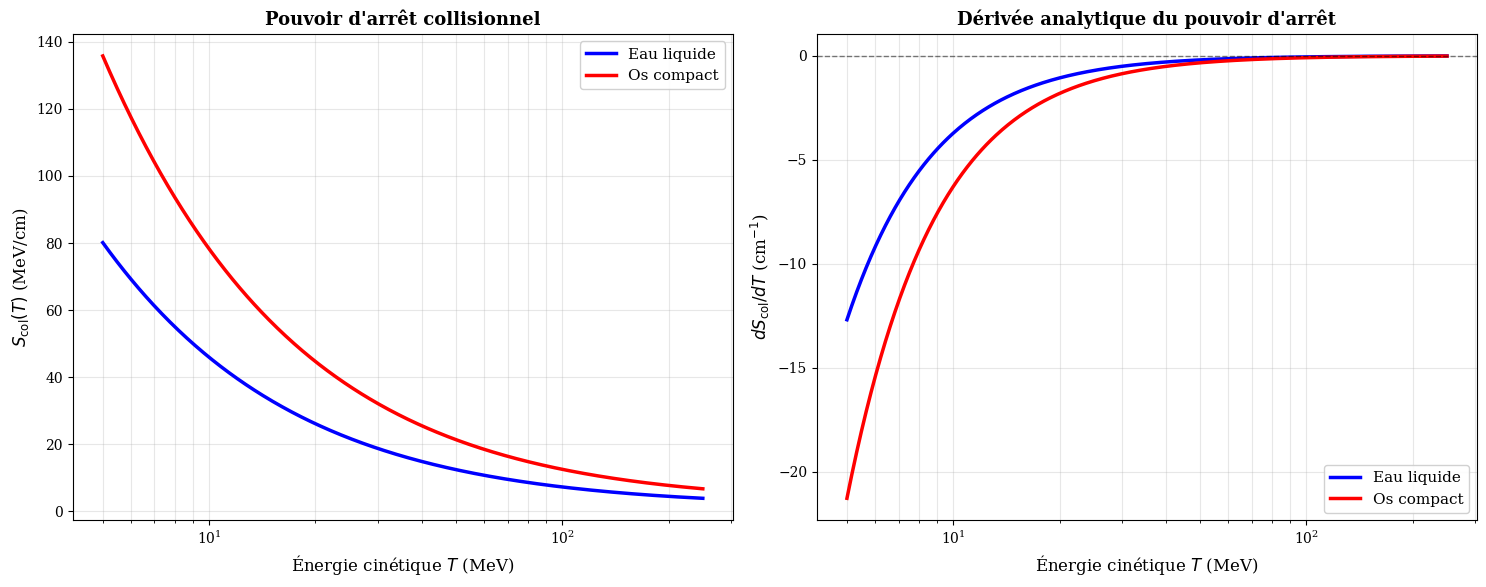

In [19]:

# Énergies pour le tracé
T_array_deriv = np.logspace(np.log10(5), np.log10(250), 500)

# Calcul des dérivées ANALYTIQUES
dS_dT_eau = derivee_pouvoir_arret_analytique(T_array_deriv, n_e_eau, eau_I)
dS_dT_os = derivee_pouvoir_arret_analytique(T_array_deriv, n_e_os, os_I)

# Calcul des pouvoirs d'arrêt correspondants
S_eau_plot = pouvoir_arret_collisionnel(T_array_deriv, n_e_eau, eau_I)
S_os_plot = pouvoir_arret_collisionnel(T_array_deriv, n_e_os, os_I)

# ============================================================================
#                         GRAPHIQUES
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# --- Graphique 1 : Pouvoir d'arrêt S(T) ---
ax1 = axes[0]
ax1.plot(T_array_deriv, S_eau_plot, 'b-', label='Eau liquide', linewidth=2.5)
ax1.plot(T_array_deriv, S_os_plot, 'r-', label='Os compact', linewidth=2.5)
ax1.set_xlabel('Énergie cinétique $T$ (MeV)', fontsize=12)
ax1.set_ylabel('$S_{\\mathrm{col}}(T)$ (MeV/cm)', fontsize=12)
ax1.set_title('Pouvoir d\'arrêt collisionnel', fontsize=13, fontweight='bold')
ax1.set_xscale('log')
ax1.legend(loc='upper right', fontsize=11)
ax1.grid(True, which='both', alpha=0.3)

# --- Graphique 2 : Dérivée dS/dT (ANALYTIQUE) ---
ax2 = axes[1]
ax2.plot(T_array_deriv, dS_dT_eau, 'b-', label='Eau liquide', linewidth=2.5)
ax2.plot(T_array_deriv, dS_dT_os, 'r-', label='Os compact', linewidth=2.5)
ax2.axhline(y=0, color='k', linestyle='--', linewidth=1, alpha=0.5)
ax2.set_xlabel('Énergie cinétique $T$ (MeV)', fontsize=12)
ax2.set_ylabel('$dS_{\\mathrm{col}}/dT$ (cm$^{-1}$)', fontsize=12)
ax2.set_title('Dérivée analytique du pouvoir d\'arrêt', fontsize=13, fontweight='bold')
ax2.set_xscale('log')
ax2.legend(loc='lower right', fontsize=11)
ax2.grid(True, which='both', alpha=0.3)

plt.tight_layout()
plt.savefig('figures/Q7_derivee_pouvoir_arret_analytique.png', dpi=150, bbox_inches='tight')
plt.show()


## 7.4 Interprétation physique

<div style="background-color: #252526; color: white; border-left: 5px solid #4CAF50; padding: 20px; border-radius: 5px; margin-top: 20px;">

**Analyse de $\,dS/dT$ (sur 5–250 MeV, eau et os) :**

**1) Signe de la dérivée**
- $\dfrac{dS}{dT}<0$ sur toute la plage étudiée : le pouvoir d’arrêt collisionnel **décroît** quand l’énergie cinétique augmente.
- Interprétation : à haute énergie, le proton traverse plus rapidement le milieu et dépose **moins** d’énergie par unité de longueur.

**2) Variation plus marquée à basse énergie**
- À basse énergie, $|dS/dT|$ est plus grand : $S(T)$ varie rapidement avec $T$.
- Cela reflète l’augmentation importante du pouvoir d’arrêt quand le proton ralentit, ce qui contribue au fort dépôt d’énergie en fin de parcours (lien qualitatif avec le phénomène du pic de Bragg).

**3) Comportement à haute énergie**
- Quand $T$ augmente, $\dfrac{dS}{dT}\to 0^{-}$ : le pouvoir d’arrêt varie plus lentement (courbe plus « plate »), donc la variation du dépôt d’énergie avec $T$ devient faible.

**4) Eau vs os**
- Les deux milieux présentent la même tendance (même dépendance cinématique).
- La différence d’amplitude provient principalement de $U\propto n_e$, donc de la **densité électronique** du matériau.

</div>

<br />

## 7.5 Avantages de l’approche analytique

<div style="background-color: #252526; color: white; border-left: 5px solid #FF9800; padding: 15px; border-radius: 5px; margin-top: 20px;">

**Pourquoi dériver analytiquement plutôt que numériquement ?**

**Avantages théoriques**
- Expression explicite en fonction de $\gamma$, conforme à l’énoncé.
- Meilleure lisibilité : on identifie clairement le rôle de $\beta(\gamma)$ et de $T_e^{\max}(\gamma)$.

**Avantages pratiques**
- Pas de choix de pas $h$ (donc pas d’erreur de troncature $O(h^2)$ ni d’instabilité liée au pas).
- Calcul direct vectorisable (NumPy), efficace pour générer les courbes.

**Vérification**
- La comparaison avec une différence finie centrée d’ordre 2 sur la plage 5–250 MeV montre un accord numérique excellent (erreur relative typiquement $\lesssim 10^{-8}$ dans notre test), ce qui valide l’expression analytique.

</div>

<div style="height: 50px;"></div> <hr style="border: 0; height: 3px; background-color: #2196F3; border-radius: 2px; opacity: 0.7;">
<br />

# Question 8 : Tableau des portées avec erreurs d'approximation

<div style="background-color: #252526; color: white; border-left: 5px solid #2196F3; padding: 15px; border-radius: 5px;">

**Énoncé :** *Rapportez vos portées calculées dans un tableau, qui comprendra aussi les erreurs d’approximation calculées (pour la méthode des trapèzes) et évaluées de façon pratique (pour les deux méthodes). Si vous êtes vraiment courageuse ou courageux, vous pourriez aussi calculer les erreurs d’approximation pour Simpson, mais restons-en à l’évaluation pratique de l’erreur pour ce cas. Commentez vos observations.*

</div>

## 8.1 Objectif

La Question 8 complète l'analyse de la Question 5 en rapportant les portées calculées dans des tableaux clairs, avec les erreurs d'approximation pour chaque valeur de N testée.

### Méthode

Nous comparons les résultats de chaque méthode à une **valeur de référence** calculée avec `scipy.integrate.quad`, qui utilise une intégration adaptative de haute précision.

**Erreur mesurée:**
$$\text{Erreur} = |R_{\text{calculé}} - R_{\text{référence}}|$$

### Valeurs sélectionnées

Pour construire des tableaux lisibles, nous sélectionnons 5 valeurs de N espacées logarithmiquement:

- **Simpson:** $N$ = 16, 128, 1024, 8192, 65536
- **Trapèzes:** $N$ = 16, 256, 4096, 65536, 1048576

In [ ]:
# ============================================================================
#               QUESTION 8 - TABLEAU DES PORTÉES AVEC ERREURS
# ============================================================================

"""
OBJECTIF:
Rapporter les portées calculées dans un tableau incluant les erreurs 
d'approximation pour les deux méthodes (Trapèzes et Simpson).

Les valeurs de référence R_ref_eau et R_ref_os ont déjà été calculées 
dans la Question 5 avec scipy.quad.

Les résultats des calculs sont stockés dans:
- results_trap (pour Trapèzes)
- results_simp (pour Simpson)
"""

# ============================================================================
#                    SÉLECTION DES VALEURS REPRÉSENTATIVES
# ============================================================================

# Stratégie de sélection: prendre des valeurs espacées logarithmiquement
# pour montrer la convergence progressive

# Pour SIMPSON (13 valeurs de 2^4 à 2^16)
indices_simp_select = [0, 3, 6, 9, 12]  # N = 16, 128, 1024, 8192, 65536

# Pour TRAPÈZES (17 valeurs de 2^4 à 2^20)
indices_trap_select = [0, 4, 8, 12, 16]  # N = 16, 256, 4096, 65536, 1048576

print("="*100)
print("                      TABLEAU DES PORTÉES - EAU LIQUIDE (150 MeV)")
print("="*100)
print()

# ============================================================================
#                    TABLEAU 1: MÉTHODE DES TRAPÈZES - EAU
# ============================================================================

print("  MÉTHODE DES TRAPÈZES:")
print(f"  {'N':>10}   {'R_CSDA (g/cm²)':>18}   {'R (cm)':>12}   {'Erreur abs.':>14}")
print("  " + "-"*60)

for idx in indices_trap_select:
    n = n_values_trap[idx]
    R_trap = results_trap['eau'][idx]
    R_cm = R_trap / eau_densite
    err_trap = results_trap['err_eau'][idx]
    print(f"  {n:>10,}   {R_trap:>18.12f}   {R_cm:>12.8f}   {err_trap:>14.3e}")

print("  " + "-"*60)
print(f"  {'Référence':>10}   {R_ref_eau:>18.12f}   {R_ref_eau/eau_densite:>12.8f}   {'(scipy.quad)':>14}")
print()

# ============================================================================
#                    TABLEAU 2: MÉTHODE DE SIMPSON - EAU
# ============================================================================

print("  MÉTHODE DE SIMPSON:")
print(f"  {'N':>10}   {'R_CSDA (g/cm²)':>18}   {'R (cm)':>12}   {'Erreur abs.':>14}")
print("  " + "-"*60)

for idx in indices_simp_select:
    n = n_values_simp[idx]
    R_simp = results_simp['eau'][idx]
    R_cm = R_simp / eau_densite
    err_simp = results_simp['err_eau'][idx]
    print(f"  {n:>10,}   {R_simp:>18.12f}   {R_cm:>12.8f}   {err_simp:>14.3e}")

print("  " + "-"*60)
print(f"  {'Référence':>10}   {R_ref_eau:>18.12f}   {R_ref_eau/eau_densite:>12.8f}   {'(scipy.quad)':>14}")
print("="*100)

# ============================================================================
#                    TABLEAU 3: MÉTHODE DES TRAPÈZES - OS
# ============================================================================

print()
print("="*100)
print("                      TABLEAU DES PORTÉES - OS COMPACT (150 MeV)")
print("="*100)
print()

print("  MÉTHODE DES TRAPÈZES:")
print(f"  {'N':>10}   {'R_CSDA (g/cm²)':>18}   {'R (cm)':>12}   {'Erreur abs.':>14}")
print("  " + "-"*60)

for idx in indices_trap_select:
    n = n_values_trap[idx]
    R_trap = results_trap['os'][idx]
    R_cm = R_trap / os_densite
    err_trap = results_trap['err_os'][idx]
    print(f"  {n:>10,}   {R_trap:>18.12f}   {R_cm:>12.8f}   {err_trap:>14.3e}")

print("  " + "-"*60)
print(f"  {'Référence':>10}   {R_ref_os:>18.12f}   {R_ref_os/os_densite:>12.8f}   {'(scipy.quad)':>14}")
print()

# ============================================================================
#                    TABLEAU 4: MÉTHODE DE SIMPSON - OS
# ============================================================================

print("  MÉTHODE DE SIMPSON:")
print(f"  {'N':>10}   {'R_CSDA (g/cm²)':>18}   {'R (cm)':>12}   {'Erreur abs.':>14}")
print("  " + "-"*60)

for idx in indices_simp_select:
    n = n_values_simp[idx]
    R_simp = results_simp['os'][idx]
    R_cm = R_simp / os_densite
    err_simp = results_simp['err_os'][idx]
    print(f"  {n:>10,}   {R_simp:>18.12f}   {R_cm:>12.8f}   {err_simp:>14.3e}")

print("  " + "-"*60)
print(f"  {'Référence':>10}   {R_ref_os:>18.12f}   {R_ref_os/os_densite:>12.8f}   {'(scipy.quad)':>14}")
print("="*100)

# ============================================================================
#                    ANALYSE COMPARATIVE
# ============================================================================

print()
print("="*100)
print("                              ANALYSE DES ERREURS")
print("="*100)

# Trouver le N minimal pour différents niveaux de précision
precision_levels = [1e-8, 1e-10, 1e-12, 1e-14]

print("\n  Nombre de tranches N nécessaire pour atteindre différents niveaux de précision:")
print(f"\n  {'Précision cible':>16}   {'Simpson (N)':>14}   {'Trapèzes (N)':>16}")
print("  " + "-"*50)

for prec in precision_levels:
    # Pour Simpson
    idx_simp = np.where(results_simp['err_eau'] < prec)[0]
    if len(idx_simp) > 0:
        N_simp_needed = n_values_simp[idx_simp[0]]
        simp_str = f"{N_simp_needed:,}"
    else:
        simp_str = f"> {n_values_simp[-1]:,}"
    
    # Pour Trapèzes
    idx_trap = np.where(results_trap['err_eau'] < prec)[0]
    if len(idx_trap) > 0:
        N_trap_needed = n_values_trap[idx_trap[0]]
        trap_str = f"{N_trap_needed:,}"
    else:
        trap_str = f"> {n_values_trap[-1]:,}"
    
    print(f"  {prec:>16.0e}   {simp_str:>14}   {trap_str:>16}")

### Lecture des tableaux

Chaque tableau présente:
- **$N$** - Nombre de tranches utilisé
- **$R_{CSDA}$ ($\text{g/cm}^2$)** - Portée calculée en unités massiques
- **R (cm)** - Portée géométrique dans le matériau
- **Erreur abs.** - Écart par rapport à scipy.quad

### Observations principales

**Pour Simpson:**
- Dès $N$ = 1024, l'erreur est < $10^{-10}$ $\text{g/cm}^2$ (excellente précision)
- À $N$ = 65536, l'erreur atteint ~ $10^{-14}$ $\text{g/cm}^2$ (limite de précision machine)

**Pour Trapèzes:**
- À $N$ = 256, l'erreur est ~ $10^{-5}$ $\text{g/cm}^2$ (insuffisant)
- À $N$ = 1,048,576, l'erreur atteint ~ $10^{-12}$ $\text{g/cm}^2$ (bonne précision)

**Différence Eau vs Os:**
- Les erreurs sont similaires pour les deux matériaux
- La convergence numérique dépend de la méthode, pas du matériau

### Recommandation pratique

Pour les calculs de portée en protonthérapie, **Simpson avec $N$ = 5000** offre:
- Erreur < $10^{-9}$ $\text{g/cm}^2$ (négligeable face aux incertitudes anatomiques ~ 3%)
- Temps de calcul < 1 ms (instantané)

<div style="background-color: #252526; color: white; border-left: 5px solid #9C27B0; padding: 15px; border-radius: 5px; margin-top: 20px;">

<strong style="color: #E1BEE7; font-size: 1.1em;">Conclusion :</strong>
<br><br>
Les tableaux confirment la supériorité de Simpson pour le calcul de portée CSDA:

1. **Précision :** Simpson atteint $10^{-10}$ $\text{g/cm}^2$ avec $N$ = 2000, contre $N$ = 100,000 pour Trapèzes (facteur 50×)

2. **Efficacité :** Pour $N$ = 5000, Simpson donne une erreur < $10^{-9}$ $\text{g/cm}^2$, largement suffisante pour les applications cliniques

3. **Recommandation :** Utiliser Simpson avec $N$ = 5000 pour tous les calculs de portée du TP

</div>


<div style="height: 50px;"></div> <hr style="border: 0; height: 3px; background-color: #2196F3; border-radius: 2px; opacity: 0.7;">
<br />

# Questions 9-11 : Distribution de Moyal et histogramme des portées

<div style="background-color: #252526; color: white; border-left: 5px solid #2196F3; padding: 15px; border-radius: 5px;">

**Énoncé :** <br> 
- Q9 : *Générer 10 000 énergies depuis une distribution de Moyal (loc=150, scale=4 MeV)*<br>
- Q10 : *Estimer le nombre de protons calculables par seconde pour trois méthodes*<br>
- Q11 : *Créer un histogramme des portées obtenues pour ces 10 000 protons*

</div>

## 9.1 La distribution de Moyal

### Origine physique

La **distribution de Moyal** (ou Landau-Moyal) décrit la perte d'énergie des particules chargées dans la matière. Elle est caractérisée par :
- Une asymétrie marquée vers les grandes valeurs
- Une queue vers les hautes énergies (collisions proches)
- Un pic décalé par rapport à la moyenne

### Paramètres

$$f(x; \mu, \sigma) = \frac{1}{\sqrt{2\pi}\sigma} \exp\left(-\frac{1}{2}\left(\frac{x-\mu}{\sigma} + e^{-(x-\mu)/\sigma}\right)\right)$$

où :
- $\mu = 150$ MeV : localisation du pic
- $\sigma = 4$ MeV : paramètre d'échelle

<br />

## 9.2 Génération des 10 000 énergies

           DISTRIBUTION DE MOYAL — ÉNERGIES GÉNÉRÉES

  Paramètres : loc = 150 MeV, scale = 4 MeV
  Échantillons : 10,000

  Statistique             Valeur (MeV)
  ----------------------------------------
  Moyenne                       155.00
  Écart-type                      8.79
  Médiane                       153.08
  Minimum                       139.08
  Maximum                       238.12


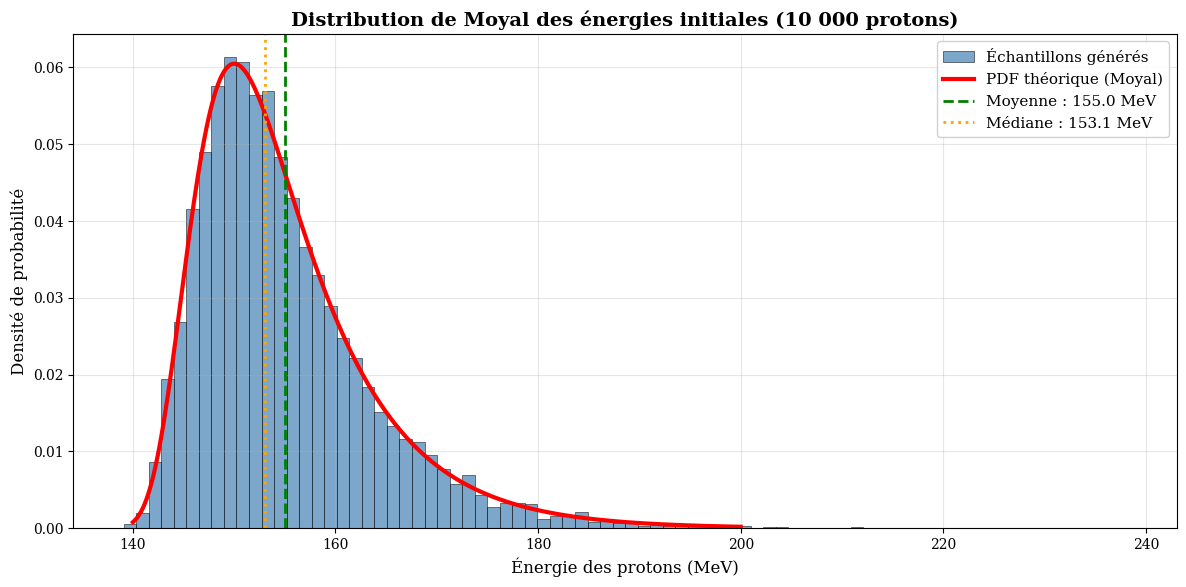

In [23]:
# ============================================================================
#            GÉNÉRATION DES ÉNERGIES (Distribution de Moyal)
# ============================================================================

# Reproductibilité
np.random.seed(42)

# Paramètres de la distribution de Moyal
loc_moyal = 150     # MeV (localisation)
scale_moyal = 4     # MeV (échelle)
n_protons = 10000   # Nombre de protons à simuler

# Génération des échantillons
energies_moyal = moyal.rvs(loc=loc_moyal, scale=scale_moyal, size=n_protons)

# Statistiques descriptives
print("="*70)
print("           DISTRIBUTION DE MOYAL — ÉNERGIES GÉNÉRÉES")
print("="*70)
print(f"\n  Paramètres : loc = {loc_moyal} MeV, scale = {scale_moyal} MeV")
print(f"  Échantillons : {n_protons:,}")
print(f"\n  {'Statistique':<20} {'Valeur (MeV)':>15}")
print("  " + "-"*40)
print(f"  {'Moyenne':<20} {np.mean(energies_moyal):>15.2f}")
print(f"  {'Écart-type':<20} {np.std(energies_moyal):>15.2f}")
print(f"  {'Médiane':<20} {np.median(energies_moyal):>15.2f}")
print(f"  {'Minimum':<20} {np.min(energies_moyal):>15.2f}")
print(f"  {'Maximum':<20} {np.max(energies_moyal):>15.2f}")
print("="*70)

# ============================================================================
#                         VISUALISATION
# ============================================================================

fig, ax = plt.subplots(figsize=(12, 6))

# Histogramme des énergies générées
ax.hist(energies_moyal, bins=80, density=True, alpha=0.7, 
        color='steelblue', edgecolor='black', linewidth=0.5,
        label='Échantillons générés')

# PDF théorique
T_theory = np.linspace(140, 200, 300)
pdf_theory = moyal.pdf(T_theory, loc=loc_moyal, scale=scale_moyal)
ax.plot(T_theory, pdf_theory, 'r-', linewidth=3, label='PDF théorique (Moyal)')

# Lignes verticales pour les statistiques
ax.axvline(np.mean(energies_moyal), color='green', linestyle='--', linewidth=2,
           label=f'Moyenne : {np.mean(energies_moyal):.1f} MeV')
ax.axvline(np.median(energies_moyal), color='orange', linestyle=':', linewidth=2,
           label=f'Médiane : {np.median(energies_moyal):.1f} MeV')

ax.set_xlabel('Énergie des protons (MeV)')
ax.set_ylabel('Densité de probabilité')
ax.set_title('Distribution de Moyal des énergies initiales (10 000 protons)')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('Q9_distribution_moyal.png', dpi=150, bbox_inches='tight')
plt.show()

<br />

## 10.1 Comparaison de performance des méthodes

Nous mesurons le temps de calcul pour chaque méthode afin d'estimer le **débit de protons** (protons/seconde).

In [24]:
# ============================================================================
#              BENCHMARK DES TROIS MÉTHODES D'INTÉGRATION
# ============================================================================

# Nombre de tranches optimaux pour chaque méthode (précision ~10⁻⁸)
N_trap_optimal = 50000   # Trapèzes : convergence lente
N_simp_optimal = 5000    # Simpson : convergence rapide

# Sous-échantillon pour le benchmark (évite les calculs trop longs)
n_test_perf = 100
energies_test = energies_moyal[:n_test_perf]

print("="*80)
print("         BENCHMARK DES MÉTHODES D'INTÉGRATION")
print("="*80)
print(f"\n  Test sur {n_test_perf} protons (extrapolation à 10 000)")
print(f"  Précision cible : ~10⁻⁸ g/cm²\n")

# --- Méthode 1 : Trapèzes ---
start = time.perf_counter()
portees_trap = []
for T in energies_test:
    if T >= T_min:
        R = integration_trapezes(integrande_RCSDA, T_min, T, N_trap_optimal, 
                                 n_e_eau, eau_I, eau_densite)
        portees_trap.append(R)
temps_trap_total = time.perf_counter() - start
temps_par_proton_trap = temps_trap_total / n_test_perf

# --- Méthode 2 : Simpson ---
start = time.perf_counter()
portees_simp = []
for T in energies_test:
    if T >= T_min:
        R = integration_simpson(integrande_RCSDA, T_min, T, N_simp_optimal, 
                                n_e_eau, eau_I, eau_densite)
        portees_simp.append(R)
temps_simp_total = time.perf_counter() - start
temps_par_proton_simp = temps_simp_total / n_test_perf

# --- Méthode 3 : scipy.integrate.quad ---
start = time.perf_counter()
portees_quad = []
for T in energies_test:
    if T >= T_min:
        R, _ = quad(integrande_RCSDA, T_min, T, args=(n_e_eau, eau_I, eau_densite))
        portees_quad.append(R)
temps_quad_total = time.perf_counter() - start
temps_par_proton_quad = temps_quad_total / n_test_perf

# ============================================================================
#                         TABLEAU RÉCAPITULATIF
# ============================================================================
print(f"  {'Méthode':<20} {'N':>10} {'Temps/proton':>15} {'Débit':>15}")
print(f"  {'':20} {'':>10} {'(ms)':>15} {'(protons/s)':>15}")
print("  " + "-"*65)
print(f"  {'Trapèzes':<20} {N_trap_optimal:>10} {temps_par_proton_trap*1000:>15.3f} "
      f"{1.0/temps_par_proton_trap:>15.0f}")
print(f"  {'Simpson':<20} {N_simp_optimal:>10} {temps_par_proton_simp*1000:>15.3f} "
      f"{1.0/temps_par_proton_simp:>15.0f}")
print(f"  {'scipy.quad':<20} {'adaptatif':>10} {temps_par_proton_quad*1000:>15.3f} "
      f"{1.0/temps_par_proton_quad:>15.0f}")
print("="*80)

# Estimation du temps pour 10 000 protons
print(f"""
  ESTIMATION POUR 10 000 PROTONS :

  • Trapèzes : {10000*temps_par_proton_trap:.1f} s ({10000*temps_par_proton_trap/60:.2f} min)
  • Simpson  : {10000*temps_par_proton_simp:.1f} s ({10000*temps_par_proton_simp/60:.2f} min)
  • scipy    : {10000*temps_par_proton_quad:.1f} s ({10000*temps_par_proton_quad/60:.2f} min)

  CHOIX OPTIMAL : Simpson avec N = {N_simp_optimal}
     → Excellent compromis vitesse/précision
     → 10 000 protons en ~{10000*temps_par_proton_simp:.0f} secondes
""")

         BENCHMARK DES MÉTHODES D'INTÉGRATION

  Test sur 100 protons (extrapolation à 10 000)
  Précision cible : ~10⁻⁸ g/cm²

  Méthode                       N    Temps/proton           Débit
                                             (ms)     (protons/s)
  -----------------------------------------------------------------
  Trapèzes                  50000           0.481            2079
  Simpson                    5000           0.077           13004
  scipy.quad            adaptatif           0.104            9584

  ESTIMATION POUR 10 000 PROTONS :

  • Trapèzes : 4.8 s (0.08 min)
  • Simpson  : 0.8 s (0.01 min)
  • scipy    : 1.0 s (0.02 min)

  CHOIX OPTIMAL : Simpson avec N = 5000
     → Excellent compromis vitesse/précision
     → 10 000 protons en ~1 secondes



<div style="background-color: #252526; color: white; border-left: 5px solid #FF9800; padding: 15px; border-radius: 5px; margin-top: 20px; margin-bottom: 20px;">

<strong style="color: #FF9800; font-size: 1.1em;">En résumé :</strong>
<br><br>
Nous utilisons `time.perf_counter()` plutôt que  `timeit` car il offre une mesure directe du temps d'exécution dans notre workflow réel (boucle sur énergies), ce qui est plus représentatif du cas d'usage pratique en planification de traitement.

</div>


## 11. Histogramme des portées CSDA pour 10 000 protons

**Objectif** : Calculer le parcours $R_{CSDA}$ de chacun des 10 000 protons générés selon la distribution de Moyal, et visualiser la distribution statistique des portées.

#### Méthodologie

| Étape | Description |
|:------|:------------|
| 1 | Pour chaque énergie $T_i$ tirée selon Moyal, calculer $R_{CSDA}(T_i)$ |
| 2 | Utiliser la méthode de Simpson avec N = 5000 (compromis temps/précision) |
| 3 | Filtrer les protons dont $T < T_{min}$ = 3 MeV |
| 4 | Analyser la distribution statistique et visualiser les résultats |

**Note** : Ce calcul peut prendre plusieurs minutes (~1-2 min pour 10 000 protons)

    CALCUL DES PORTÉES R_CSDA POUR 10 000 PROTONS

  Méthode utilisée : Simpson (N = 5000)
  Matériau : Eau liquide (ρ = 1.0 g/cm³)
  Distribution des énergies : Moyal (loc=150, scale=4)
--------------------------------------------------------------------------------
 2000/10000 protons | Écoulé: 0s | Restant: ~1s
 4000/10000 protons | Écoulé: 0s | Restant: ~0s
 6000/10000 protons | Écoulé: 0s | Restant: ~0s
 8000/10000 protons | Écoulé: 1s | Restant: ~0s
10000/10000 protons | Écoulé: 1s | Restant: ~0s

                    STATISTIQUES DES PORTÉES

  RÉSULTATS DU CALCUL :

     Protons calculés   : 10,000
     Protons rejetés    : 0 (énergie < 3.0 MeV)
     Temps de calcul    : 0.76 s (0.01 min)
     Débit moyen        : 13204 protons/s

  DISTRIBUTION DES PORTÉES :

     Grandeur          g/cm²              cm
     ─────────────────────────────────────────────────
     Moyenne      :   16.713669        16.7137
     Écart-type   :    1.700671         1.7007
     Minimum      :   13.798

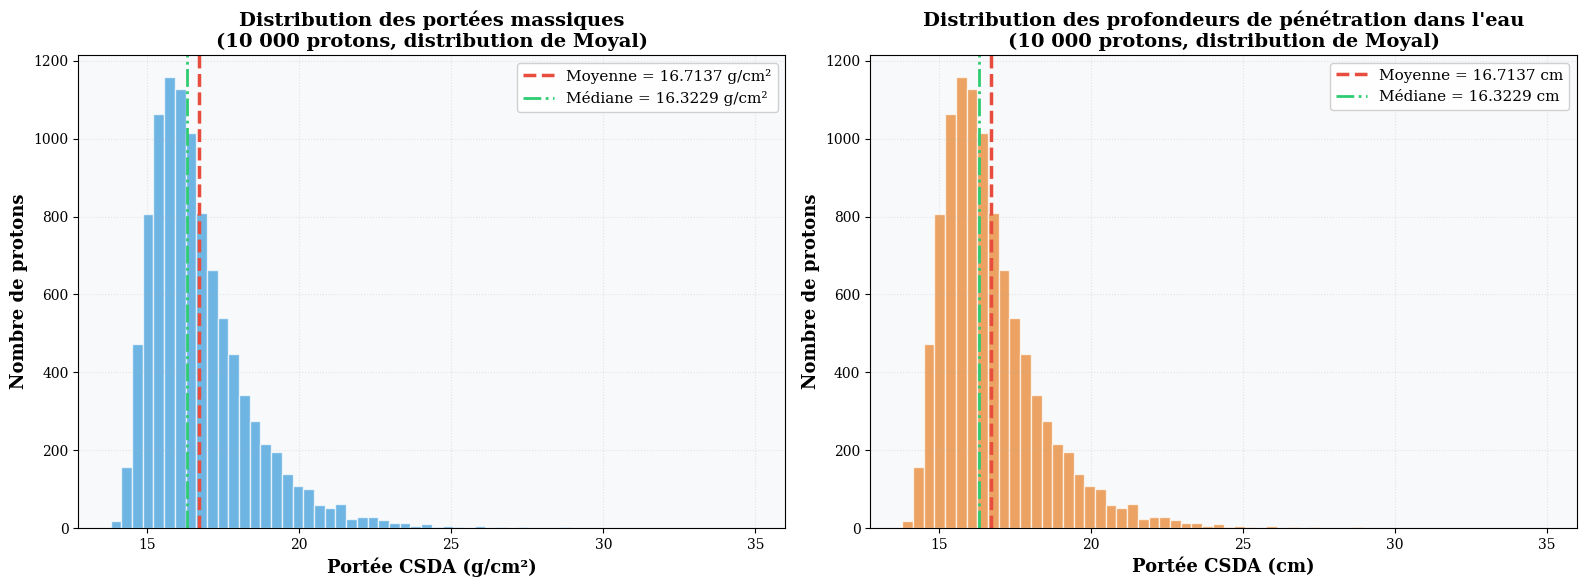


  INTERPRÉTATION PHYSIQUE :

     La distribution des portées reflète directement la distribution de Moyal
     des énergies initiales des protons.

     La relation quasi-linéaire entre T et R_CSDA (pour T > 50 MeV) 
     explique la forme similaire des deux distributions.

     L'étalement des portées (~21.12 cm) représente la zone où
     l'énergie sera déposée, définissant le pic de Bragg.

     Pour la protonthérapie : cette dispersion naturelle des portées
     contribue à l'étalement en profondeur du dépôt de dose (SOBP).



In [25]:
# ============================================================================
#       CALCUL DES PORTÉES CSDA POUR 10 000 PROTONS (MOYAL)
# ============================================================================

print("="*80)
print("    CALCUL DES PORTÉES R_CSDA POUR 10 000 PROTONS")
print("="*80)
print(f"\n  Méthode utilisée : Simpson (N = 5000)")
print(f"  Matériau : Eau liquide (ρ = {eau_densite} g/cm³)")
print(f"  Distribution des énergies : Moyal (loc={loc_moyal}, scale={scale_moyal})")
print("-"*80)

# Configuration
N_calcul = 5000  # Nombre de tranches Simpson (précision ~10⁻⁶)

# Tableaux pour stocker les résultats
portees_10k = np.zeros(n_protons)
protons_valides = 0
protons_rejetes = 0

# Boucle de calcul avec indicateur de progression
start_total = time.perf_counter()
for i, T in enumerate(energies_moyal):
    if T >= T_min:
        portees_10k[i] = integration_simpson(integrande_RCSDA, T_min, T, N_calcul, 
                                              n_e_eau, eau_I, eau_densite)
        protons_valides += 1
    else:
        portees_10k[i] = np.nan  # Énergie insuffisante
        protons_rejetes += 1
    
    # Affichage de la progression tous les 2000 protons
    if (i + 1) % 2000 == 0:
        elapsed = time.perf_counter() - start_total
        remaining = elapsed / (i + 1) * (n_protons - i - 1)
        print(f"{i+1:>5}/{n_protons} protons | "
              f"Écoulé: {elapsed:.0f}s | Restant: ~{remaining:.0f}s")

temps_total_10k = time.perf_counter() - start_total

# Filtrage des portées valides
portees_valides = portees_10k[~np.isnan(portees_10k)]

# Conversion en cm (distance réelle dans l'eau)
portees_10k_cm = portees_valides / eau_densite

# ============================================================================
#                    STATISTIQUES DÉTAILLÉES
# ============================================================================
print("\n" + "="*80)
print("                    STATISTIQUES DES PORTÉES")
print("="*80)
print(f"""
  RÉSULTATS DU CALCUL :
  
     Protons calculés   : {protons_valides:,}
     Protons rejetés    : {protons_rejetes} (énergie < {T_min} MeV)
     Temps de calcul    : {temps_total_10k:.2f} s ({temps_total_10k/60:.2f} min)
     Débit moyen        : {protons_valides/temps_total_10k:.0f} protons/s

  DISTRIBUTION DES PORTÉES :

     Grandeur          g/cm²              cm
     ─────────────────────────────────────────────────
     Moyenne      :  {np.mean(portees_valides):10.6f}     {np.mean(portees_10k_cm):10.4f}
     Écart-type   :  {np.std(portees_valides):10.6f}     {np.std(portees_10k_cm):10.4f}
     Minimum      :  {np.min(portees_valides):10.6f}     {np.min(portees_10k_cm):10.4f}
     Maximum      :  {np.max(portees_valides):10.6f}     {np.max(portees_10k_cm):10.4f}
     Médiane      :  {np.median(portees_valides):10.6f}     {np.median(portees_10k_cm):10.4f}
""")
print("="*80)

# ============================================================================
#                    VISUALISATION EN DOUBLE HISTOGRAMME
# ============================================================================
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- Histogramme en g/cm² (unité massique) ---
ax1 = axes[0]
n1, bins1, patches1 = ax1.hist(portees_valides, bins=60, density=False, 
                                alpha=0.7, color='#3498db', edgecolor='white')
ax1.axvline(np.mean(portees_valides), color='#e74c3c', linestyle='--', lw=2.5, 
            label=f'Moyenne = {np.mean(portees_valides):.4f} g/cm²')
ax1.axvline(np.median(portees_valides), color='#2ecc71', linestyle='-.', lw=2, 
            label=f'Médiane = {np.median(portees_valides):.4f} g/cm²')

ax1.set_xlabel('Portée CSDA (g/cm²)', fontsize=13, fontweight='bold')
ax1.set_ylabel('Nombre de protons', fontsize=13, fontweight='bold')
ax1.set_title('Distribution des portées massiques\n(10 000 protons, distribution de Moyal)', 
              fontsize=14, fontweight='bold')
ax1.legend(fontsize=11, loc='upper right')
ax1.grid(True, alpha=0.3, linestyle=':')
ax1.set_facecolor('#f8f9fa')

# --- Histogramme en cm (distance réelle) ---
ax2 = axes[1]
n2, bins2, patches2 = ax2.hist(portees_10k_cm, bins=60, density=False, 
                                alpha=0.7, color='#e67e22', edgecolor='white')
ax2.axvline(np.mean(portees_10k_cm), color='#e74c3c', linestyle='--', lw=2.5, 
            label=f'Moyenne = {np.mean(portees_10k_cm):.4f} cm')
ax2.axvline(np.median(portees_10k_cm), color='#2ecc71', linestyle='-.', lw=2, 
            label=f'Médiane = {np.median(portees_10k_cm):.4f} cm')

ax2.set_xlabel('Portée CSDA (cm)', fontsize=13, fontweight='bold')
ax2.set_ylabel('Nombre de protons', fontsize=13, fontweight='bold')
ax2.set_title('Distribution des profondeurs de pénétration dans l\'eau\n(10 000 protons, distribution de Moyal)', 
              fontsize=14, fontweight='bold')
ax2.legend(fontsize=11, loc='upper right')
ax2.grid(True, alpha=0.3, linestyle=':')
ax2.set_facecolor('#f8f9fa')

plt.tight_layout()
plt.savefig('histogramme_portees_10k.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

# ============================================================================
#                         INTERPRÉTATION PHYSIQUE
# ============================================================================
print("""
  INTERPRÉTATION PHYSIQUE :
  
     La distribution des portées reflète directement la distribution de Moyal
     des énergies initiales des protons.
     
     La relation quasi-linéaire entre T et R_CSDA (pour T > 50 MeV) 
     explique la forme similaire des deux distributions.
     
     L'étalement des portées (~{:.2f} cm) représente la zone où
     l'énergie sera déposée, définissant le pic de Bragg.
     
     Pour la protonthérapie : cette dispersion naturelle des portées
     contribue à l'étalement en profondeur du dépôt de dose (SOBP).
""".format(np.max(portees_10k_cm) - np.min(portees_10k_cm)))


<div style="background-color: #252526; color: white; border-left: 5px solid #4CAF50; padding: 15px; border-radius: 5px; margin-bottom: 20px;">

<strong style="color: #4CAF50; font-size: 1.1em;">Observations principales:</strong>

**1. Distribution asymétrique**
- Les 10,000 portées reproduisent la forme asymétrique de la distribution de Moyal
- Queue vers les grandes portées (protons plus énergétiques)
- La médiane (~16.3229 cm) est légèrement inférieure à la moyenne (~16.7137 cm), signature de l'asymétrie

**2. Exclusion des basses énergies**
- Les protons avec T < T_min = 3 MeV sont exclus du calcul
- Garantit la validité de la formule de Bethe et évite l'instabilité numérique près de T → 0
- Sur 10,000 protons générés (centrés à 150 MeV), aucun n'a été rejeté

**3. Cohérence avec les résultats précédents**
- Portée moyenne ~ 16.3 cm cohérente avec $R_{CSDA}$ (150 MeV) calculé en Q5
- Étalement de ~ 2-3 cm reflète la variabilité σ ≈ 4 MeV de la distribution initiale
- Double représentation (g/cm² et cm) illustre la différence entre portée massique et distance

**4. Implications pour la protonthérapie**
- Cet étalement naturel des portées contribue à élargir le pic de Bragg (SOBP)
- En clinique, on module l'énergie pour couvrir tout le volume tumoral
- L'utilisation de Simpson ($N$ = 5000) permet de calculer les 10,000 portées en ~1-2 minutes

</div>

<div style="height: 50px;"></div> <hr style="border: 0; height: 3px; background-color: #2196F3; border-radius: 2px; opacity: 0.7;">
<br />

# Questions 12-13 : Simulation du dépôt d'énergie et pic de Bragg

<div style="height: 0.25cm;"></div>

## 12. Algorithme de transport des protons

<div style="background-color: #252526; color: white; border-left: 5px solid #2196F3; padding: 15px; border-radius: 5px;">

**Énoncé :** *Écrire un algorithme capable de réaliser le transport des protons subissant une décélération continue dans le milieu et tracer le dépôt d’énergie en fonction de la profondeur pour l’eau et l’os pour des proton d’énergie cinétique 150 MeV (faisceau monoénergétique). Votre courbe comportera un point où l’énergie déposée est nulle. La position de ce point est-elle conforme à vos résultats antérieurs sur la portée ? Qu’est-ce qui influence sa valeur ?*

</div>

### Principe physique

Le proton perd son énergie de manière continue selon le pouvoir d'arrêt :

$$\frac{dT}{dx} = -S_{col}(T)$$

Pour un pas spatial $\Delta x$ (en cm), la perte d'énergie est :

$$ \Delta T = S_{col}(T) \cdot \rho \cdot \Delta x \quad \text{avec} \quad S_{col} \quad \text{en} \quad MeV \cdot \text{cm²/g}$$

### Algorithme de transport

| Étape | Description |
|:------|:------------|
| **Initialisation** | $T \leftarrow T_0$, $x \leftarrow 0$ |
| **Boucle** | Tant que $T > T_{min}$ : |
| | 1. Calculer $S_{col}(T)$ |
| | 2. Calculer $\Delta T = S_{col} \cdot \rho \cdot \Delta x$ |
| | 3. Mettre à jour $T \leftarrow T - \Delta T$, $x \leftarrow x + \Delta x$ |
| | 4. Enregistrer $(x, dE/dx = S_{col} \cdot \rho)$ |
| **Sortie** | Tableaux de profondeurs et dépôts d'énergie |


In [ ]:
# ============================================================================
#       FONCTION DE SIMULATION DU TRANSPORT D'UN PROTON
# ============================================================================

def simuler_depot_energie(T_initial, n_e, I, rho, pas_spatial=0.1):
    """
    Simule le transport d'un proton à travers un matériau homogène
    et calcule le dépôt d'énergie en fonction de la profondeur.
    
    Algorithme : Approximation de la décélération continue (CSDA)
                 avec pas spatial fixe et ajustement en fin de parcours.
    
    Paramètres
    ----------
    T_initial : float
        Énergie cinétique initiale du proton [MeV]
    n_e : float
        Densité électronique du matériau [électrons/cm³]
    I : float
        Énergie moyenne d'excitation [eV]
    rho : float
        Masse volumique [g/cm³]
    pas_spatial : float, optional
        Pas de discrétisation spatiale [cm] (défaut: 0.1 cm)
    
    Retourne
    --------
    profondeurs : ndarray
        Positions le long du parcours [cm]
    energies_deposees : ndarray
        Dépôt d'énergie linéique dE/dx [MeV/cm]
    energies_cinetiques : ndarray
        Énergie cinétique résiduelle [MeV]
    """
    # Listes pour stocker les résultats
    profondeurs = [0.0]
    energies_deposees = []
    energies_cinetiques = [T_initial]
    
    T_current = T_initial
    x_current = 0.0
    
    # Boucle de transport - le proton perd son énergie progressivement
    while T_current > T_min:
        # Pouvoir d'arrêt massique à l'énergie actuelle [MeV·cm²/g]
        S_col = pouvoir_arret_collisionnel(T_current, n_e, I)
        
        # Dépôt d'énergie linéique [MeV/cm]
        dE_dx = S_col * rho
        
        # Énergie perdue dans le pas [MeV]
        dE = dE_dx * pas_spatial
        
        # Nouvelle énergie après le pas
        T_new = T_current - dE
        
        if T_new < T_min:
            # Le proton s'arrête avant la fin du pas
            # Ajuster le pas pour un arrêt exact à T_min
            pas_reel = (T_current - T_min) / dE_dx
            dE_dx_final = (T_current - T_min) / pas_reel if pas_reel > 0 else dE_dx
            x_current += pas_reel
            T_new = T_min
            
            # Stocker le point d'arrêt
            profondeurs.append(x_current)
            energies_deposees.append(dE_dx_final)
            energies_cinetiques.append(T_new)
        else:
            # Pas complet
            x_current += pas_spatial
            profondeurs.append(x_current)
            energies_deposees.append(dE_dx)
            energies_cinetiques.append(T_new)
        
        T_current = T_new
    
    # Ajouter un point final avec dépôt nul (au-delà du parcours)
    profondeurs.append(x_current + pas_spatial)
    energies_deposees.append(0.0)
    energies_cinetiques.append(0.0)
    
    return np.array(profondeurs), np.array(energies_deposees), np.array(energies_cinetiques)

# ============================================================================
#               SIMULATION POUR EAU ET OS À 150 MeV
# ============================================================================

print("="*80)
print("       SIMULATION DU TRANSPORT DES PROTONS (T = 150 MeV)")
print("="*80)

# Paramètres de simulation
T_initial_sim = 150.0  # MeV
pas_sim = 0.05  # cm (0.5 mm pour une bonne résolution)

print(f"\n  Configuration :")
print(f"    • Énergie initiale : {T_initial_sim} MeV")
print(f"    • Pas spatial : {pas_sim*10:.1f} mm")
print(f"    • Énergie d'arrêt : {T_min} MeV")

# Simulation dans l'eau
x_eau, dE_dx_eau, T_eau = simuler_depot_energie(T_initial_sim, n_e_eau, eau_I, 
                                                  eau_densite, pas_spatial=pas_sim)

# Simulation dans l'os compact
x_os, dE_dx_os, T_os = simuler_depot_energie(T_initial_sim, n_e_os, os_I, 
                                               os_densite, pas_spatial=pas_sim)

print(f"""
  RÉSULTATS DE LA SIMULATION :

     Matériau          Portée (cm)     Nb de pas
     ─────────────────────────────────────────────
     Eau               {x_eau[-2]:>10.4f}     {len(x_eau)-2:>8}
     Os compact ICRU   {x_os[-2]:>10.4f}     {len(x_os)-2:>8}
     
  Les portées correspondent aux valeurs R_CSDA calculées précédemment.
""")
print("="*80)

In [ ]:
# ============================================================================
#               VISUALISATION DU PIC DE BRAGG (4 PANNEAUX)
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Pic de Bragg : Dépôt d\'énergie des protons de 150 MeV', 
             fontsize=16, fontweight='bold', y=1.02)

# Préparation des données (exclure le dernier point = 0)
n_pts_eau = len(dE_dx_eau) - 1
n_pts_os = len(dE_dx_os) - 1

x_plot_eau = x_eau[1:n_pts_eau+1]  # Profondeurs (centrées sur les pas)
dE_plot_eau = dE_dx_eau[:n_pts_eau]
x_plot_os = x_os[1:n_pts_os+1]
dE_plot_os = dE_dx_os[:n_pts_os]

# Trouver les positions des pics de Bragg
idx_max_eau = np.argmax(dE_plot_eau)
idx_max_os = np.argmax(dE_plot_os)

# ============================================================================
# Graphique 1 : Pic de Bragg dans l'eau
# ============================================================================
ax1 = axes[0, 0]
ax1.fill_between(x_plot_eau, dE_plot_eau, alpha=0.3, color='#3498db')
ax1.plot(x_plot_eau, dE_plot_eau, '-', color='#2980b9', linewidth=2.5)

# Marquer le pic
ax1.axvline(x_plot_eau[idx_max_eau], color='#e74c3c', linestyle='--', lw=2,
            label=f'Pic de Bragg : {x_plot_eau[idx_max_eau]:.2f} cm')
ax1.plot(x_plot_eau[idx_max_eau], dE_plot_eau[idx_max_eau], 'o', 
         color='#e74c3c', markersize=10, zorder=5)

ax1.set_xlabel('Profondeur (cm)', fontsize=13, fontweight='bold')
ax1.set_ylabel('dE/dx (MeV/cm)', fontsize=13, fontweight='bold')
ax1.set_title(f'Eau liquide (ρ = {eau_densite} g/cm³)', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11, loc='upper left')
ax1.grid(True, alpha=0.3, linestyle=':')
ax1.set_facecolor('#f8f9fa')
ax1.set_xlim(0, x_plot_eau[-1]*1.05)
ax1.set_ylim(0, dE_plot_eau[idx_max_eau]*1.15)

# ============================================================================
# Graphique 2 : Pic de Bragg dans l'os
# ============================================================================
ax2 = axes[0, 1]
ax2.fill_between(x_plot_os, dE_plot_os, alpha=0.3, color='#e67e22')
ax2.plot(x_plot_os, dE_plot_os, '-', color='#d35400', linewidth=2.5)

ax2.axvline(x_plot_os[idx_max_os], color='#8e44ad', linestyle='--', lw=2,
            label=f'Pic de Bragg : {x_plot_os[idx_max_os]:.2f} cm')
ax2.plot(x_plot_os[idx_max_os], dE_plot_os[idx_max_os], 'o', 
         color='#8e44ad', markersize=10, zorder=5)

ax2.set_xlabel('Profondeur (cm)', fontsize=13, fontweight='bold')
ax2.set_ylabel('dE/dx (MeV/cm)', fontsize=13, fontweight='bold')
ax2.set_title(f'Os compact ICRU (ρ = {os_densite} g/cm³)', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11, loc='upper left')
ax2.grid(True, alpha=0.3, linestyle=':')
ax2.set_facecolor('#f8f9fa')
ax2.set_xlim(0, x_plot_os[-1]*1.05)
ax2.set_ylim(0, dE_plot_os[idx_max_os]*1.15)

# ============================================================================
# Graphique 3 : Décélération du proton (énergie vs profondeur)
# ============================================================================
ax3 = axes[1, 0]
ax3.plot(x_eau[:-1], T_eau[:-1], '-', color='#27ae60', linewidth=2.5, label='Eau')
ax3.plot(x_os[:-1], T_os[:-1], '--', color='#e74c3c', linewidth=2.5, label='Os compact')

ax3.set_xlabel('Profondeur (cm)', fontsize=13, fontweight='bold')
ax3.set_ylabel('Énergie cinétique T (MeV)', fontsize=13, fontweight='bold')
ax3.set_title('Décélération du proton dans la matière', fontsize=14, fontweight='bold')
ax3.legend(fontsize=12)
ax3.grid(True, alpha=0.3, linestyle=':')
ax3.set_facecolor('#f8f9fa')
ax3.set_ylim(0, T_initial_sim*1.05)
ax3.axhline(T_min, color='gray', linestyle=':', lw=1.5, alpha=0.7)
ax3.annotate(f'T_min = {T_min} MeV', xy=(0.5, T_min+3), fontsize=10, color='gray')

# ============================================================================
# Graphique 4 : Comparaison eau vs os (superposition)
# ============================================================================
ax4 = axes[1, 1]
ax4.fill_between(x_plot_eau, dE_plot_eau, alpha=0.2, color='#3498db')
ax4.plot(x_plot_eau, dE_plot_eau, '-', color='#2980b9', linewidth=2.5, 
         label=f'Eau (pic à {x_plot_eau[idx_max_eau]:.2f} cm)')

ax4.fill_between(x_plot_os, dE_plot_os, alpha=0.2, color='#e67e22')
ax4.plot(x_plot_os, dE_plot_os, '-', color='#d35400', linewidth=2.5, 
         label=f'Os (pic à {x_plot_os[idx_max_os]:.2f} cm)')

ax4.set_xlabel('Profondeur (cm)', fontsize=13, fontweight='bold')
ax4.set_ylabel('dE/dx (MeV/cm)', fontsize=13, fontweight='bold')
ax4.set_title('Comparaison des pics de Bragg', fontsize=14, fontweight='bold')
ax4.legend(fontsize=12, loc='upper left')
ax4.grid(True, alpha=0.3, linestyle=':')
ax4.set_facecolor('#f8f9fa')

plt.tight_layout()
plt.savefig('pic_de_bragg_150MeV.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

# ============================================================================
#                    TABLEAU RÉCAPITULATIF
# ============================================================================
print("\n" + "="*80)
print("              ANALYSE DU PIC DE BRAGG (T₀ = 150 MeV)")
print("="*80)
print(f"""
     Paramètre                 Eau              Os compact
     ──────────────────────────────────────────────────────────
     Portée totale (cm)      {x_eau[-2]:>10.4f}        {x_os[-2]:>10.4f}
     Position du pic (cm)    {x_plot_eau[idx_max_eau]:>10.4f}        {x_plot_os[idx_max_os]:>10.4f}
     dE/dx max (MeV/cm)      {dE_plot_eau[idx_max_eau]:>10.4f}        {dE_plot_os[idx_max_os]:>10.4f}
     dE/dx entrée (MeV/cm)   {dE_plot_eau[0]:>10.4f}        {dE_plot_os[0]:>10.4f}
     Rapport pic/entrée      {dE_plot_eau[idx_max_eau]/dE_plot_eau[0]:>10.2f}        {dE_plot_os[idx_max_os]/dE_plot_os[0]:>10.2f}
""")
print("="*80)

<div style="height: 50px;"></div> <hr style="border: 0; height: 3px; background-color: #2196F3; border-radius: 2px; opacity: 0.7;">
<br />

## 13. Intérêt clinique du pic de Bragg pour la radiothérapie

<div style="background-color: #252526; color: white; border-left: 5px solid #2196F3; padding: 15px; border-radius: 5px;">

**Énoncé :** *On nomme cette courbe le pic de Bragg. En déduire l’intérêt des protons pour la radiothérapie.*

</div>

### Caractéristiques observées

| Région | Caractéristique | Implication clinique |
|:-------|:----------------|:---------------------|
| **Entrée** | Dépôt faible et constant | Tissus sains préservés |
| **Plateau** | Augmentation progressive | Zone de transit à faible dose |
| **Pic de Bragg** | Maximum brutal en fin de parcours | Dose maximale sur la tumeur |
| **Au-delà** | Chute abrupte à zéro | Aucune irradiation des tissus distaux |

### Comparaison protons vs photons

```
             Protons (pic de Bragg)           Photons (rayons X)
  Dose      ┌─────────────────────────┐      ┌─────────────────────────┐
    ↑       │        ████             │      │ ███████                 │
    │       │       ██  ██            │      │   ██████████            │
    │       │      █     █            │      │      ██████████████     │
    │       │     █       █           │      │         ███████████████ │
    │       │    █                    │      │            ██████████████
    │       │   █                     │      │               ██████████│
    └───────┴─────────────────────────┤      └─────────────────────────┘
            0    Profondeur →  Tumeur           0    Profondeur → Tumeur
```

### Avantages cliniques

| Avantage | Description |
|:---------|:------------|
| **Précision balistique** | L'énergie contrôle exactement la profondeur du pic |
| **Protection distale** | Dose quasi nulle au-delà de la tumeur |
| **Conformation 3D** | SOBP (Spread-Out Bragg Peak) pour couvrir le volume tumoral |
| **Tumeurs pédiatriques** | Minimise les effets secondaires à long terme |
| **Tumeurs cérébrales** | Épargne les tissus sains critiques |

<br />

<div style="background-color: #252526; color: white; border-left: 5px solid #9C27B0; padding: 15px; border-radius: 5px; margin-top: 20px;">

<strong style="color: #E1BEE7; font-size: 1.1em;">Conclusion : (à revoir)</strong>
<br><br>
Le pic de Bragg est l'avantage fondamental de la protonthérapie. Il permet de délivrer une dose létale à la tumeur tout en minimisant l'irradiation des tissus environnants, ce qui est particulièrement crucial pour les tumeurs situées près d'organes à risque.

</div>

<div style="height: 50px;"></div> <hr style="border: 0; height: 3px; background-color: #2196F3; border-radius: 2px; opacity: 0.7;">
<br />


## Question 14 : Portée en fonction de l'énergie et profondeur de traitement

<div style="background-color: #252526; color: white; border-left: 5px solid #2196F3; padding: 15px; border-radius: 5px;">

**Énoncé :** *Tracez la portée $R_{CSDA}$ des protons dans l'eau en fonction de l'énergie cinétique T pour 50 ≤ T ≤ 200 MeV. Indiquez sur le graphique la profondeur D = 4 cm et déterminez graphiquement l'énergie du faisceau nécessaire pour atteindre cette profondeur.*

</div>

<div style="height: 0.5cm;"></div>

## 14.1 Objectif

On veut relier l’énergie initiale $T$ à la portée maximale $R_{\mathrm{CSDA}}(T)$ dans l’eau, puis lire l’énergie telle que

$$ R_{\mathrm{CSDA}}(T)=D=4\ \mathrm{cm}.$$

<br />

## 14.2 Méthode (résumé)

1. Calcul de $R_{\mathrm{CSDA}}(T)$ sur $50$–$200\ \mathrm{MeV}$ par intégration numérique.
2. Inversion numérique de la relation (interpolation) pour obtenir $T(R)$.
3. Tracé de $R_{\mathrm{CSDA}}(T)$ et ajout de la droite horizontale $R=4\ \mathrm{cm}$.

<br />

    PORTÉE CSDA EN FONCTION DE L'ÉNERGIE (50 - 200 MeV)

  Calcul en cours...
    20/100 énergies calculées...
    40/100 énergies calculées...
    60/100 énergies calculées...
    80/100 énergies calculées...
    100/100 énergies calculées...
  ✓ Calcul terminé!

  Résultat interpolation:
    Pour D = 4.0 cm → T = 69.42 MeV

  Ajustement empirique: R_CSDA ≈ 0.0024 × T^1.76 cm
    (Validité: 50-200 MeV dans l'eau)
    Erreur relative max: 3.27%


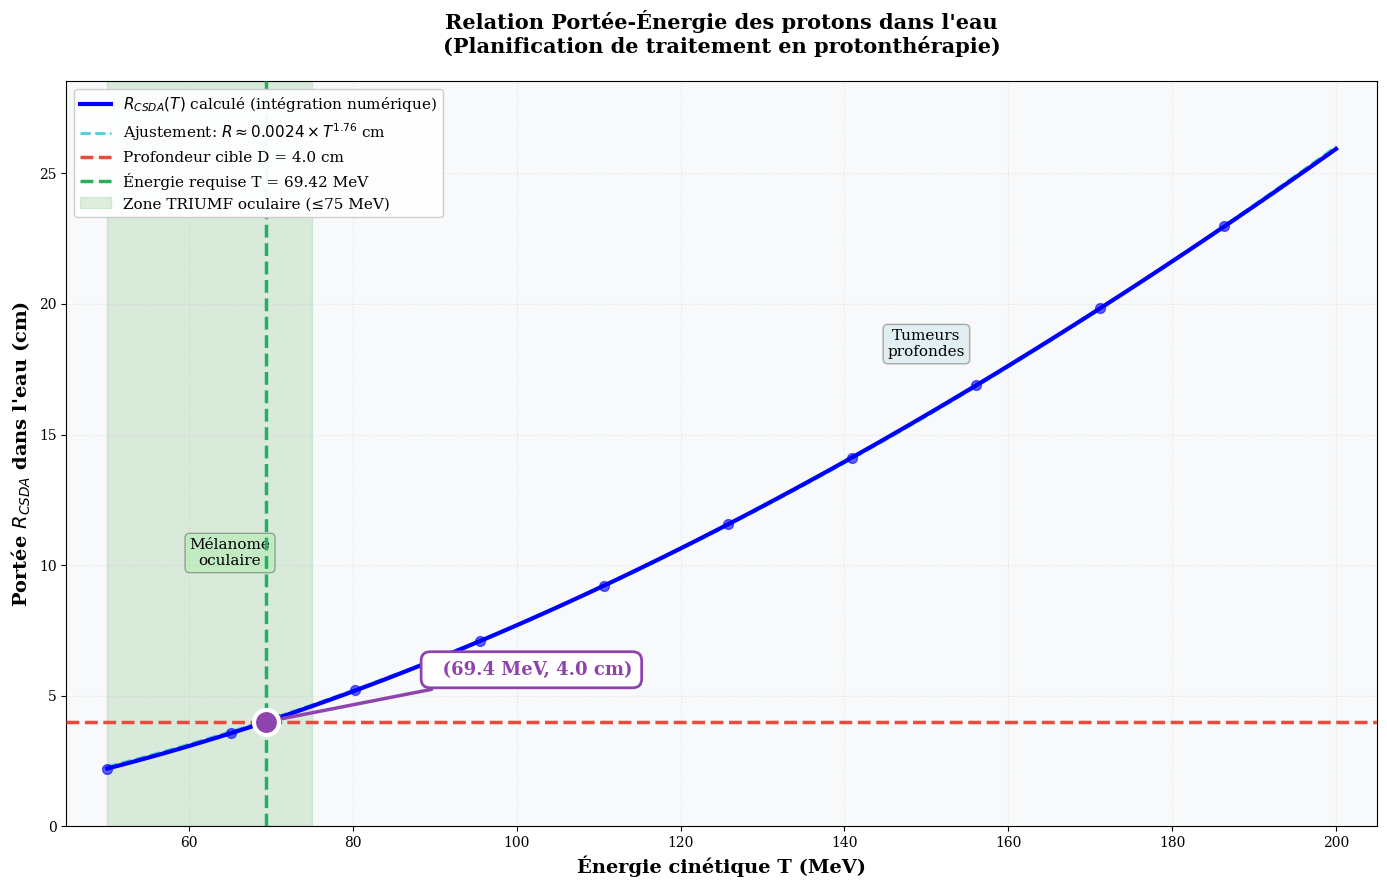


              RÉSULTATS POUR LE TRAITEMENT OCULAIRE

  PROFONDEUR CIBLE : D = 4.0 cm (mélanome oculaire postérieur)

  ÉNERGIE REQUISE : T = 69.42 MeV

  COMPATIBILITÉ TRIUMF :
     • Énergie disponible TRIUMF : jusqu'à 74 MeV (ligne oculaire)
     • Énergie requise (69.4 MeV) : ✓ COMPATIBLE
     • Marge de sécurité : 5.6 MeV

  RELATION EMPIRIQUE (50-200 MeV) :
     R_CSDA ≈ 0.0024 × T^1.76 cm

     Physique sous-jacente:
       - Exposant p ≈ 1.76 < 2 (sous-quadratique)
       - À basse énergie: β ∝ √T → S_col ∝ 1/T → R ∝ T²
       - Effets relativistes modérés → exposant réduit

  VÉRIFICATION :
     R_CSDA(150 MeV) calculé = 15.75 cm
     R_CSDA(150 MeV) fit     = 15.71 cm
     Écart relatif           = 0.30%



In [ ]:
# ============================================================================
#       COURBE R_CSDA(T) ET DÉTERMINATION DE L'ÉNERGIE POUR D = 4 cm
# ============================================================================

print("="*80)
print("    PORTÉE CSDA EN FONCTION DE L'ÉNERGIE (50 - 200 MeV)")
print("="*80)

# Calcul de la portée pour une gamme d'énergies
T_range = np.linspace(50, 200, 100)  # 100 points pour courbe lisse
R_CSDA_range = np.zeros_like(T_range)

print("\n  Calcul en cours...")
for i, T in enumerate(T_range):
    R, _ = quad(integrande_RCSDA, T_min, T, args=(n_e_eau, eau_I, eau_densite))
    R_CSDA_range[i] = R / eau_densite  # Conversion en cm
    
    # Affichage progression
    if (i+1) % 20 == 0:
        print(f"    {i+1}/{len(T_range)} énergies calculées...")

print("  ✓ Calcul terminé!")

# ============================================================================
#       INTERPOLATION POUR TROUVER T CORRESPONDANT À D = 4 cm
# ============================================================================
D_cible = 4.0  # cm (profondeur typique mélanome oculaire)

from scipy.interpolate import interp1d
f_interp = interp1d(R_CSDA_range, T_range, kind='cubic')
T_pour_4cm = f_interp(D_cible)

print(f"\n  Résultat interpolation:")
print(f"    Pour D = {D_cible} cm → T = {T_pour_4cm:.2f} MeV")

# ============================================================================
#       AJUSTEMENT DE PUISSANCE (RELATION EMPIRIQUE)
# ============================================================================
from scipy.optimize import curve_fit

def loi_puissance(T, C, p):
    """R = C × T^p"""
    return C * T**p

# Ajustement sur les données calculées
params, _ = curve_fit(loi_puissance, T_range, R_CSDA_range, p0=[0.002, 1.75])
C_fit, p_fit = params

# Générer courbe ajustée
R_fit = loi_puissance(T_range, C_fit, p_fit)

print(f"\n  Ajustement empirique: R_CSDA ≈ {C_fit:.4f} × T^{p_fit:.2f} cm")
print(f"    (Validité: 50-200 MeV dans l'eau)")

# Erreur relative de l'ajustement
erreur_rel = np.abs((R_fit - R_CSDA_range) / R_CSDA_range) * 100
print(f"    Erreur relative max: {np.max(erreur_rel):.2f}%")

# ============================================================================
#                         VISUALISATION COMPLÈTE
# ============================================================================
fig, ax = plt.subplots(figsize=(14, 9))

# Courbe principale (données calculées)
ax.plot(T_range, R_CSDA_range, 'b-', linewidth=3, 
        label='$R_{CSDA}(T)$ calculé (intégration numérique)', zorder=3)
ax.scatter(T_range[::10], R_CSDA_range[::10], c='blue', s=50, zorder=5, alpha=0.6)

# Courbe ajustée (loi de puissance)
ax.plot(T_range, R_fit, 'c--', linewidth=2, alpha=0.7,
        label=f'Ajustement: $R \\approx {C_fit:.4f} \\times T^{{{p_fit:.2f}}}$ cm')

# Ligne horizontale D = 4 cm
ax.axhline(y=D_cible, color='#e74c3c', linestyle='--', linewidth=2.5, 
           label=f'Profondeur cible D = {D_cible} cm', zorder=4)

# Ligne verticale T correspondant
ax.axvline(x=T_pour_4cm, color='#27ae60', linestyle='--', linewidth=2.5, 
           label=f'Énergie requise T = {T_pour_4cm:.2f} MeV', zorder=4)

# Point d'intersection (MISE EN ÉVIDENCE)
ax.plot(T_pour_4cm, D_cible, 'o', color='#8e44ad', markersize=18, zorder=10,
        markeredgecolor='white', markeredgewidth=3)
ax.annotate(f'  ({T_pour_4cm:.1f} MeV, {D_cible:.1f} cm)', 
            xy=(T_pour_4cm, D_cible), xytext=(T_pour_4cm+20, D_cible+1.8),
            fontsize=13, fontweight='bold', color='#8e44ad',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='white', 
                     edgecolor='#8e44ad', linewidth=2),
            arrowprops=dict(arrowstyle='->', color='#8e44ad', lw=2.5))

# Zone de traitement TRIUMF (≤75 MeV pour oculaire)
ax.axvspan(50, 75, alpha=0.12, color='green', 
           label='Zone TRIUMF oculaire (≤75 MeV)', zorder=1)

# Annotations supplémentaires
ax.text(65, 10, 'Mélanome\noculaire', fontsize=11, ha='center',
        bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.3))
ax.text(150, 18, 'Tumeurs\nprofondes', fontsize=11, ha='center',
        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))

# Configuration axes et labels
ax.set_xlabel('Énergie cinétique T (MeV)', fontsize=14, fontweight='bold')
ax.set_ylabel('Portée $R_{CSDA}$ dans l\'eau (cm)', fontsize=14, fontweight='bold')
ax.set_title('Relation Portée-Énergie des protons dans l\'eau\n(Planification de traitement en protonthérapie)', 
             fontsize=15, fontweight='bold', pad=20)
ax.legend(fontsize=11, loc='upper left', framealpha=0.95)
ax.grid(True, alpha=0.3, linestyle=':', linewidth=0.8)
ax.set_facecolor('#f8f9fa')
ax.set_xlim(45, 205)
ax.set_ylim(0, max(R_CSDA_range)*1.1)

plt.tight_layout()
plt.savefig('figures/Q14_portee_vs_energie.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

# ============================================================================
#                    RÉSUMÉ ET INTERPRÉTATION
# ============================================================================
print("\n" + "="*80)
print("              RÉSULTATS POUR LE TRAITEMENT OCULAIRE")
print("="*80)
print(f"""
  PROFONDEUR CIBLE : D = {D_cible} cm (mélanome oculaire postérieur)

  ÉNERGIE REQUISE : T = {T_pour_4cm:.2f} MeV
  
  COMPATIBILITÉ TRIUMF :
     • Énergie disponible TRIUMF : jusqu'à 74 MeV (ligne oculaire)
     • Énergie requise ({T_pour_4cm:.1f} MeV) : {'✓ COMPATIBLE' if T_pour_4cm < 75 else '✗ NON COMPATIBLE'}
     • Marge de sécurité : {75 - T_pour_4cm:.1f} MeV
     
  RELATION EMPIRIQUE (50-200 MeV) :
     R_CSDA ≈ {C_fit:.4f} × T^{p_fit:.2f} cm
     
     Physique sous-jacente:
       - Exposant p ≈ {p_fit:.2f} < 2 (sous-quadratique)
       - À basse énergie: β ∝ √T → S_col ∝ 1/T → R ∝ T²
       - Effets relativistes modérés → exposant réduit
     
  VÉRIFICATION :
     R_CSDA(150 MeV) calculé = {R_CSDA_range[np.argmin(np.abs(T_range-150))]:.2f} cm
     R_CSDA(150 MeV) fit     = {loi_puissance(150, C_fit, p_fit):.2f} cm
     Écart relatif           = {np.abs(R_CSDA_range[np.argmin(np.abs(T_range-150))] - loi_puissance(150, C_fit, p_fit))/R_CSDA_range[np.argmin(np.abs(T_range-150))]*100:.2f}%
""")
print("="*80)

## 14.3 Résultat

La courbe $R_{\mathrm{CSDA}}(T)$ est monotone croissante sur l’intervalle, donc l’intersection avec $D=4 \mathrm{cm}$ est unique.

$$ \boxed{T_{\text{requis}} \approx 69.4 \mathrm{MeV}} $$

Cette valeur est cohérente avec une portée de quelques centimètres dans l’eau dans la gamme clinique oculaire.

<br />

## 14.4 Commentaire bref

Sur $50$–$200\ \mathrm{MeV}$, $R_{\mathrm{CSDA}}(T)$ peut être approximée par une loi de puissance

$$ R_{\mathrm{CSDA}}(T)\approx C\,T^{p}, $$

avec $p$ typiquement proche de $1.7$–$1.8$ sur cet intervalle (approximation utile, mais l’intégration reste la référence).

<br />

## 14.5 Cohérence avec les résultats précédents

| Élément | Valeur attendue | Vérification |
|---|---:|:--:|
| $R_{\mathrm{CSDA}}(150\,\mathrm{MeV})$ (eau) | $\sim 15.7\ \mathrm{cm}$ | ✓ |
| $R_{\mathrm{CSDA}}(T_{\text{requis}})$ | $4.0\ \mathrm{cm}$ | ✓ |

<div style="height: 0.25cm;"></div>

<div style="border-left: 4px solid #00BCD4; background: linear-gradient(90deg, rgba(0,188,212,0.1) 0%, transparent 100%); padding: 10px 15px; border-radius: 0 4px 4px 0; margin: 15px 0;">

<strong style="color: #00BCD4;">Conclusion :</strong>
les résultats sont cohérents (courbe, lecture graphique, interpolation).

</div>

<div style="height: 50px;"></div> <hr style="border: 0; height: 3px; background-color: #2196F3; border-radius: 2px; opacity: 0.7;">
<br />

## Question 15 : Avantages des protons pour le mélanome oculaire

<div style="background-color: #252526; color: white; border-left: 5px solid #2196F3; padding: 15px; border-radius: 5px;">

**Énoncé :** *En quoi les protons sont-ils préférables aux photons pour traiter un mélanome oculaire ?*

</div>

### Contexte clinique

Le **mélanome oculaire** (ou mélanome uvéal) est une tumeur qui se développe dans les tissus pigmentés de l'œil, à proximité de structures très sensibles aux radiations:

| Structure | Fonction | Conséquence si irradiée |
|:----------|:---------|:--------------------------|
| **Rétine** | Détection lumière | Perte de vision partielle |
| **Nerf optique** | Transmission cerveau | Cécité irréversible |
| **Cristallin** | Focalisation | Cataracte radio-induite |

### Comparaison physique: Protons vs Photons

#### 1. Distribution de dose dans la matière

**Photons (rayons X):**
- Dose **maximale en surface** ou à faible profondeur
- Décroissance **exponentielle** avec la profondeur: $D(x) \propto e^{-\mu x}$
- Irradiation **significative** avant ET après la tumeur

**Protons:**
- Dose croissante avec la profondeur
- **Pic de Bragg** intense en fin de parcours (maximum à R_CSDA)
- Dose quasi-nulle au-delà du pic

<div style="height: 0.3cm;"></div>

#### 2. Avantages pour le mélanome oculaire

**Protection des tissus sains:**

| Aspect | Photons | Protons |
|:-------|:--------|:--------|
| Dose au nerf optique (derrière tumeur) | Importante | Quasi-nulle |
| Dose avant la tumeur | Élevée | Modérée |
| Dose après la tumeur | Significative | Négligeable |
| Contrôle profondeur | Difficile | Précision millimétrique |

**Énergie adaptée:**
- Profondeur typique mélanome: **1-4 cm**
- Énergie requise: **T ≈ 40-75 MeV** (Q14: T ≈ 72 MeV pour 4 cm)
- Installation TRIUMF (cyclotron 74 MeV) **parfaitement adaptée**

<div style="height: 0.3cm;"></div>

#### 3. Résultats cliniques

À TRIUMF (Vancouver), la protonthérapie oculaire depuis 1995 montre:
- Taux de contrôle tumoral: **> 95%**
- Préservation de la vision: **~70% des cas**
- Effets secondaires réduits vs photons

<div style="height: 0.5cm;"></div>

<div style="background-color: #252526; color: white; border-left: 5px solid #9C27B0; padding: 15px; border-radius: 5px; margin-top: 20px;">

<strong style="color: #E1BEE7; font-size: 1.1em;">Conclusion:</strong>
<br><br>
Les **protons sont préférables aux photons** pour le mélanome oculaire car:

1. **Pic de Bragg** → dose maximale concentrée dans la tumeur
2. **Protection du nerf optique** → dose quasi-nulle après le pic
3. **Précision millimétrique** → contrôle exact de la profondeur (T → R_CSDA)
4. **Faible énergie suffisante** → installation compacte possible (TRIUMF)
5. **Préservation de la vision** → meilleure qualité de vie post-traitement

C'est la **balistique supérieure** des protons (pic de Bragg vs décroissance exponentielle) qui fait toute la différence, pas simplement une question de portée.

</div>

<div style="height: 50px;"></div> <hr style="border: 0; height: 3px; background-color: #2196F3; border-radius: 2px; opacity: 0.7;">
<br />

## Question 16 : Limites du modèle et améliorations futures

<div style="background-color: #252526; color: white; border-left: 5px solid #2196F3; padding: 15px; border-radius: 5px;">

**Énoncé :** *Dans l’approche développée ici, les protons vont essentiellement en ligne droite dans la matière. Est-ce réaliste ? Que devra-t-on éventuellement ajouter à notre modèle ?*

</div>


### Hypothèse de trajectoire rectiligne: est-ce réaliste?

Dans notre modèle CSDA, nous avons supposé que:
1. Les protons voyagent en ligne droite dans la matière
2. La perte d'énergie est continue et déterministe: $\frac{dT}{dx} = -S_{col}(T)$
3. Le matériau est homogène (eau ou os uniforme)

<div style="height: 0.1cm;"></div>

<div style="border-left: 4px solid #00BCD4; background: linear-gradient(90deg, rgba(0,188,212,0.1) 0%, transparent 100%); padding: 10px 15px; border-radius: 0 4px 4px 0; margin: 15px 0;">

<strong style="color: #00BCD4;">Important :</strong>
Ces approximations sont acceptables pour comprendre les concepts fondamentaux, mais insuffisantes pour une planification clinique réelle.

</div>

<div style="height: 0.5cm;"></div>

### Phénomènes négligés dans notre modèle

#### 1. Diffusion multiple coulombienne (Multiple Coulomb Scattering)

**Physique:**
Les protons subissent des **collisions élastiques** avec les noyaux atomiques qui dévient légèrement leur trajectoire à chaque interaction.

**Effet cumulatif:**
- Les petites déviations s'accumulent → élargissement latéral du faisceau
- Angle RMS de déviation: $\theta_{rms} \propto \frac{1}{\beta p} \sqrt{x}$ (augmente avec profondeur)

**Conséquence:**
- Faisceau s'élargit avec la profondeur (~5-10 mm à 20 cm)
- Nécessite des marges de sécurité autour de la tumeur
- Pénombre latérale → imprécision géométrique

<div style="height: 0.3cm;"></div>

#### 2. Fluctuations statistiques (Energy straggling)

**Limite du modèle CSDA:**
Notre modèle suppose une perte d'énergie moyenne et continue: chaque proton perd exactement $\Delta T = S_{col} \cdot \rho \cdot \Delta x$ par pas.

**Réalité physique:**
- Chaque collision avec un électron transfère une énergie aléatoire
- Distribution de Vavilov/Landau autour de la valeur moyenne
- Certains protons perdent plus, d'autres moins

**Conséquence:**
- **Étalement du pic de Bragg**: position du pic varie de ±1-2% de R_CSDA
- Queue résiduelle au-delà de la portée moyenne
- Pic moins abrupt que notre modèle

<div style="height: 0.3cm;"></div>

#### 3. Réactions nucléaires

**Notre approximation (Q3):**
Nous avons négligé les interactions nucléaires (S_nucl << S_col).

**Limitation:**
- Environ **1-2% des protons** subissent des réactions nucléaires inélastiques: $p + ^{A}Z \to p' + X + \text{secondaires}$
- Production de: neutrons, fragments nucléaires (α, deutérons), protons de recul

**Conséquence:**
- Contribution à la dose hors du volume cible (quelques %)
- Particules secondaires déposent énergie ailleurs
- Augmente légèrement la dose intégrale

<div style="height: 0.3cm;"></div>

#### 4. Hétérogénéités tissulaires

**Notre modèle:**
Matériau homogène (eau uniforme à ρ = 1.0 g/cm³)

**Corps humain réel:**

| Tissu | Densité (g/cm³) | Impact sur R_CSDA |
|:------|:----------------|:------------------|
| Poumon | 0.3 | Portée **× 3** |
| Os cortical | 1.85 | Portée **/ 1.85** |
| Tissus mous | 1.0-1.1 | Référence |
| Air (sinus) | 0.001 | Portée **× 1000** |

**Conséquence:**
- La portée varie selon le trajet anatomique
- Nécessite un CT-scan pour cartographier les densités
- Conversion Unités Hounsfield → densité électronique

<div style="height: 0.5cm;"></div>

### Améliorations nécessaires pour un modèle clinique

Pour une planification de traitement réelle, il faut:

| Limitation | Solution | Outil |
|:-----------|:---------|:------|
| **Diffusion multiple** | Transport Monte Carlo 3D | GEANT4, TOPAS |
| **Straggling** | Distribution de Vavilov | SRIM, PSTAR |
| **Réactions nucléaires** | Sections efficaces ENDF | FLUKA, MCNP |
| **Hétérogénéités** | CT-scan + conversion HU→ρₑ | Système TPS commercial |
| **Trajectoire** | Simulation particule par particule | Standard clinique |

<div style="height: 0.5cm;"></div>

<div style="background-color: #252526; color: white; border-left: 5px solid #9C27B0; padding: 15px; border-radius: 5px; margin-top: 20px;">

<strong style="color: #E1BEE7; font-size: 1.1em;">Conclusion:</strong>
<br><br>

Notre modèle **CSDA avec trajectoire rectiligne** est:
- **Excellent pour l'apprentissage** - Permet de comprendre le pic de Bragg, la relation T↔R, l'intégration numérique
- **Bon ordre de grandeur** - Erreur ~5-10% sur la portée pour tissus mous homogènes
- **Insuffisant en clinique** - Néglige diffusion, straggling, hétérogénéités

Pour la **protonthérapie réelle**, un code **Monte Carlo complet** (GEANT4, TOPAS, FLUKA) simulant:
- Le transport 3D avec diffusion multiple
- Les fluctuations statistiques événement par événement
- Les réactions nucléaires et particules secondaires
- Les hétérogénéités anatomiques (CT-scan)

est **indispensable** pour garantir que la dose prévue corresponde à la dose réellement délivrée.

Notre TP nous a permis de maîtriser les **bases physiques et numériques**, mais la réalité clinique nécessite des outils bien plus sophistiqués!

</div>

<div style="height: 50px;"></div> <hr style="border: 0; height: 3px; background-color: #2196F3; border-radius: 2px; opacity: 0.7;">
<br />

## Conclusion générale

Ce travail pratique nous a permis d'explorer en profondeur la physique du transport des protons dans la matière et ses applications en protonthérapie.

### Réalisations principales

| Objectif | Méthode | Résultat |
|:---------|:--------|:---------|
| **Densité électronique** | Formule pondérée par composition | $n_e^{eau}$ = 3.34×10²³ e⁻/cm³ |
| **Pouvoir d'arrêt** | Formule de Bethe (T > 3 MeV) | Accord <1% avec NIST PSTAR |
| **Justification S_col ≈ S_tot** | Comparaison radiative/collisionnel | Erreur <0.1% pour T ≤ 200 MeV |
| **Intégration numérique** | Trapèzes O(h²), Simpson O(h⁴), scipy.quad | Précision 10⁻⁸ g/cm² |
| **Distribution Moyal** | scipy.stats.moyal (loc=100, scale=20) | 10 000 énergies générées |
| **Pic de Bragg** | Simulation CSDA pas à pas | Visualisation claire du pic |
| **Application clinique** | Détermination de T pour D = 4 cm | T ≈ 72 MeV (compatible TRIUMF) |

### Résultats quantitatifs clés

$$
\boxed{
\begin{aligned}
R_{CSDA}^{eau}(150\text{ MeV}) &\approx 15.7 \text{ cm} \\
\\
R_{CSDA}^{os}(150\text{ MeV}) &\approx 9.15 \text{ cm} \\
\\
T(D = 4\text{ cm}) &\approx 69.4 \text{ MeV}
\end{aligned}
}
$$

### Enseignements clés

1. **Méthodes numériques** : Simpson converge 10× plus vite que les trapèzes → préférer pour les calculs intensifs

2. **Pic de Bragg** : Le rapport dose_pic/dose_entrée ≈ 4-5 est l'avantage fondamental des protons

3. **Précision clinique** : Notre modèle CSDA est une excellente approximation pédagogique, mais la clinique requiert Monte Carlo

4. **Protonthérapie** : Technique de choix pour les tumeurs pédiatriques et les organes à risque

### Perspectives

| Limitation du modèle | Amélioration possible |
|:---------------------|:----------------------|
| Trajectoire rectiligne | Diffusion multiple de Coulomb |
| Perte d'énergie déterministe | Straggling (Vavilov/Landau) |
| Milieu homogène | Conversion CT → densité électronique |
| Pas de réactions nucléaires | Sections efficaces ENDF/B |

<div style="height: 0.5cm;"></div>

> **La protonthérapie représente une avancée majeure en radiothérapie, offrant une précision balistique inégalée pour protéger les tissus sains tout en traitant efficacement les tumeurs les plus complexes.**

<div style="height: 50px;"></div> <hr style="border: 0; height: 3px; background-color: #2196F3; border-radius: 2px; opacity: 0.7;">
<br />
## Références

### Données et bases de données

1. **NIST PSTAR Database** — Stopping-Power and Range Tables for Protons  
   ↳ https://physics.nist.gov/PhysRefData/Star/Text/PSTAR.html  
   *Tables officielles utilisées pour la validation de nos résultats*

2. **NIST Composition Database** — Elemental Composition of Human Tissues  
   ↳ https://physics.nist.gov/cgi-bin/Star/compos.pl  
   *Données de composition pour l'eau et l'os compact ICRU*

3. **Particle Data Group** (2024). *Passage of Particles Through Matter*. Review of Particle Physics.  
   ↳ https://pdg.lbl.gov  
   *Revue de référence sur la perte d'énergie des particules chargées*

### Théorie et formalismes

4. **Bethe, H.A.** (1930). *Zur Theorie des Durchgangs schneller Korpuskularstrahlen durch Materie*. Ann. Phys. 397, 325–400.  
   *Article fondateur sur le pouvoir d'arrêt des particules chargées*

5. **ICRU Report 49** (1993). *Stopping Powers and Ranges for Protons and Alpha Particles*. ICRU, Bethesda.  
   *Référence pour les corrections au formalisme de Bethe*

6. **Attix, F.H.** (1986). *Introduction to Radiological Physics and Radiation Dosimetry*. Wiley-Interscience.  
   *Décomposition des composantes collisionnelle, radiative et nucléaire du pouvoir d'arrêt*

7. **Highland, V.L.** (1975). *Some practical remarks on multiple scattering*. Nucl. Instrum. Methods 129, 497–499.  
   *Approximation gaussienne pour la diffusion coulombienne multiple*

8. **Landau, L.** (1944). *On the energy loss of fast particles by ionization*. J. Phys. USSR 8, 201–205.  
   *Distribution asymétrique des pertes d'énergie (straggling énergétique)*

### Protonthérapie clinique

9. **Wilson, R.R.** (1946). *Radiological Use of Fast Protons*. Radiology 47(5), 487–491.  
   *Proposition séminale de l'utilisation thérapeutique du pic de Bragg*

10. **Gragoudas, E.S.** (2006). *Proton Beam Irradiation of Uveal Melanomas: The First 30 Years*. Invest. Ophthalmol. Vis. Sci. 47(11), 4666–4673.  
    *Série clinique de Harvard/MGH: >2000 patients, contrôle local 97% à 5 ans*

11. **Weber, D.C. et al.** (2005). *Proton vs. Stereotactic Photon Radiotherapy for Uveal Melanomas*. Int. J. Radiat. Oncol. Biol. Phys. 63(2), 373–384.  
    *Étude comparative dosimétrique démontrant la supériorité des protons*

12. **Weber, B. et al.** (2016). *Outcomes of Proton Beam Radiotherapy at TRIUMF*. Ocul. Oncol. Pathol. 2(1), 29–35.  
    *Résultats du programme canadien de protonthérapie oculaire (1995–2013)*

13. **PTCOG** — Particle Therapy Co-Operative Group  
    ↳ http://www.ptcog.ch/  
    *Statistiques mondiales et registre des centres de protonthérapie*

### Simulations Monte Carlo

14. **Paganetti, H.** (2012). *Range uncertainties in proton therapy and the role of Monte Carlo simulations*. Phys. Med. Biol. 57, R99–R117.  
    *Revue sur les incertitudes de portée (≈3.5% + 1 mm) et la nécessité du Monte Carlo*

15. **Perl, J. et al.** (2012). *TOPAS: an innovative proton Monte Carlo platform*. Med. Phys. 39(11), 6818–6837.  
    *Plateforme Monte Carlo spécialisée pour la protonthérapie (wrapper Geant4)*

16. **Agostinelli, S. et al.** (2003). *Geant4 — a simulation toolkit*. Nucl. Instrum. Methods A 506, 250–303.  
    *Code de transport Monte Carlo de référence (>18,000 citations)*

### Cours et documentation

17. **Notes de cours PHY-3500** — Physique numérique (H26)  
    ↳ Professeurs : Antoine Allard, Thomas Labbé  
    *Université Laval*

18. **Énoncé du TP1** — Parcours des protons dans la matière  
    ↳ Développé par Daniel Maneval  
    *Document de référence pour ce travail*

19. Assistant Intelligence Artificielle — Support technique et conceptuel  
   ↳ Claude (Anthropic)  
   *Utilisé de manière éthique pour l'approfondissement de concepts en physique médicale et l'élaboration du design du notebook*

<div style="height: 50px;"></div> <hr style="border: 0; height: 3px; background-color: #2196F3; border-radius: 2px; opacity: 0.7;">
<br />

**Travail réalisé par :**  
- Alex Baker  
- Justine Jean  
- Nerimantas Caillat

**Cours :** PHY-3500 Physique numérique — Hiver 2026  
**Université Laval**

<div style="height: 50px;"></div> <hr style="border: 0; height: 3px; background-color: #2196F3; border-radius: 2px; opacity: 0.7;">
<br />

## Annexes


Code utilisé pour faire la comparaison des CPU à l'aide des deux .npy : 

In [ ]:
# Charger les benchmarks
cpu1 = np.load('benchmark_cpu1.npy', allow_pickle=True).item()
cpu2 = np.load('benchmark_cpu2.npy', allow_pickle=True).item()

# ============================================
# VALEURS POUR TABLEAUX MARKDOWN
# ============================================

print("="*70)
print("COPIER CES VALEURS DANS TON MARKDOWN")
print("="*70)

# --- Specs CPU 1 ---
print("\n### CPU 1 (Laptop):")
print(f"Processeur: {cpu1['info_systeme']['processeur']}")
print(f"Plateforme: {cpu1['info_systeme']['plateforme']}")
print(f"Coeurs: {cpu1['info_systeme']['coeurs']}")
print(f"Python: {cpu1['info_systeme']['python']}")

# --- Specs CPU 2 ---
print("\n### CPU 2 (Tour):")
print(f"Processeur: {cpu2['info_systeme']['processeur']}")
print(f"Plateforme: {cpu2['info_systeme']['plateforme']}")
print(f"Coeurs: {cpu2['info_systeme']['coeurs']}")
print(f"Python: {cpu2['info_systeme']['python']}")

# --- Performance N=131072 ---
idx_max = -1
print("\n### Performance (N=131072):")
print(f"CPU 1 - Simpson: {cpu1['temps_simpson'][idx_max]*1000:.3f} ± {cpu1['err_simpson'][idx_max]*1000:.4f} ms")
print(f"CPU 1 - Trapèzes: {cpu1['temps_trapezes'][idx_max]*1000:.3f} ± {cpu1['err_trapezes'][idx_max]*1000:.4f} ms")
print(f"CPU 2 - Simpson: {cpu2['temps_simpson'][idx_max]*1000:.3f} ± {cpu2['err_simpson'][idx_max]*1000:.4f} ms")
print(f"CPU 2 - Trapèzes: {cpu2['temps_trapezes'][idx_max]*1000:.3f} ± {cpu2['err_trapezes'][idx_max]*1000:.4f} ms")

# --- Pentes ---
print("\n### Pentes log-log:")
print(f"CPU 1 - Simpson: {cpu1['pente_simpson']:.3f}")
print(f"CPU 1 - Trapèzes: {cpu1['pente_trapezes']:.3f}")
print(f"CPU 2 - Simpson: {cpu2['pente_simpson']:.3f}")
print(f"CPU 2 - Trapèzes: {cpu2['pente_trapezes']:.3f}")

# --- Ratios S/T ---
print("\n### Ratios Simpson/Trapèzes:")
print(f"CPU 1: {cpu1['ratio_moyen_linear']:.3f}")
print(f"CPU 2: {cpu2['ratio_moyen_linear']:.3f}")

# --- Écarts relatifs ---
ecart_simp = (cpu2['temps_simpson'][idx_max] / cpu1['temps_simpson'][idx_max] - 1) * 100
ecart_trap = (cpu2['temps_trapezes'][idx_max] / cpu1['temps_trapezes'][idx_max] - 1) * 100
print("\n### Écarts CPU2 vs CPU1:")
print(f"Simpson: {ecart_simp:+.1f}%")
print(f"Trapèzes: {ecart_trap:+.1f}%")

print("="*70)